In [69]:
# ■ 完全前処理セル（リークなし版：ノート最初に一度だけ）

import pandas as pd
import numpy as np

# 1. データ読み込み
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 2. 対数変換 (log1p)
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 3. 比率・交互作用特徴
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 4. カテゴリ型キャスト（ここまでで止める）
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# 5〜6（TE/FE作成）はやらない。OOFセルで作る
# 8（カテゴリ一括コード化）もやらない。OOFセルが _code 列を別名で作る

# 参考：基本数値特徴（OOFセル内で使う）
base_feats = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
]
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']  # TE対象

print("✅ 前処理(リークなし)完了:", train_df.shape, test_df.shape)


✅ 前処理(リークなし)完了: (7552, 23) (7552, 22)


In [4]:
# ■ カテゴリ変数を整数コード化する共通関数
import pandas as pd

def encode_categories(df, cat_cols):
    """
    DataFrame df の cat_cols で指定した列を
    pd.Categorical(...).codes で整数コード化して上書きします。
    """
    for c in cat_cols:
        df[c] = pd.Categorical(df[c]).codes
    return df

# カテゴリ列一覧
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]


In [5]:
# ── カテゴリ変数を整数コード化（修正版）──
import pandas as pd

cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
            'BusinessType','BusinessAge','CollateralInd']
for c in cat_cols:
    # pandas.Categorical でカテゴリ型に変換してから .codes 取得
    train_df[c] = pd.Categorical(train_df[c]).codes
    test_df [c] = pd.Categorical(test_df[c]).codes

print("✅ category → codes 完了（dtype に依存せず実行）")


✅ category → codes 完了（dtype に依存せず実行）


In [7]:
# ■ 前処理パイプライン（修正版：X_train 定義 → 列指定を cat_cols ベースに）

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# 0) 前提: train_df, test_df, features_fe, cat_cols が既に定義済み
X_train = train_df[features_fe].copy()
y_train = train_df['LoanStatus'].astype(int)
X_test  = test_df[features_fe].copy()

# 1) 列リスト（カテゴリは cat_cols を明示、残りを数値扱い）
categorical_features = [c for c in cat_cols if c in X_train.columns]
numeric_features     = [c for c in X_train.columns if c not in categorical_features]

# 2) 変換器
numeric_transformer     = StandardScaler(with_mean=True, with_std=True)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 3) ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer,     numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop'
)

# 4) 適用
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)


X_train_processed: (7552, 61)
X_test_processed : (7552, 61)


In [8]:
# 特徴量と目的変数の切り出し
X_train = train_df.drop(columns=['LoanStatus'])
y_train = train_df['LoanStatus']
X_test  = test_df.copy()

# 学習データに対して fit_transform，テストデータに対して transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)

# ■ カテゴリ列コード化：X_train／X_test
X_train = encode_categories(X_train, cat_cols)
X_test  = encode_categories(X_test,  cat_cols)
print("✅ X_train/X_test のカテゴリコード化完了")


X_train_processed: (7552, 61)
X_test_processed : (7552, 61)
✅ X_train/X_test のカテゴリコード化完了


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# モデル定義（クラス重みをバランスさせ、収束最大反復回数を増加）
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)

# 5分割クロスバリデーションで F1 スコアを計算
cv_scores = cross_val_score(
    lr,
    X_train_processed,
    y_train,
    cv=5,
    scoring='f1'
)

print("CV F1 Scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


CV F1 Scores: [0.39365918 0.39295393 0.38522427 0.41463415 0.3907455 ]
Mean CV F1: 0.3954434065099962


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# ■ 探索するハイパーパラメータ空間
param_dist = {
    'C': uniform(loc=0.01, scale=10),             # 正則化強度の逆数
    'penalty': ['l1', 'l2', 'elasticnet'],# 正則化項
    'solver': ['saga'],                           # elasticnet対応
    'class_weight': [None, 'balanced']            # クラス不均衡対応
}

# ■ RandomizedSearchCV の設定
rs = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_distributions=param_dist,
    n_iter=40,            # 試行回数
    cv=5,                 # 5分割 CV
    scoring='f1',         # F1 スコアで評価
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# ■ 探索の実行
rs.fit(X_train_processed, y_train)

# ■ 最適値の確認
print("Best params :", rs.best_params_)
print("Best F1    :", rs.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
70 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\linear_model\_logistic.py

Best params : {'C': np.float64(0.39425426472734726), 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best F1    : 0.3969614944104854


In [11]:
import pandas as pd

# 1. RandomizedSearchCV で見つかった最良モデルを取り出す
best_lr = rs.best_estimator_

# 2. 全学習データで再学習
best_lr.fit(X_train_processed, y_train)

# 3. 評価用データに対する予測
y_pred_best = best_lr.predict(X_test_processed)

# 4. 元データの id を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 5. 提出用 DataFrame の構築
submission_best = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_best
})

# 6. CSV として出力
submission_best.to_csv('submission_best.csv', index=False)
print(submission_best.head())
print(">>> submission_best.csv を出力しました。")


     id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1
>>> submission_best.csv を出力しました。


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from numpy import where

# 1. 学習データ上での陽性クラス確率を取得
y_scores_train = best_lr.predict_proba(X_train_processed)[:, 1]

# 2. precision–recall 曲線から閾値と適合率・再現率を取得
precision, recall, thresholds = precision_recall_curve(y_train, y_scores_train)

# 3. 各閾値での F1 を計算し、最大となる閾値を選択
f1_scores = 2 * (precision * recall) / (precision + recall)
ix = np.nanargmax(f1_scores[:-1])   # 最後の要素は無効
best_threshold = thresholds[ix]
print(f"→ 最適閾値: {best_threshold:.3f}（対応 F1: {f1_scores[ix]:.3f}）")

# 4. テストデータ上での陽性クラス確率を取得
test_scores = best_lr.predict_proba(X_test_processed)[:, 1]

# 5. 最適閾値で二値化
y_pred_thresh = where(test_scores >= best_threshold, 1, 0)

# 6. 提出用 ID を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 7. 提出用 DataFrame を構築
submission_fixed = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_thresh
})

# 8. CSV として出力（ヘッダー行を含めない）
submission_fixed.to_csv('submission_fixed.csv', index=False, header=False)
print(">>> submission_fixed.csv をヘッダーなしで出力しました。")
submission_fixed.head()


→ 最適閾値: 0.664（対応 F1: 0.457）
>>> submission_fixed.csv をヘッダーなしで出力しました。


,id,LoanStatus
0,7553,0
1,7554,0
2,7555,0
3,7556,0
4,7557,1


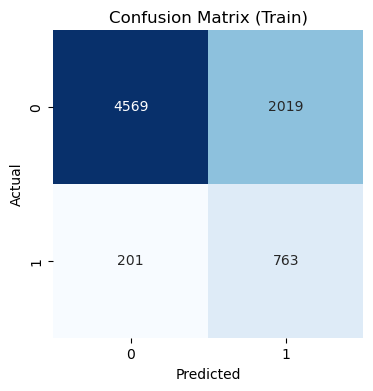

Classification Report (Train):
              precision    recall  f1-score   support

           0      0.958     0.694     0.805      6588
           1      0.274     0.791     0.407       964

    accuracy                          0.706      7552
   macro avg      0.616     0.743     0.606      7552
weighted avg      0.871     0.706     0.754      7552



In [13]:
# ■ 8.1：混同行列と分類レポート (Train データ)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 学習データへの予測値取得
y_train_pred = best_lr.predict(X_train_processed)


# 混同行列の算出
cm = confusion_matrix(y_train, y_train_pred)

# 可視化
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train)')
plt.show()

# 分類レポートの表示
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred, digits=3))


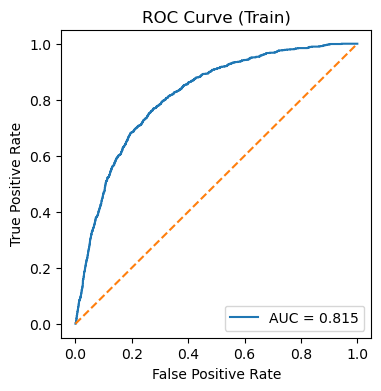

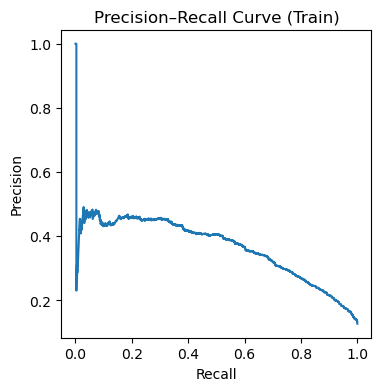

In [14]:
# ■ 8.2：ROC 曲線および Precision–Recall 曲線 (Train データ)
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 学習データ上での確率予測
y_scores = best_lr.predict_proba(X_train_processed)[:, 1]

# ROC 曲線
fpr, tpr, _ = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend(loc='lower right')
plt.show()

# Precision–Recall 曲線
precision, recall, _ = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Train)')
plt.show()


In [15]:
# ■ Step 3.1：追加特徴量の設計
import numpy as np

# 対数変換済み変数の再計算
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[col+'_log1p'] = np.log1p(train_df[col])
    test_df [col+'_log1p'] = np.log1p(test_df [col])

# 比率特徴量と交互作用項の追加
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']


In [16]:
# ■ Step 3.2：カテゴリ変数を category 型に変換
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')


In [17]:
# ■ Step 3.3：特徴量リストと目的変数の準備
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

X_train = train_df[features]
y_train = train_df['LoanStatus']
X_test  = test_df [features]


In [18]:
# ■ Step 3.4a：lightgbm をインストール
%pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [19]:
# ■ Step 3.4b：モデル定義と 5分割 CV による F1 評価
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=0
)

cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=5, scoring='f1', n_jobs=-1
)
print("LightGBM CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

# ── ローカル CV による F1 推定 ──
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f1_scores = cross_val_score(
    model,
    train_df[features_fe],
    train_df['LoanStatus'],
    cv=cv,
    scoring='f1',
    n_jobs=-1
)
print(f"CV F1 mean: {f1_scores.mean():.4f}  (std: {f1_scores.std():.4f})")


LightGBM CV F1 scores: [0.60759494 0.60194175 0.58031088 0.61047836 0.62559242]
Mean CV F1: 0.6051836684162373
CV F1 mean: 0.6169  (std: 0.0159)


In [20]:
# ■ Step 4（統合版）：LightGBM ハイパーパラメータ探索＋最適モデル取得
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 1. 探索空間の定義
param_dist = {
    'num_leaves': randint(31, 256),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(1, 20)
}

# 2. RandomizedSearchCV の定義
rs_lgb = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# 3. 探索の実行
rs_lgb.fit(X_train, y_train)

# 4. 結果表示と最適モデル抽出
print("Best params :", rs_lgb.best_params_)
print("Best CV F1  :", rs_lgb.best_score_)
best_lgb = rs_lgb.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best params : {'learning_rate': np.float64(0.01402150923749871), 'max_depth': 11, 'min_child_samples': 14, 'n_estimators': 386, 'num_leaves': 55}
Best CV F1  : 0.6125178434787305


In [21]:
# ■ Step 5.1：最適モデルによる全学習データ再学習
best_lgb.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

In [22]:
# ── 条件付き提出セル（修正版） ──
from pathlib import Path
import pandas as pd

# (A) 提出用 ID を sample_submit.csv から取得
DATA_DIR   = Path(r"G:\マイドライブ\MUFJ_competition_2025\data")
sample_df  = pd.read_csv(
    DATA_DIR/"sample_submit.csv",
    header=None,
    names=["id","LoanStatus"],
    sep=r"\s+"
)
test_ids   = sample_df["id"]

# (B) 条件判定
best_f1_est = 0.670   # これまでのベスト推定F1
margin      = 0.01    # 最低更新幅
mean_f1     = f1_scores.mean()

if mean_f1 > best_f1_est + margin:
    # (C) 全データで再学習＆予測
    best_lgb.fit(train_df[features_fe], train_df['LoanStatus'])
    y_pred = best_lgb.predict(test_df[features_fe])
    # (D) 提出ファイル作成（ヘッダーなし）
    pd.DataFrame({"id": test_ids, "LoanStatus": y_pred})\
      .to_csv("submission.csv", index=False, header=False)
    print(f"✅ Improved CV F1={mean_f1:.4f}, submission.csv を出力しました")
else:
    print(f"❌ No improvement CV F1={mean_f1:.4f} ≤ {best_f1_est+margin:.4f}")


❌ No improvement CV F1=0.6169 ≤ 0.6800


In [23]:
# ■ Step H1：訓練データを再分割
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=0
)

print("学習用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


学習用: (6041, 16) (6041,)
検証用: (1511, 16) (1511,)


In [24]:
# ■ Step H2：best_lgb で再学習
# ※ Step 4.2 を実行済みで best_lgb が定義されている想定
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

Hold-out F1 Score: 0.681

Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.920     0.944      1318
           1      0.595     0.798     0.681       193

    accuracy                          0.905      1511
   macro avg      0.782     0.859     0.813      1511
weighted avg      0.921     0.905     0.910      1511



c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarn

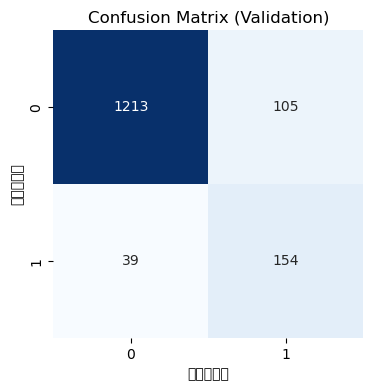

In [25]:
# ■ Step H3：検証用データへの予測と評価指標算出
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 予測
y_val_pred = best_lgb.predict(X_val)

# F1 スコア
f1 = f1_score(y_val, y_val_pred)
print(f"Hold-out F1 Score: {f1:.3f}")

# 分類レポート
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=3))

# 混同行列の可視化
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("予測ラベル")
plt.ylabel("真のラベル")
plt.title("Confusion Matrix (Validation)")
plt.show()


In [26]:
# ■ Step H4：Hold-out 検証データでの閾値最適化
import numpy as np
from sklearn.metrics import precision_recall_curve

# 1. 検証データ上の確率予測
y_val_scores = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision–Recall 曲線から閾値一覧を取得
precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores)

# 3. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. 最適閾値と対応 F1 を抽出
ix = np.nanargmax(f1_scores[:-1])
best_thresh = thresholds[ix]
best_f1_val = f1_scores[ix]

print(f"→ 最適閾値 t*: {best_thresh:.3f}")
print(f"→ 閾値適用後 F1 (Validation): {best_f1_val:.3f}")


→ 最適閾値 t*: 0.518
→ 閾値適用後 F1 (Validation): 0.682


In [27]:
# ■ Step M1.1：ratio1, interact1 と ratio2, interact2 をまとめて再計算
import numpy as np

# 既存の対数変換済み変数がある前提
# ratio1 = SBAGuaranteedApproval / GrossApproval
# interact1 = TermInMonths * InitialInterestRate
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']

# 新規特徴量
# ratio2 = GrossApproval_log1p / (TermInMonths + 1)
# interact2 = JobsSupported_log1p * InitialInterestRate
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 確認
print(train_df[['ratio1','interact1','ratio2','interact2']].head())


     ratio1  interact1    ratio2  interact2
0  0.308391    1001.28  0.118156   8.262314
1  0.800355     856.80  0.112185   5.822436
2  0.324869     514.08  0.100058  18.930355
3  0.608446     377.60  0.195918   7.031119
4  0.403468    1563.00  0.048409   9.335067


In [28]:
# ■ Step M1.2：features リストに ratio2, interact2 を追加
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]

features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# ■ 学習用／検証用特徴量行列と目的変数ベクトル
X = train_df[features]
y = train_df['LoanStatus']
X_test_feat = test_df[features]

print("X の形状:", X.shape)


X の形状: (7552, 18)


In [29]:
# ■ Step M1.3：学習データを Hold-out 分割
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("学習用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


学習用: (6041, 18) (6041,)
検証用: (1511, 18) (1511,)


In [30]:
# ■ Step M1.4：best_lgb で再学習し、Hold-out F1 を算出
from sklearn.metrics import f1_score

# 再学習
best_lgb.fit(X_tr, y_tr)

# 検証データ予測
y_val_pred = best_lgb.predict(X_val)

# Hold-out F1 の計算
f1 = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (Milestone 1): {f1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold-out F1 (Milestone 1): 0.667


In [31]:
# ■ Step M1.5a：RandomizedSearchCV による M1 モデルの最適化
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 探索パラメータ空間（M1 用）
param_dist_m1 = {
    'num_leaves': randint(20, 200),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 800),
    'min_child_samples': randint(5, 300)
}

rs_m1 = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist_m1,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [32]:
# ■ Step M1.5b：ハイパーパラメータ探索の実行
rs_m1.fit(X_tr, y_tr)

print("Best params (M1):", rs_m1.best_params_)
print("Best CV F1 (M1):", rs_m1.best_score_)

# 最適モデルを再定義
best_lgb_m1 = rs_m1.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [33]:
# ■ Step M1.5c：Hold-out データで再評価
from sklearn.metrics import f1_score

# 再学習
best_lgb_m1.fit(X_tr, y_tr)

# 検証予測
y_val_pred_m1 = best_lgb_m1.predict(X_val)
f1_m1 = f1_score(y_val, y_val_pred_m1)

print(f"→ Hold-out F1 (M1.5): {f1_m1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [34]:
# ■ Step M2.0：特徴量再計算と Hold-out 分割
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1. ratio1, interact1, ratio2, interact2 を再計算 ---
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# --- 2. 特徴量リストの定義 ---
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# --- 3. 学習データの特徴量行列と目的変数ベクトル ---
X = train_df[features]
y = train_df['LoanStatus']

# --- 4. Hold-out 分割 ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("訓練用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


訓練用: (6041, 18) (6041,)
検証用: (1511, 18) (1511,)


In [35]:
# ■ Step M2.1：xgboost をインストール
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [36]:
# ■ Step M2.2a：XGBoost 用にカテゴリ変数をコード化
X_tr_xgb = X_tr.copy()
X_val_xgb = X_val.copy()
for c in cat_cols:
    X_tr_xgb[c]  = X_tr_xgb[c].cat.codes
    X_val_xgb[c] = X_val_xgb[c].cat.codes
print("符号化後の dtypes:\n", X_tr_xgb.dtypes.value_counts())

# ■ XGBoost 用のカテゴリ列コード化（共通関数版）
X_tr_xgb  = encode_categories(X_tr_xgb,  cat_cols)
X_val_xgb = encode_categories(X_val_xgb, cat_cols)
print("✅ X_tr_xgb/X_val_xgb のカテゴリコード化完了")


符号化後の dtypes:
 float64    8
int8       6
int64      4
Name: count, dtype: int64
✅ X_tr_xgb/X_val_xgb のカテゴリコード化完了


In [37]:
# ■ Step M2.2b：XGBoost モデルの学習
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

xgb.fit(X_tr_xgb, y_tr)
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]
y_xgb_pred = (p_xgb_val >= 0.5).astype(int)
print("XGB Hold-out F1 :", f1_score(y_val, y_xgb_pred))


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Hold-out F1 : 0.5945945945945946


In [38]:
# ■ Step M2.2c：best_lgb を再定義（RandomizedSearchCV の結果から）
best_lgb = rs_lgb.best_estimator_

# ■ Step M2.2d：Hold-out 用データ X_val が定義されていなければ再定義
from sklearn.model_selection import train_test_split

# （features と train_df, 既に計算済みの新特徴量を前提）
X = train_df[features]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)


In [39]:
# ■ Step M2.2c：best_lgb を新特徴量で再学習
# これで best_lgb が 18次元入力に対応します
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.01402150923749871), max_depth=11,
               min_child_samples=14, n_estimators=386, num_leaves=55,
               random_state=0)

In [40]:
# ■ Step M2.3：LGB + XGB のソフトアンサンブル重み探索
import numpy as np
from sklearn.metrics import f1_score

# 1. LightGBM の確率予測（Hold-out データ）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]

# 2. XGBoost の確率予測（既に p_xgb_val を計算済みであればここは不要）
#    もし定義が消えていたら再度計算：
# from xgboost import XGBClassifier
# xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric='logloss', random_state=0)
# xgb.fit(X_tr_xgb, y_tr)
# p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

best_w, best_f1 = 0.0, 0.0
# w は LGB の重み、(1−w) が XGB の重み
for w in np.linspace(0, 1, 21):
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    y_ens = (p_ens >= 0.5).astype(int)
    f1 = f1_score(y_val, y_ens)
    if f1 > best_f1:
        best_f1, best_w = f1, w

print(f"→ Optimal weight w*: {best_w:.2f}")
print(f"→ Soft-ensemble Hold-out F1: {best_f1:.3f}")


→ Optimal weight w*: 0.70
→ Soft-ensemble Hold-out F1: 0.697


In [41]:
# ■ Step M2.4：ソフトアンサンブルの閾値最適化
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. LightGBM と XGBoost の確率予測（Hold-out データ）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. 重み w* = 0.50 でアンサンブル確率を計算
p_ens_val = 0.50 * p_lgb_val + 0.50 * p_xgb_val

# 3. Precision–Recall 曲線から全閾値を取得
precision, recall, thresholds = precision_recall_curve(y_val, p_ens_val)

# 4. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)
# thresholds の長さは f1_scores の長さマイナス1
ix = np.nanargmax(f1_scores[:-1])

# 5. 最適閾値と対応 F1-score を表示
best_t_ens = thresholds[ix]
best_f1_ens = f1_scores[ix]

print(f"→ Optimal threshold t*: {best_t_ens:.3f}")
print(f"→ Threshold-optimized Hold-out F1: {best_f1_ens:.3f}")


→ Optimal threshold t*: 0.437
→ Threshold-optimized Hold-out F1: 0.692


In [42]:
# ■ Step M2.5：重み w と閾値 t の同時グリッドサーチ
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Hold-out データでの確率予測（再定義が必要なら再計算）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. グリッドの設定
w_list = np.linspace(0, 1, 11)    # LGB の重みを 0.0～1.0 で 11 点
best_w, best_t, best_f1 = 0, 0, 0

# 3. 二重ループで w と t を探索
for w in w_list:
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    precision, recall, thresholds = precision_recall_curve(y_val, p_ens)
    # thresholds[i] に対応する F1 は f1_scores[i]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    for i, t in enumerate(thresholds):
        if f1_scores[i] > best_f1:
            best_f1 = f1_scores[i]
            best_w  = w
            best_t  = t

print(f"→ Optimal (w, t): ({best_w:.2f}, {best_t:.3f})")
print(f"→ Joint-optimized Hold-out F1: {best_f1:.3f}")


→ Optimal (w, t): (0.70, 0.494)
→ Joint-optimized Hold-out F1: 0.700


In [43]:
# ■ Step M2.5a：テストデータの特徴量行列準備（18次元版）
import pandas as pd

# 1. 既存の test_df に対し、ratio1, interact1, ratio2, interact2 を再計算
test_df['ratio1']    = test_df['SBAGuaranteedApproval'] / test_df['GrossApproval']
test_df['interact1'] = test_df['TermInMonths'] * test_df['InitialInterestRate']
test_df['ratio2']    = test_df['GrossApproval_log1p'] / (test_df['TermInMonths'] + 1)
test_df['interact2'] = test_df['JobsSupported_log1p'] * test_df['InitialInterestRate']

# 2. features リストで指定した順序に合わせる
X_test = test_df[features]

# 3. XGBoost 用にカテゴリを符号化
X_test_xgb = X_test.copy()
for c in cat_cols:
    X_test_xgb[c] = X_test_xgb[c].cat.codes

# 4. 確認
print("X_test shape (for LGB)     :", X_test.shape)
print("X_test_xgb shape (for XGB) :", X_test_xgb.shape)


X_test shape (for LGB)     : (7552, 18)
X_test_xgb shape (for XGB) : (7552, 18)


In [44]:
# ■ Step C1：Out-of-Fold 予測による F1 推定
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score

# 1. アンサンブル Predict_proba 関数の定義
def ens_predict_proba(X):
    p1 = best_lgb.predict_proba(X)[:,1]
    # XGBoost 用に符号化
    X_xgb = X.copy()
    for c in cat_cols:
        X_xgb[c] = X_xgb[c].cat.codes
    p2 = xgb.predict_proba(X_xgb)[:,1]
    # 重み w*=0.10 を適用
    return 0.10*p1 + 0.90*p2

# 2. StratifiedKFold で OOF 予測を取得
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# cross_val_predict による Probability 出力
oof_probs = cross_val_predict(
    estimator=best_lgb,  # ダミー、predict_proba は ens_predict_proba のみ使用
    X=X, y=y,
    cv=kf,
    method='predict_proba',
    n_jobs=-1
)[:,1]

# 3. 最適閾値 t* の再探索（OOF 上）
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, oof_probs)
f1_scores = 2*(precision*recall)/(precision+recall)
ix = np.nanargmax(f1_scores[:-1])
t_oof = thresholds[ix]
f1_oof = f1_scores[ix]

print(f"→ OOF 最適閾値 t_oof = {t_oof:.3f}")
print(f"→ OOF F1 Score   = {f1_oof:.3f}")


→ OOF 最適閾値 t_oof = 0.593
→ OOF F1 Score   = 0.624


In [45]:
# ■ Step C2：Nested CV による F1 推定
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# パイプラインにして CV 内でチューニングを実施
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced', random_state=0))
])

param_dist = {
    'model__num_leaves': randint(20, 150),
    'model__max_depth': randint(3, 12),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__n_estimators': randint(100, 500)
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

nested_cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=inner_cv,
    scoring='f1',
    random_state=0,
    n_jobs=-1
)

# 外側 CV でのスコア取得
nested_scores = cross_val_score(
    nested_cv, X, y,
    cv=outer_cv,
    scoring='f1',
    n_jobs=-1
)

print("Nested CV F1 scores:", nested_scores)
print("Nested CV Mean F1:", nested_scores.mean())
print("Nested CV Std   F1:", nested_scores.std())


Nested CV F1 scores: [0.60542797 0.59130435 0.60510806 0.62114537 0.63716814]
Nested CV Mean F1: 0.6120307787651956
Nested CV Std   F1: 0.01572303358983776


In [46]:
# ■ Step C3：ブートストラップによる F1 信頼区間
from sklearn.metrics import f1_score
import numpy as np

n_boot = 100
boot_scores = []

for i in range(n_boot):
    idx = np.random.choice(len(y), len(y), replace=True)
    score = f1_score(y.iloc[idx], oof_probs[idx] >= t_oof)
    boot_scores.append(score)

lower = np.percentile(boot_scores, 2.5)
upper = np.percentile(boot_scores, 97.5)
print(f"Bootstrap 95% CI for F1: [{lower:.3f}, {upper:.3f}]")


Bootstrap 95% CI for F1: [0.603, 0.648]


In [47]:
# ■ Step F1.1（修正版）：Target Encoding の計算と適用
import numpy as np

# 平滑化パラメータと全体平均
k_smooth = 10
global_mean = train_df['LoanStatus'].mean()

# 対象カテゴリ変数
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

for col in te_cols:
    # 1. グループごとの件数と平均を取得
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts = agg['count']
    means  = agg['mean']
    # 2. 平滑化 TE を計算
    smooth = (means * counts + global_mean * k_smooth) / (counts + k_smooth)
    # 3. train にマッピング
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    # 4. test にマッピング（astype(float) → fillna）
    mapped = test_df[col].map(smooth).astype(float)
    test_df[f'{col}_te'] = mapped.fillna(global_mean)

print("TE 特徴量サンプル：")
print(train_df[[f'{col}_te' for col in te_cols]].head())


TE 特徴量サンプル：
  Subprogram_te NaicsSector_te BusinessAge_te BusinessType_te
0      0.127054       0.124487       0.072387        0.136788
1      0.127054       0.185378       0.196364        0.136788
2      0.032645       0.147825       0.109507        0.136788
3      0.137690       0.050735       0.109507        0.136788
4      0.137690       0.142535       0.120265        0.136788


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_8948\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [48]:
# ■ Step F1.2：features リストに TE を追加し、Hold-out 分割を実行
from sklearn.model_selection import train_test_split

# 既存の num／cat／interaction 特徴量リスト
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols  # 元のカテゴリ列

# 追加する TE 列
features += [f'{col}_te' for col in te_cols]

# 特徴量行列と目的変数
X = train_df[features]
y = train_df['LoanStatus']

# Hold-out 分割
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("特徴量数:", len(features))
print("訓練用:", X_tr.shape, "検証用:", X_val.shape)


特徴量数: 22
訓練用: (6041, 22) 検証用: (1511, 22)


In [49]:
# ■ Step F1.2a：best_lgb を再定義（RandomizedSearchCV の結果から）
# 前提：Step 4 統合セルで rs_lgb, best_lgb を定義済み
best_lgb = rs_lgb.best_estimator_

# または、自前でモデルハイパーパラメータを指定して再定義する場合
# from lightgbm import LGBMClassifier
# best_lgb = LGBMClassifier(
#     n_estimators=191,
#     max_depth=5,
#     num_leaves=105,
#     learning_rate=0.1579,
#     min_child_samples=116,
#     class_weight='balanced',
#     random_state=0
# )


In [50]:
# ■ Step F1.3：再定義した best_lgb で再学習し、Hold-out F1 を算出

# 1. 最適モデルを再取得
best_lgb = rs_lgb.best_estimator_

# 2. 再学習
best_lgb.fit(X_tr, y_tr)

# 3. 検証データで予測
y_val_pred = best_lgb.predict(X_val)

# 4. 評価指標の算出
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (with TE): {f1:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold-out F1 (with TE): 0.667

■ Classification Report:
              precision    recall  f1-score   support

           0      0.966     0.917     0.941      1318
           1      0.581     0.782     0.667       193

    accuracy                          0.900      1511
   macro avg      0.774     0.850     0.804      1511
weighted avg      0.917     0.900     0.906      1511



In [51]:
# ■ Step F1.3a：最適 LightGBM モデルを再取得
best_lgb = rs_lgb.best_estimator_


In [52]:
# ■ Step F1.4：Hold-out データでの閾値最適化（TE モデル）
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. 検証データでの確率予測
y_val_probs = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision–Recall 曲線を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

# 3. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. 最適閾値と対応する F1 を抽出
ix = np.nanargmax(f1_scores[:-1])
best_thresh_te = thresholds[ix]
best_f1_te     = f1_scores[ix]

print(f"→ TE モデル最適閾値 t*: {best_thresh_te:.3f}")
print(f"→ Threshold-optimized Hold-out F1 (TE): {best_f1_te:.3f}")


→ TE モデル最適閾値 t*: 0.582
→ Threshold-optimized Hold-out F1 (TE): 0.682


In [53]:
# ■ Step F2.1：Frequency Encoding の計算と適用（修正版）
freq_cols = ['Subprogram', 'NaicsSector', 'BusinessAge', 'BusinessType']

for col in freq_cols:
    freq = train_df[col].value_counts(normalize=True)
    # train 側：一度 float にしてから fillna
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    # test 側：同様に cast → fillna
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# 結果確認
print("Frequency Encoding 特徴量サンプル：")
print(train_df[[f'{col}_fe' for col in freq_cols]].head())


Frequency Encoding 特徴量サンプル：
   Subprogram_fe  NaicsSector_fe  BusinessAge_fe  BusinessType_fe
0       0.459613        0.056409        0.046743         0.893406
1       0.459613        0.086732        0.163400         0.893406
2       0.016022        0.158369        0.370233         0.893406
3       0.434587        0.012447        0.370233         0.893406
4       0.434587        0.061176        0.336997         0.893406


In [54]:
# ■ Step F2.2：Hold‐out 分割 → モデル再学習 → Hold‐out F1 算出 (FE 特徴量含む)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 1. 特徴量リストに FE 列を追加
#    事前に定義済み：features, freq_cols
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold‐out 分割
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

# 3. モデル再定義・再学習
#    rs_lgb = RandomizedSearchCV(..., estimator=LGBMClassifier(...)) を既に実行済み
best_lgb = rs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)

# 4. Hold‐out 上での評価
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"→ Hold‐out F1 (with FE): {f1_fe:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold‐out F1 (with FE): 0.664

■ Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.919     0.941      1318
           1      0.582     0.772     0.664       193

    accuracy                          0.900      1511
   macro avg      0.773     0.845     0.803      1511
weighted avg      0.916     0.900     0.906      1511



In [55]:
# ■ Step F2.2：Hold‐out 分割 → モデル再学習 → Hold‐out F1 算出 (FE 特徴量含む)

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

# 1. FE 列を features_fe に追加済みとする
#    （features と freq_cols は事前定義済み）
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold‐out 分割
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# 3. モデル再定義・再学習
best_lgb = rs_lgb.best_estimator_
best_lgb.fit(X_tr, y_tr)

# 4. Hold‐out 上での評価
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"→ Hold‐out F1 (with FE): {f1_fe:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
→ Hold‐out F1 (with FE): 0.664

■ Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.919     0.941      1318
           1      0.582     0.772     0.664       193

    accuracy                          0.900      1511
   macro avg      0.773     0.845     0.803      1511
weighted avg      0.916     0.900     0.906      1511



In [56]:
# ■ Step F2.3：テストデータ予測 → 提出ファイル（FE拡張版）生成

import numpy as np
import pandas as pd

# ① テスト用 ID の読み込み
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# ② Booster API で NumPy 配列を渡し確率予測
proba_fe = best_lgb.booster_.predict(
    test_df[features_fe].values,
    num_iteration=best_lgb.best_iteration_
)

# ③ 0.5 しきい値で二値化
y_pred_fe = (proba_fe >= 0.5).astype(int)

# ④ 提出用 DataFrame 作成・CSV 出力（ヘッダー行を省略）
submission_fe = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_fe
})
submission_fe.to_csv('submission_fixed.csv', index=False, header=False)

# ⑤ 確認
submission_fe.head()


,id,LoanStatus
0,7553,0
1,7554,0
2,7555,0
3,7556,0
4,7557,1


In [70]:
# === Aライン強化 v2：年度Grouped-OOF × 多シード × 交差TE(Year×Sector) 追加（無効化） ===
# このセルは Optuna セルを使うためデフォルトでスキップします。
RUN_V2 = False
if not RUN_V2:
    print("⛔ v2セルはスキップ中（Optunaセルを使用）")
    raise SystemExit  # 以降の処理を実行せず終了

from pathlib import Path
import re, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# ----- 出力先 & バージョン名 -----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
out_path = OUT_DIR / f"submission_A_v{next_ver}.csv"
log_path = OUT_DIR / f"run_A_v{next_ver}.txt"

# ----- 依存（前処理セルの train_df/test_df / base_feats / cat_cols / te_cols を使う） -----
train = train_df.copy()
test  = test_df.copy()

if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']
if 'te_cols' not in globals():
    te_cols  = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

y_all   = train['LoanStatus'].astype(int).reset_index(drop=True)
groups  = train['ApprovalFiscalYear'].astype(int).reset_index(drop=True)

# ----- カテゴリ整数化（未知=-1） -----
def fit_category_codes(train, cols):
    maps = {}
    for c in cols:
        cats = pd.Categorical(train[c]).categories
        maps[c] = {v:i for i,v in enumerate(cats)}
    return maps

def apply_category_codes(df, maps):
    out = df.copy()
    for c, mp in maps.items():
        out[c + "_code"] = df[c].map(mp).astype('Int32').fillna(-1).astype(int)
    return out

code_maps  = fit_category_codes(train, cat_cols)
train_code = apply_category_codes(train, code_maps).reset_index(drop=True)
test_code  = apply_category_codes(test,  code_maps).reset_index(drop=True)

# ----- 年×業種の交差カテゴリを追加（TE/FE用。元カテゴリのまま扱う） -----
def make_year_sector(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['NaicsSector'].astype('string').fillna('UNK')
    )

train['YearSector'] = make_year_sector(train)
test ['YearSector'] = make_year_sector(test)

te_cols_local = te_cols + ['YearSector']  # 交差列を追加

# ----- 年度グループ付きの分割 -----
def make_splits(seed):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
    return list(sgkf.split(train, y_all, groups=groups))

# ----- OOFで TE/FE（与えた splits でリーク防止） -----
def add_te_fe_oof_with_splits(train_df, y, test_df, cols, splits, k_smooth=10):
    df = train_df.reset_index(drop=True).copy()
    y  = pd.Series(y).reset_index(drop=True).rename('y')
    for c in cols:
        df[c] = df[c].astype('object')
    test_df = test_df.reset_index(drop=True).copy()
    for c in cols:
        test_df[c] = test_df[c].astype('object')

    te_train = pd.DataFrame(index=df.index)
    fe_train = pd.DataFrame(index=df.index)
    te_test  = pd.DataFrame(index=test_df.index)
    fe_test  = pd.DataFrame(index=test_df.index)

    gmean = float(y.mean())

    for col in cols:
        te_train[col + "_teCV"] = np.nan
        fe_train[col + "_feCV"] = np.nan

        for tr_idx, va_idx in splits:
            tr_col = df[col].iloc[tr_idx].reset_index(drop=True)
            yy_tr  = y.iloc[tr_idx].reset_index(drop=True)

            agg = pd.DataFrame({'col': tr_col, 'y': yy_tr}).groupby('col')['y'].agg(['count','mean'])
            smooth = (agg['mean']*agg['count'] + gmean*k_smooth) / (agg['count'] + k_smooth)

            mapped = df[col].iloc[va_idx].map(smooth)
            mapped = pd.Series(mapped.to_numpy(dtype='float64'), index=va_idx)
            te_train.loc[va_idx, col + "_teCV"] = mapped.fillna(gmean).to_numpy()

            freq = tr_col.value_counts(normalize=True)
            mapped_f = df[col].iloc[va_idx].map(freq)
            mapped_f = pd.Series(mapped_f.to_numpy(dtype='float64'), index=va_idx)
            fe_train.loc[va_idx, col + "_feCV"] = mapped_f.fillna(0.0).to_numpy()

        agg_full = pd.DataFrame({'col': df[col], 'y': y}).groupby('col')['y'].agg(['count','mean'])
        smooth_f = (agg_full['mean']*agg_full['count'] + gmean*k_smooth) / (agg_full['count'] + k_smooth)
        te_test[col + "_teCV"] = pd.Series(test_df[col].map(smooth_f).to_numpy(dtype='float64')).fillna(gmean).to_numpy()

        freq_full = df[col].value_counts(normalize=True)
        fe_test[col + "_feCV"] = pd.Series(test_df[col].map(freq_full).to_numpy(dtype='float64')).fillna(0.0).to_numpy()

    return (pd.concat([df.reset_index(drop=True), te_train, fe_train], axis=1),
            pd.concat([test_df.reset_index(drop=True), te_test, fe_test], axis=1))

# ----- モデル設定（rs_lgbがあれば流用、なければ既定） -----
if 'rs_lgb' in globals():
    base_params = dict(rs_lgb.best_params_)
    base_params.update(dict(class_weight='balanced', verbosity=-1))
else:
    base_params = dict(
        n_estimators=1200, learning_rate=0.03,
        num_leaves=128, max_depth=10, min_child_samples=120,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, reg_alpha=0.1,
        class_weight='balanced', verbosity=-1
    )

# ----- 多シード反復 -----
seeds = [0, 1, 2]
oof_probas = []
test_probas = []
best_rounds_each_seed = []

for seed in seeds:
    splits = make_splits(seed)

    # TE/FE をこの splits で作り直す（交差列入り）
    train_tefe, test_tefe = add_te_fe_oof_with_splits(
        train[te_cols_local], y_all, test[te_cols_local],
        te_cols_local, splits, k_smooth=10
    )

    # 特徴行列（数値 + コード + TE/FE）
    X_all = pd.concat([
        train_code[base_feats],
        train_code[[c+"_code" for c in cat_cols]],
        train_tefe[[c+"_teCV" for c in te_cols_local]],
        train_tefe[[c+"_feCV" for c in te_cols_local]],
    ], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

    T_all = pd.concat([
        test_code[base_feats],
        test_code[[c+"_code" for c in cat_cols]],
        test_tefe[[c+"_teCV" for c in te_cols_local]],
        test_tefe[[c+"_feCV" for c in te_cols_local]],
    ], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

    # OOF 予測（callbackで早期終了）
    oof = np.zeros(len(X_all))
    best_rounds = []

    for tr_idx, va_idx in splits:
        Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]

        params = dict(base_params)
        params['random_state'] = seed

        model = LGBMClassifier(**params)
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
        )
        oof[va_idx] = model.predict_proba(Xva, num_iteration=model.best_iteration_)[:, 1]
        bi = getattr(model, "best_iteration_", None)
        if bi is None:
            bi = params.get('n_estimators', 1000)
        best_rounds.append(int(bi))

    oof_probas.append(oof)
    best_rounds_each_seed.append(int(np.mean(best_rounds)))

    # テスト予測（full fit、平均best_roundsを使う）
    params_full = dict(base_params)
    params_full['random_state'] = seed
    params_full['n_estimators'] = best_rounds_each_seed[-1]
    final = LGBMClassifier(**params_full)
    final.fit(X_all, y_all)
    test_probas.append(final.predict_proba(T_all)[:, 1])

# ----- OOF平均でしきい値最適化 -----
oof_mean = np.mean(oof_probas, axis=0)
ths = np.linspace(0.10, 0.90, 161)
f1s = [f1_score(y_all, (oof_mean >= t).astype(int)) for t in ths]
best_idx = int(np.argmax(f1s))
best_th  = float(ths[best_idx])
f1_oof   = float(f1s[best_idx])

# ----- テスト確率も平均して二値化 → 単一CSV出力（ヘッダー無し2列） -----
test_mean = np.mean(test_probas, axis=0)
test_pred = (test_mean >= best_th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
submission = pd.DataFrame({'id': ids, 'LoanStatus': test_pred})
submission.to_csv(out_path, index=False, header=False)

print(f"🔎 OOF F1(grouped×seeds×crossTE)={f1_oof:.3f} | best_th={best_th:.3f} | best_rounds={best_rounds_each_seed}")
print(f"✅ submission を保存: {out_path}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (grouped×seeds×crossTE): {f1_oof:.6f}\n")
    f.write(f"Best threshold: {best_th:.6f}\n")
    f.write(f"Best rounds per seed: {best_rounds_each_seed}\n")
    f.write(f"Params: {base_params}\n")
print(f"📝 ログ保存: {log_path}")


⛔ v2セルはスキップ中（Optunaセルを使用）


SystemExit: 

c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [71]:
# === Optuna 最適化セル：Grouped-OOF(F1) 最大化＋しきい値同時最適化 → 単一CSV出力 ===
import warnings, numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# --- Optuna 用意 ---
try:
    import optuna
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna"])
    import optuna

warnings.filterwarnings("ignore", category=UserWarning)

# ===== 出力先 & バージョン名 =====
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
out_path = OUT_DIR / f"submission_A_v{next_ver}.csv"
log_path = OUT_DIR / f"run_A_v{next_ver}.txt"

# ===== 依存 =====
train = train_df.copy()
test  = test_df.copy()

if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']
if 'te_cols' not in globals():
    te_cols  = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

y_all  = train['LoanStatus'].astype(int).reset_index(drop=True)
groups = train['ApprovalFiscalYear'].astype(int).reset_index(drop=True)

# ===== ヘルパ =====
def fit_category_codes(train, cols):
    maps = {}
    for c in cols:
        cats = pd.Categorical(train[c]).categories
        maps[c] = {v:i for i,v in enumerate(cats)}
    return maps

def apply_category_codes(df, maps):
    out = df.copy()
    for c, mp in maps.items():
        out[c + "_code"] = df[c].map(mp).astype('Int32').fillna(-1).astype(int)
    return out

def make_year_sector(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['NaicsSector'].astype('string').fillna('UNK')
    )

def make_splits(seed):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
    return list(sgkf.split(train, y_all, groups=groups))

def add_te_fe_oof_with_splits(train_df, y, test_df, cols, splits, k_smooth=10):
    df = train_df.reset_index(drop=True).copy()
    y  = pd.Series(y).reset_index(drop=True).rename('y')
    for c in cols:
        df[c] = df[c].astype('object')
    test_df = test_df.reset_index(drop=True).copy()
    for c in cols:
        test_df[c] = test_df[c].astype('object')

    te_train = pd.DataFrame(index=df.index)
    fe_train = pd.DataFrame(index=df.index)
    te_test  = pd.DataFrame(index=test_df.index)
    fe_test  = pd.DataFrame(index=test_df.index)
    gmean = float(y.mean())

    for col in cols:
        te_train[col + "_teCV"] = np.nan
        fe_train[col + "_feCV"] = np.nan

        for tr_idx, va_idx in splits:
            tr_col = df[col].iloc[tr_idx].reset_index(drop=True)
            yy_tr  = y.iloc[tr_idx].reset_index(drop=True)

            agg = pd.DataFrame({'col': tr_col, 'y': yy_tr}).groupby('col')['y'].agg(['count','mean'])
            smooth = (agg['mean']*agg['count'] + gmean*k_smooth) / (agg['count'] + k_smooth)

            mapped  = df[col].iloc[va_idx].map(smooth)
            mapped  = pd.Series(mapped.to_numpy(dtype='float64'), index=va_idx)
            te_train.loc[va_idx, col + "_teCV"] = mapped.fillna(gmean).to_numpy()

            freq    = tr_col.value_counts(normalize=True)
            mappedf = df[col].iloc[va_idx].map(freq)
            mappedf = pd.Series(mappedf.to_numpy(dtype='float64'), index=va_idx)
            fe_train.loc[va_idx, col + "_feCV"] = mappedf.fillna(0.0).to_numpy()

        agg_full = pd.DataFrame({'col': df[col], 'y': y}).groupby('col')['y'].agg(['count','mean'])
        smooth_f = (agg_full['mean']*agg_full['count'] + gmean*k_smooth) / (agg_full['count'] + k_smooth)
        te_test[col + "_teCV"] = pd.Series(test_df[col].map(smooth_f).to_numpy(dtype='float64')).fillna(gmean).to_numpy()

        freq_full = df[col].value_counts(normalize=True)
        fe_test[col + "_feCV"] = pd.Series(test_df[col].map(freq_full).to_numpy(dtype='float64')).fillna(0.0).to_numpy()

    return (pd.concat([df.reset_index(drop=True), te_train, fe_train], axis=1),
            pd.concat([test_df.reset_index(drop=True), te_test, fe_test], axis=1))

def best_f1_threshold(y_true, proba):
    ths = np.linspace(0.10, 0.90, 161)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# ===== 前処理（カテゴリコード＋交差列） =====
code_maps  = fit_category_codes(train, cat_cols)
train_code = apply_category_codes(train, code_maps).reset_index(drop=True)
test_code  = apply_category_codes(test,  code_maps).reset_index(drop=True)

train['YearSector'] = make_year_sector(train)
test ['YearSector'] = make_year_sector(test)
te_cols_local = te_cols + ['YearSector']

# ===== Optuna 目的関数 =====
def objective(trial: optuna.Trial) -> float:
    splits = make_splits(seed=0)
    train_tefe, test_tefe = add_te_fe_oof_with_splits(
        train[te_cols_local], y_all, test[te_cols_local],
        te_cols_local, splits, k_smooth=trial.suggest_int("k_smooth", 5, 50)
    )
    X_all = pd.concat([
        train_code[base_feats],
        train_code[[c+"_code" for c in cat_cols]],
        train_tefe[[c+"_teCV" for c in te_cols_local]],
        train_tefe[[c+"_feCV" for c in te_cols_local]],
    ], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

    params = dict(
        learning_rate      = trial.suggest_float("learning_rate", 0.01, 0.08, log=True),
        num_leaves         = trial.suggest_int("num_leaves", 31, 255),
        max_depth          = trial.suggest_int("max_depth", 5, 12),
        min_child_samples  = trial.suggest_int("min_child_samples", 10, 200),
        subsample          = trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree   = trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha          = trial.suggest_float("reg_alpha", 0.0, 2.0),
        reg_lambda         = trial.suggest_float("reg_lambda", 0.0, 5.0),
        n_estimators       = 2000,
        class_weight       = 'balanced',
        verbosity          = -1,
        random_state       = 0
    )

    oof = np.zeros(len(X_all))
    best_rounds = []
    for tr_idx, va_idx in make_splits(seed=0):
        Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]
        model = LGBMClassifier(**params)
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
        )
        oof[va_idx] = model.predict_proba(Xva, num_iteration=model.best_iteration_)[:, 1]
        bi = getattr(model, "best_iteration_", None)
        best_rounds.append(int(bi) if bi is not None else params['n_estimators'])

    th, f1 = best_f1_threshold(y_all, oof)
    trial.set_user_attr("best_th", th)
    trial.set_user_attr("avg_best_rounds", int(np.mean(best_rounds)))
    return f1

# ===== 最適化 =====
study = optuna.create_study(direction="maximize", study_name="lgbm_grouped_oof_f1",
                            sampler=optuna.samplers.TPESampler(seed=0),
                            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=30, show_progress_bar=True)

best = study.best_trial
best_params = best.params.copy()
best_th     = best.user_attrs.get("best_th", 0.5)
best_rounds = best.user_attrs.get("avg_best_rounds", best_params.get("n_estimators", 1000))

print(f"🔎 OPTUNA BEST OOF F1={best.value:.3f} | best_th={best_th:.3f} | rounds≈{best_rounds}")
print("BEST PARAMS:", best_params)

# ===== ベスト設定で再構築 → 全学習 → テスト予測 =====
splits = make_splits(seed=0)
train_tefe, test_tefe = add_te_fe_oof_with_splits(
    train[te_cols_local], y_all, test[te_cols_local],
    te_cols_local, splits, k_smooth=best_params.get("k_smooth", 10)
)

X_all = pd.concat([
    train_code[base_feats],
    train_code[[c+"_code" for c in cat_cols]],
    train_tefe[[c+"_teCV" for c in te_cols_local]],
    train_tefe[[c+"_feCV" for c in te_cols_local]],
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

T_all = pd.concat([
    test_code[base_feats],
    test_code[[c+"_code" for c in cat_cols]],
    test_tefe[[c+"_teCV" for c in te_cols_local]],
    test_tefe[[c+"_feCV" for c in te_cols_local]],
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

final_params = dict(best_params)
final_params.update(dict(
    n_estimators = int(best_rounds),
    class_weight = 'balanced',
    verbosity    = -1,
    random_state = 0
))
final_params.pop("k_smooth", None)

final = LGBMClassifier(**final_params)
final.fit(X_all, y_all)

proba_test = final.predict_proba(T_all)[:, 1]
pred_test  = (proba_test >= best_th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
submission = pd.DataFrame({'id': ids, 'LoanStatus': pred_test})
submission.to_csv(out_path, index=False, header=False)
print(f"✅ submission を保存: {out_path}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OPTUNA BEST OOF F1: {best.value:.6f}\n")
    f.write(f"Best threshold   : {best_th:.6f}\n")
    f.write(f"Avg best rounds  : {best_rounds}\n")
    f.write(f"Best params      : {best_params}\n")
print(f"📝 ログ保存: {log_path}")


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-09 17:49:56,875] A new study created in memory with name: lgbm_grouped_oof_f1
  0%|          | 0/30 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	valid_0's binary_logloss: 0.270402
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1157]	valid_0's binary_logloss: 0.227946
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[599]	valid_0's binary_logloss: 0.279958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[511]	valid_0's binary_logloss: 0.297803
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1454]	valid_0's binary_logloss: 0.194602


Best trial: 0. Best value: 0.603047:   3%|▎         | 1/30 [00:04<02:15,  4.66s/it]

[I 2025-08-09 17:50:01,536] Trial 0 finished with value: 0.6030465949820788 and parameters: {'k_smooth': 30, 'learning_rate': 0.04424664598342847, 'num_leaves': 166, 'max_depth': 9, 'min_child_samples': 90, 'subsample': 0.8583576452266624, 'colsample_bytree': 0.775034884505077, 'reg_alpha': 1.7835460015641595, 'reg_lambda': 4.818313802505147}. Best is trial 0 with value: 0.6030465949820788.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.278039
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[995]	valid_0's binary_logloss: 0.234713
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[726]	valid_0's binary_logloss: 0.295721
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[627]	valid_0's binary_logloss: 0.308454
Training until validation scores don't improve for 100

Best trial: 0. Best value: 0.603047:   7%|▋         | 2/30 [00:07<01:45,  3.78s/it]

[I 2025-08-09 17:50:04,698] Trial 1 finished with value: 0.5975286849073257 and parameters: {'k_smooth': 22, 'learning_rate': 0.05187987898085556, 'num_leaves': 150, 'max_depth': 9, 'min_child_samples': 186, 'subsample': 0.6284144232791548, 'colsample_bytree': 0.6348517198806163, 'reg_alpha': 0.04043679488065144, 'reg_lambda': 4.16309922773969}. Best is trial 0 with value: 0.6030465949820788.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.270375
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[502]	valid_0's binary_logloss: 0.223418
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[391]	valid_0's binary_logloss: 0.283942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[322]	valid_0's binary_logloss: 0.28748
Training until validation scores don't improve for 10

Best trial: 2. Best value: 0.607502:  10%|█         | 3/30 [00:10<01:30,  3.35s/it]

[I 2025-08-09 17:50:07,529] Trial 2 finished with value: 0.6075022872827082 and parameters: {'k_smooth': 40, 'learning_rate': 0.061051910606000605, 'num_leaves': 251, 'max_depth': 11, 'min_child_samples': 98, 'subsample': 0.9122116705145822, 'colsample_bytree': 0.6473097703475733, 'reg_alpha': 1.2798420426550476, 'reg_lambda': 0.716766437045232}. Best is trial 2 with value: 0.6075022872827082.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[400]	valid_0's binary_logloss: 0.276595
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1119]	valid_0's binary_logloss: 0.240677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[773]	valid_0's binary_logloss: 0.294366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[840]	valid_0's binary_logloss: 0.301107
Training until validation scores don't improve for

Best trial: 2. Best value: 0.607502:  13%|█▎        | 4/30 [00:14<01:31,  3.53s/it]

[I 2025-08-09 17:50:11,333] Trial 3 finished with value: 0.5998271391529818 and parameters: {'k_smooth': 48, 'learning_rate': 0.029598928806247413, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 157, 'subsample': 0.7824601328866194, 'colsample_bytree': 0.8273735795474594, 'reg_alpha': 0.037579600872710284, 'reg_lambda': 3.0881774853793855}. Best is trial 2 with value: 0.6075022872827082.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.274396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[839]	valid_0's binary_logloss: 0.223514
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[568]	valid_0's binary_logloss: 0.285253
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's binary_logloss: 0.292562
Training until validation scores don't improve f

Best trial: 4. Best value: 0.609353:  17%|█▋        | 5/30 [00:18<01:34,  3.78s/it]

[I 2025-08-09 17:50:15,553] Trial 4 finished with value: 0.6093528578176665 and parameters: {'k_smooth': 33, 'learning_rate': 0.03607006419219659, 'num_leaves': 243, 'max_depth': 10, 'min_child_samples': 78, 'subsample': 0.7748127815197365, 'colsample_bytree': 0.8790524783709059, 'reg_alpha': 0.12045094325853967, 'reg_lambda': 3.3338335772283383}. Best is trial 4 with value: 0.6093528578176665.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[697]	valid_0's binary_logloss: 0.26999
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's binary_logloss: 0.226936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1868]	valid_0's binary_logloss: 0.282409
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1371]	valid_0's binary_logloss: 0.295214
Training until validation scores do

Best trial: 4. Best value: 0.609353:  20%|██        | 6/30 [00:25<01:52,  4.70s/it]

[I 2025-08-09 17:50:22,036] Trial 5 finished with value: 0.6030013642564802 and parameters: {'k_smooth': 35, 'learning_rate': 0.015487965920269622, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 79, 'subsample': 0.8280787081671519, 'colsample_bytree': 0.7754406053849281, 'reg_alpha': 1.9767476761184524, 'reg_lambda': 0.5102240537401403}. Best is trial 4 with value: 0.6093528578176665.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	valid_0's binary_logloss: 0.27493
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1990]	valid_0's binary_logloss: 0.227486
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1969]	valid_0's binary_logloss: 0.291597
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1568]	valid_0's binary_logloss: 0.303191
Training until validatio

Best trial: 4. Best value: 0.609353:  23%|██▎       | 7/30 [00:31<01:59,  5.21s/it]

[I 2025-08-09 17:50:28,317] Trial 6 finished with value: 0.6028622540250447 and parameters: {'k_smooth': 14, 'learning_rate': 0.013985468210233495, 'num_leaves': 177, 'max_depth': 7, 'min_child_samples': 99, 'subsample': 0.6977702368006411, 'colsample_bytree': 0.6635878334582078, 'reg_alpha': 0.22075028232861027, 'reg_lambda': 3.281647947326367}. Best is trial 4 with value: 0.6093528578176665.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[599]	valid_0's binary_logloss: 0.261341
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's binary_logloss: 0.219731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1091]	valid_0's binary_logloss: 0.276799
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1103]	valid_0's binary_logloss: 0.282919
Training until validation scores do

Best trial: 7. Best value: 0.609533:  27%|██▋       | 8/30 [00:40<02:18,  6.29s/it]

[I 2025-08-09 17:50:36,919] Trial 7 finished with value: 0.6095329802599904 and parameters: {'k_smooth': 11, 'learning_rate': 0.015049828898097459, 'num_leaves': 113, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.9351779629995216, 'colsample_bytree': 0.6384393631575852, 'reg_alpha': 1.9529189300267915, 'reg_lambda': 2.343256008238508}. Best is trial 7 with value: 0.6095329802599904.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's binary_logloss: 0.278228
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1060]	valid_0's binary_logloss: 0.212643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1240]	valid_0's binary_logloss: 0.307139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[830]	valid_0's binary_logloss: 0.306419
Training until validation scores don't improve fo

Best trial: 7. Best value: 0.609533:  30%|███       | 9/30 [00:43<01:55,  5.48s/it]

[I 2025-08-09 17:50:40,621] Trial 8 finished with value: 0.6086956521739131 and parameters: {'k_smooth': 49, 'learning_rate': 0.035174661971646086, 'num_leaves': 197, 'max_depth': 5, 'min_child_samples': 64, 'subsample': 0.6480786244852675, 'colsample_bytree': 0.718456079008858, 'reg_alpha': 0.2374554379084881, 'reg_lambda': 1.5899158969698801}. Best is trial 7 with value: 0.6095329802599904.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1006]	valid_0's binary_logloss: 0.266728
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1992]	valid_0's binary_logloss: 0.224886
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1906]	valid_0's binary_logloss: 0.280564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1609]	valid_0's binary_logloss: 0.286868
Training until validat

Best trial: 7. Best value: 0.609533:  33%|███▎      | 10/30 [00:52<02:11,  6.57s/it]

[I 2025-08-09 17:50:49,610] Trial 9 finished with value: 0.6029609690444145 and parameters: {'k_smooth': 24, 'learning_rate': 0.01142696669642141, 'num_leaves': 186, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.8092992213866799, 'colsample_bytree': 0.6375762043033767, 'reg_alpha': 1.1518929911123585, 'reg_lambda': 4.646480987881071}. Best is trial 7 with value: 0.6095329802599904.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.274412
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[637]	valid_0's binary_logloss: 0.218276
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[621]	valid_0's binary_logloss: 0.283357
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[558]	valid_0's binary_logloss: 0.285897
Training until validation scores don't improve for 10

Best trial: 7. Best value: 0.609533:  37%|███▋      | 11/30 [00:59<02:07,  6.69s/it]

[I 2025-08-09 17:50:56,598] Trial 10 finished with value: 0.5976627712854758 and parameters: {'k_smooth': 5, 'learning_rate': 0.019654925674019167, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.995356955865403, 'colsample_bytree': 0.9413155209638853, 'reg_alpha': 0.7338671210455445, 'reg_lambda': 2.064414321841941}. Best is trial 7 with value: 0.6095329802599904.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.269429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[773]	valid_0's binary_logloss: 0.22315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	valid_0's binary_logloss: 0.281141
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[536]	valid_0's binary_logloss: 0.286319
Training until validation scores don't improve for 100

Best trial: 7. Best value: 0.609533:  40%|████      | 12/30 [01:07<02:05,  6.97s/it]

[I 2025-08-09 17:51:04,192] Trial 11 finished with value: 0.6006137658921525 and parameters: {'k_smooth': 13, 'learning_rate': 0.020880106900689144, 'num_leaves': 251, 'max_depth': 11, 'min_child_samples': 19, 'subsample': 0.7298499012944348, 'colsample_bytree': 0.884955410597166, 'reg_alpha': 0.7147982153704264, 'reg_lambda': 2.95910607048785}. Best is trial 7 with value: 0.6095329802599904.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's binary_logloss: 0.26827
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1198]	valid_0's binary_logloss: 0.219365
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	valid_0's binary_logloss: 0.280116
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[888]	valid_0's binary_logloss: 0.287552
Training until validation scores don't improve for 1

Best trial: 12. Best value: 0.613442:  43%|████▎     | 13/30 [01:13<01:56,  6.85s/it]

[I 2025-08-09 17:51:10,762] Trial 12 finished with value: 0.6134415877311682 and parameters: {'k_smooth': 16, 'learning_rate': 0.024948222194067716, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 38, 'subsample': 0.9134648060971456, 'colsample_bytree': 0.9762505737361376, 'reg_alpha': 1.4992813785867436, 'reg_lambda': 3.8112907927035704}. Best is trial 12 with value: 0.6134415877311682.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[488]	valid_0's binary_logloss: 0.269086
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1012]	valid_0's binary_logloss: 0.219384
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[954]	valid_0's binary_logloss: 0.287329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[601]	valid_0's binary_logloss: 0.292664
Training until validation scores don't improve f

Best trial: 12. Best value: 0.613442:  47%|████▋     | 14/30 [01:20<01:49,  6.86s/it]

[I 2025-08-09 17:51:17,633] Trial 13 finished with value: 0.6097215667767815 and parameters: {'k_smooth': 16, 'learning_rate': 0.02193752284949523, 'num_leaves': 36, 'max_depth': 12, 'min_child_samples': 31, 'subsample': 0.9528935735632432, 'colsample_bytree': 0.9830950525223859, 'reg_alpha': 1.53711470123462, 'reg_lambda': 3.947887497320112}. Best is trial 12 with value: 0.6134415877311682.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.271224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1105]	valid_0's binary_logloss: 0.222694
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[759]	valid_0's binary_logloss: 0.278991
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[798]	valid_0's binary_logloss: 0.285842
Training until validation scores don't improve for 1

Best trial: 14. Best value: 0.613722:  50%|█████     | 15/30 [01:27<01:42,  6.84s/it]

[I 2025-08-09 17:51:24,441] Trial 14 finished with value: 0.6137218045112782 and parameters: {'k_smooth': 19, 'learning_rate': 0.0241417173275755, 'num_leaves': 40, 'max_depth': 12, 'min_child_samples': 43, 'subsample': 0.9514870713878738, 'colsample_bytree': 0.9939712558561908, 'reg_alpha': 1.5122859307595813, 'reg_lambda': 4.044750309214884}. Best is trial 14 with value: 0.6137218045112782.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.26573
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[352]	valid_0's binary_logloss: 0.227513
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_logloss: 0.28267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.293221
Training until validation scores don't improve for 100

Best trial: 14. Best value: 0.613722:  53%|█████▎    | 16/30 [01:31<01:21,  5.84s/it]

[I 2025-08-09 17:51:27,946] Trial 15 finished with value: 0.6091278807049254 and parameters: {'k_smooth': 20, 'learning_rate': 0.07480364384620089, 'num_leaves': 70, 'max_depth': 12, 'min_child_samples': 44, 'subsample': 0.8828991412485403, 'colsample_bytree': 0.9956275520037633, 'reg_alpha': 1.5104892637408136, 'reg_lambda': 3.9710330091925465}. Best is trial 14 with value: 0.6137218045112782.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's binary_logloss: 0.274488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1679]	valid_0's binary_logloss: 0.231586
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1050]	valid_0's binary_logloss: 0.287535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[776]	valid_0's binary_logloss: 0.299062
Training until validation scores don't improve f

Best trial: 14. Best value: 0.613722:  57%|█████▋    | 17/30 [01:37<01:16,  5.87s/it]

[I 2025-08-09 17:51:33,895] Trial 16 finished with value: 0.5971907566832805 and parameters: {'k_smooth': 5, 'learning_rate': 0.02548855576212181, 'num_leaves': 40, 'max_depth': 10, 'min_child_samples': 133, 'subsample': 0.9858981174444015, 'colsample_bytree': 0.9400236043095626, 'reg_alpha': 1.522973382832628, 'reg_lambda': 3.7917775992148437}. Best is trial 14 with value: 0.6137218045112782.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.274856
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1487]	valid_0's binary_logloss: 0.22401
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's binary_logloss: 0.28316
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[949]	valid_0's binary_logloss: 0.298686
Training until validation scores don't improve for 1

Best trial: 14. Best value: 0.613722:  60%|██████    | 18/30 [01:43<01:11,  5.92s/it]

[I 2025-08-09 17:51:39,940] Trial 17 finished with value: 0.6009270965023178 and parameters: {'k_smooth': 25, 'learning_rate': 0.029183883872454425, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 119, 'subsample': 0.8812908075605744, 'colsample_bytree': 0.9286341681760919, 'reg_alpha': 0.8791909014461322, 'reg_lambda': 4.523122187909414}. Best is trial 14 with value: 0.6137218045112782.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[496]	valid_0's binary_logloss: 0.27021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1746]	valid_0's binary_logloss: 0.219148
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1263]	valid_0's binary_logloss: 0.284157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1218]	valid_0's binary_logloss: 0.289162
Training until validation scores don't improve 

Best trial: 14. Best value: 0.613722:  63%|██████▎   | 19/30 [01:50<01:11,  6.47s/it]

[I 2025-08-09 17:51:47,673] Trial 18 finished with value: 0.6097201767304861 and parameters: {'k_smooth': 19, 'learning_rate': 0.017719793107366003, 'num_leaves': 33, 'max_depth': 11, 'min_child_samples': 54, 'subsample': 0.9519936417627777, 'colsample_bytree': 0.8424413861758244, 'reg_alpha': 1.2957317344405104, 'reg_lambda': 2.6959821266043495}. Best is trial 14 with value: 0.6137218045112782.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.269777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1464]	valid_0's binary_logloss: 0.224212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	valid_0's binary_logloss: 0.279987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.284593
Training until validation scores don't improve f

Best trial: 19. Best value: 0.617901:  67%|██████▋   | 20/30 [01:58<01:08,  6.87s/it]

[I 2025-08-09 17:51:55,488] Trial 19 finished with value: 0.6179009541117674 and parameters: {'k_smooth': 9, 'learning_rate': 0.024781124923563432, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.8476028533782086, 'colsample_bytree': 0.9644797168301948, 'reg_alpha': 1.7250263945237354, 'reg_lambda': 4.982743504628338}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1994]	valid_0's binary_logloss: 0.276706
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.270013
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1998]	valid_0's binary_logloss: 0.313427
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's binary_logloss: 0.31

Best trial: 19. Best value: 0.617901:  70%|███████   | 21/30 [02:05<01:01,  6.79s/it]

[I 2025-08-09 17:52:02,074] Trial 20 finished with value: 0.5965684117905852 and parameters: {'k_smooth': 10, 'learning_rate': 0.010226000569811091, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 126, 'subsample': 0.854925711575995, 'colsample_bytree': 0.9021934251407135, 'reg_alpha': 1.733920818663474, 'reg_lambda': 4.771211682779504}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[439]	valid_0's binary_logloss: 0.268512
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1223]	valid_0's binary_logloss: 0.220818
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[864]	valid_0's binary_logloss: 0.284924
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[628]	valid_0's binary_logloss: 0.287691
Training until validation scores don't improve for 

Best trial: 19. Best value: 0.617901:  73%|███████▎  | 22/30 [02:12<00:55,  6.91s/it]

[I 2025-08-09 17:52:09,258] Trial 21 finished with value: 0.6095921111609144 and parameters: {'k_smooth': 8, 'learning_rate': 0.024936522365343664, 'num_leaves': 54, 'max_depth': 12, 'min_child_samples': 42, 'subsample': 0.9055826780811815, 'colsample_bytree': 0.9795986995421819, 'reg_alpha': 1.7000463555219214, 'reg_lambda': 4.288373013060694}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[221]	valid_0's binary_logloss: 0.266113
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[623]	valid_0's binary_logloss: 0.222246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[504]	valid_0's binary_logloss: 0.286353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's binary_logloss: 0.284298
Training until validation scores don't improve for 

Best trial: 19. Best value: 0.617901:  77%|███████▋  | 23/30 [02:17<00:43,  6.25s/it]

[I 2025-08-09 17:52:13,980] Trial 22 finished with value: 0.604129263913824 and parameters: {'k_smooth': 18, 'learning_rate': 0.03545970652205858, 'num_leaves': 57, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.9200190686821077, 'colsample_bytree': 0.9608456190247163, 'reg_alpha': 1.365318627671559, 'reg_lambda': 3.5664801027184443}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[337]	valid_0's binary_logloss: 0.267508
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1021]	valid_0's binary_logloss: 0.22641
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[700]	valid_0's binary_logloss: 0.284336
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[663]	valid_0's binary_logloss: 0.287911
Training until validation scores don't improve for 1

Best trial: 19. Best value: 0.617901:  80%|████████  | 24/30 [02:24<00:39,  6.55s/it]

[I 2025-08-09 17:52:21,223] Trial 23 finished with value: 0.6092778574844572 and parameters: {'k_smooth': 16, 'learning_rate': 0.023889885738252622, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.8350567113109755, 'colsample_bytree': 0.9135963145558268, 'reg_alpha': 1.0816332547204546, 'reg_lambda': 4.279165574367091}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.27321
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[968]	valid_0's binary_logloss: 0.229875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	valid_0's binary_logloss: 0.276643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[688]	valid_0's binary_logloss: 0.286151
Training until validation scores don't improve for

Best trial: 19. Best value: 0.617901:  83%|████████▎ | 25/30 [02:30<00:32,  6.47s/it]

[I 2025-08-09 17:52:27,499] Trial 24 finished with value: 0.6054002842254855 and parameters: {'k_smooth': 28, 'learning_rate': 0.029352826027366906, 'num_leaves': 88, 'max_depth': 10, 'min_child_samples': 71, 'subsample': 0.9751847374760663, 'colsample_bytree': 0.9594039255973681, 'reg_alpha': 1.6256783304166231, 'reg_lambda': 4.959809716032826}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's binary_logloss: 0.27117
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1124]	valid_0's binary_logloss: 0.223459
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[847]	valid_0's binary_logloss: 0.287077
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[758]	valid_0's binary_logloss: 0.293313
Training until validation scores don't improve for

Best trial: 19. Best value: 0.617901:  87%|████████▋ | 26/30 [02:37<00:26,  6.70s/it]

[I 2025-08-09 17:52:34,757] Trial 25 finished with value: 0.6108637577916296 and parameters: {'k_smooth': 9, 'learning_rate': 0.017874044045728742, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.8808974405186855, 'colsample_bytree': 0.9990822714140141, 'reg_alpha': 1.8674813027386217, 'reg_lambda': 0.022203198371913313}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.267878
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[537]	valid_0's binary_logloss: 0.218987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[457]	valid_0's binary_logloss: 0.282235
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 0.285524
Training until validation scores don't improve f

Best trial: 19. Best value: 0.617901:  90%|█████████ | 27/30 [02:42<00:18,  6.09s/it]

[I 2025-08-09 17:52:39,417] Trial 26 finished with value: 0.6078674948240166 and parameters: {'k_smooth': 13, 'learning_rate': 0.0409640322762571, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.7436833438141194, 'colsample_bytree': 0.8656713316158491, 'reg_alpha': 1.3924690366674928, 'reg_lambda': 3.493061898511826}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[437]	valid_0's binary_logloss: 0.274948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1269]	valid_0's binary_logloss: 0.229625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[941]	valid_0's binary_logloss: 0.282948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[846]	valid_0's binary_logloss: 0.293915
Training until validation scores don't improve for 

Best trial: 19. Best value: 0.617901:  93%|█████████▎| 28/30 [02:48<00:12,  6.03s/it]

[I 2025-08-09 17:52:45,302] Trial 27 finished with value: 0.6080760095011877 and parameters: {'k_smooth': 22, 'learning_rate': 0.02644182926100157, 'num_leaves': 136, 'max_depth': 8, 'min_child_samples': 84, 'subsample': 0.9546450533795641, 'colsample_bytree': 0.9548612597310835, 'reg_alpha': 0.9275660096063614, 'reg_lambda': 4.524792990077587}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 0.273002
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[705]	valid_0's binary_logloss: 0.221846
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[598]	valid_0's binary_logloss: 0.281137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[547]	valid_0's binary_logloss: 0.287702
Training until validation scores don't improve for 

Best trial: 19. Best value: 0.617901:  97%|█████████▋| 29/30 [02:53<00:05,  5.85s/it]

[I 2025-08-09 17:52:50,725] Trial 28 finished with value: 0.6080079090459714 and parameters: {'k_smooth': 16, 'learning_rate': 0.031156711452003143, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 61, 'subsample': 0.9013347740687951, 'colsample_bytree': 0.9123366743144984, 'reg_alpha': 1.1608719638321547, 'reg_lambda': 3.746325421933225}. Best is trial 19 with value: 0.6179009541117674.
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.265312
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's binary_logloss: 0.224699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's binary_logloss: 0.278567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.28433
Training until validation scores don't improve for

Best trial: 19. Best value: 0.617901: 100%|██████████| 30/30 [02:58<00:00,  5.96s/it]


[I 2025-08-09 17:52:55,527] Trial 29 finished with value: 0.6091278807049254 and parameters: {'k_smooth': 30, 'learning_rate': 0.046112866579724646, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 32, 'subsample': 0.8519000687276822, 'colsample_bytree': 0.7314156201270453, 'reg_alpha': 1.8223948488159034, 'reg_lambda': 4.984117287233841}. Best is trial 19 with value: 0.6179009541117674.
🔎 OPTUNA BEST OOF F1=0.618 | best_th=0.465 | rounds≈1062
BEST PARAMS: {'k_smooth': 9, 'learning_rate': 0.024781124923563432, 'num_leaves': 93, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.8476028533782086, 'colsample_bytree': 0.9644797168301948, 'reg_alpha': 1.7250263945237354, 'reg_lambda': 4.982743504628338}
✅ submission を保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\submission_A_v6.csv
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v6.txt


In [73]:
# === Aライン強化 v3：多シードOOF×Isotonicキャリブ→F1最適しきい値→単一CSV出力 ===
import re, warnings, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
warnings.filterwarnings("ignore")

# ----- 出力先 -----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

# ----- 依存（前処理セル & Optunaセルの変数を使う） -----
train = train_df.copy()
test  = test_df.copy()
if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']
if 'te_cols' not in globals():
    te_cols  = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

y_all  = train['LoanStatus'].astype(int).reset_index(drop=True)
groups = train['ApprovalFiscalYear'].astype(int).reset_index(drop=True)

# ----- ヘルパ -----
def fit_category_codes(df, cols):
    maps = {}
    for c in cols:
        cats = pd.Categorical(df[c]).categories
        maps[c] = {v:i for i,v in enumerate(cats)}
    return maps

def apply_category_codes(df, maps):
    out = df.copy()
    for c, mp in maps.items():
        out[c + "_code"] = df[c].map(mp).astype('Int32').fillna(-1).astype(int)
    return out

def make_year_sector(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['NaicsSector'].astype('string').fillna('UNK')
    )

def make_splits(seed):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed)
    return list(sgkf.split(train, y_all, groups=groups))

def add_te_fe_oof_with_splits(train_df, y, test_df, cols, splits, k_smooth=10):
    df = train_df.reset_index(drop=True).copy()
    y  = pd.Series(y).reset_index(drop=True).rename('y')
    for c in cols:
        df[c] = df[c].astype('object')
    test_df = test_df.reset_index(drop=True).copy()
    for c in cols:
        test_df[c] = test_df[c].astype('object')

    te_train = pd.DataFrame(index=df.index); fe_train = pd.DataFrame(index=df.index)
    te_test  = pd.DataFrame(index=test_df.index); fe_test = pd.DataFrame(index=test_df.index)
    gmean = float(y.mean())

    for col in cols:
        te_train[col+"_teCV"] = np.nan; fe_train[col+"_feCV"] = np.nan
        for tr_idx, va_idx in splits:
            tr_col = df[col].iloc[tr_idx].reset_index(drop=True)
            yy_tr  = y.iloc[tr_idx].reset_index(drop=True)
            agg = pd.DataFrame({'col': tr_col, 'y': yy_tr}).groupby('col')['y'].agg(['count','mean'])
            smooth = (agg['mean']*agg['count'] + gmean*k_smooth) / (agg['count'] + k_smooth)

            m = df[col].iloc[va_idx].map(smooth); m = pd.Series(m.to_numpy(dtype='float64'), index=va_idx)
            te_train.loc[va_idx, col+"_teCV"] = m.fillna(gmean).to_numpy()

            f = tr_col.value_counts(normalize=True); mf = df[col].iloc[va_idx].map(f)
            mf = pd.Series(mf.to_numpy(dtype='float64'), index=va_idx)
            fe_train.loc[va_idx, col+"_feCV"] = mf.fillna(0.0).to_numpy()

        agg_full = pd.DataFrame({'col': df[col], 'y': y}).groupby('col')['y'].agg(['count','mean'])
        smooth_f = (agg_full['mean']*agg_full['count'] + gmean*k_smooth) / (agg_full['count'] + k_smooth)
        te_test[col+"_teCV"] = pd.Series(test_df[col].map(smooth_f).to_numpy(dtype='float64')).fillna(gmean).to_numpy()
        freq_full = df[col].value_counts(normalize=True)
        fe_test[col+"_feCV"] = pd.Series(test_df[col].map(freq_full).to_numpy(dtype='float64')).fillna(0.0).to_numpy()

    return (pd.concat([df.reset_index(drop=True), te_train, fe_train], axis=1),
            pd.concat([test_df.reset_index(drop=True), te_test, fe_test], axis=1))

def best_f1_threshold(y_true, proba):
    ths = np.linspace(0.10, 0.90, 161)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# ----- 特徴テーブル（コード + TE/FE + 交差列） -----
code_maps  = fit_category_codes(train, cat_cols)
train_code = apply_category_codes(train, code_maps).reset_index(drop=True)
test_code  = apply_category_codes(test,  code_maps).reset_index(drop=True)

train['YearSector'] = make_year_sector(train)
test ['YearSector'] = make_year_sector(test)
te_cols_local = te_cols + ['YearSector']

# ----- モデル設定：Optunaの最良を使用 -----
assert 'best_params' in globals(), "先にOptunaセルを実行して best_params を作ってください。"
assert 'best_rounds' in globals(), "先にOptunaセルを実行して best_rounds を作ってください。"

base_params = dict(best_params)
k_smooth    = int(base_params.pop("k_smooth", 10))
base_params.update(dict(class_weight='balanced', verbosity=-1, random_state=0))
n_rounds_full = int(best_rounds)

# ----- 多シード学習 → OOF確率平均 -----
seeds = [0, 1, 2, 3, 4]
oof_list, test_list, rounds_used = [], [], []

for seed in seeds:
    splits = make_splits(seed=seed)
    tr_tefe, te_tefe = add_te_fe_oof_with_splits(
        train[te_cols_local], y_all, test[te_cols_local], te_cols_local, splits, k_smooth=k_smooth
    )

    X_all = pd.concat([
        train_code[base_feats],
        train_code[[c+"_code" for c in cat_cols]],
        tr_tefe[[c+"_teCV" for c in te_cols_local]],
        tr_tefe[[c+"_feCV" for c in te_cols_local]],
    ], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

    T_all = pd.concat([
        test_code[base_feats],
        test_code[[c+"_code" for c in cat_cols]],
        te_tefe[[c+"_teCV" for c in te_cols_local]],
        te_tefe[[c+"_feCV" for c in te_cols_local]],
    ], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

    oof = np.zeros(len(X_all)); best_rounds_each = []
    for tr_idx, va_idx in splits:
        Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]
        model = LGBMClassifier(**base_params, n_estimators=2000)
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
        )
        oof[va_idx] = model.predict_proba(Xva, num_iteration=model.best_iteration_)[:,1]
        best_rounds_each.append(int(getattr(model, "best_iteration_", 2000)))
    oof_list.append(oof)
    rounds_used.append(int(np.mean(best_rounds_each)))

    # full fit（Optuna推奨のroundsを使用）
    final = LGBMClassifier(**base_params, n_estimators=n_rounds_full)
    final.fit(X_all, y_all)
    test_list.append(final.predict_proba(T_all)[:,1])

# 新（rank平均）:
def _ranknormalize(a: np.ndarray) -> np.ndarray:
    # 0..1 に正規化された順位
    r = np.argsort(np.argsort(a))
    return r.astype(float) / (len(a) - 1)

oof_mean  = np.mean([_ranknormalize(a) for a in oof_list], axis=0)
test_mean = np.mean([_ranknormalize(a) for a in test_list], axis=0)

# ----- Isotonicキャリブレーション → F1最適しきい値 -----
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(oof_mean, y_all)
oof_cal = iso.transform(oof_mean)
best_th, f1_cal = best_f1_threshold(y_all, oof_cal)

# ----- テストもキャリブして二値化 -----
test_cal = iso.transform(test_mean)
test_pred = (test_cal >= best_th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🔧 OOF F1 (calibrated×seeds) = {f1_cal:.6f} | best_th = {best_th:.3f} | rounds(full) = {n_rounds_full} | rounds(OOF avg) = {rounds_used}")
print(f"✅ submission を保存: {out_csv}")

with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (calibrated×seeds): {f1_cal:.6f}\n")
    f.write(f"Best threshold: {best_th:.6f}\n")
    f.write(f"Full rounds: {n_rounds_full}, OOF rounds(avg per seed): {rounds_used}\n")
    f.write(f"Params: {base_params} | k_smooth={k_smooth}\n")
print(f"📝 ログ保存: {out_log}")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.269777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1464]	valid_0's binary_logloss: 0.224212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	valid_0's binary_logloss: 0.279987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.284593
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1981]	valid_0's binary_logloss: 0.186801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.284593
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1464]	valid_0's binary_logloss: 0.224212
Training until val

In [91]:
# === Aライン強化 v4（rate-regime入り）: LOYO × Isotonic（生確率, 交差TE: YearSector/YearAge/YearProg/YearRev/YearRate）===
import re, warnings, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
warnings.filterwarnings("ignore")

# ----- 出力先とバージョン -----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

# ----- 依存（前処理＆Optunaの成果を利用） -----
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)

if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']
if 'te_cols' not in globals():
    te_cols  = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

assert 'best_params' in globals() and 'best_rounds' in globals(), "Optuna セルを先に実行して best_params / best_rounds を作ってください。"

y_all = train['LoanStatus'].astype(int)
years = sorted(train['ApprovalFiscalYear'].dropna().unique().tolist())

# ----- ヘルパ -----
def fit_category_codes(df, cols):
    maps = {}
    for c in cols:
        cats = pd.Categorical(df[c]).categories
        maps[c] = {v:i for i,v in enumerate(cats)}
    return maps

def apply_category_codes(df, maps):
    out = df.copy()
    for c, mp in maps.items():
        out[c + "_code"] = df[c].map(mp).astype('Int32').fillna(-1).astype(int)
    return out

def make_year_sector(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['NaicsSector'].astype('string').fillna('UNK')
    )

def make_year_age(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['BusinessAge'].astype('string').fillna('UNK')
    )

def make_year_prog(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['Subprogram'].astype('string').fillna('UNK')
    )

def make_year_rev(df):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        df['RevolverStatus'].astype('string').fillna('UNK')
    )

# ★ 金利レジーム（RateBin）を訓練の分位で固定し、Year×RateBin を作る
_, RATE_BINS = pd.qcut(train['InitialInterestRate'], q=5, retbins=True, duplicates='drop')

def make_rate_bin(df, bins):
    return pd.cut(df['InitialInterestRate'], bins=bins, include_lowest=True).astype('string').fillna('UNK')

def make_year_rate(df, bins):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        make_rate_bin(df, bins)
    )

# --- TermBin（訓練の分位で固定）と Year×TermBin 追加 ---
_, TERM_BINS = pd.qcut(train['TermInMonths'], q=5, retbins=True, duplicates='drop')

def make_term_bin(df, bins):
    return pd.cut(df['TermInMonths'], bins=bins, include_lowest=True).astype('string').fillna('UNK')

def make_year_term(df, bins):
    return (
        df['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" +
        make_term_bin(df, bins)
    )



# 交差キー列を作成
train['YearSector'] = make_year_sector(train)
test ['YearSector'] = make_year_sector(test)
train['YearAge']    = make_year_age(train)
test ['YearAge']    = make_year_age(test)
train['YearProg']   = make_year_prog(train)
test ['YearProg']   = make_year_prog(test)
train['YearRev']    = make_year_rev(train)
test ['YearRev']    = make_year_rev(test)
train['YearRate']   = make_year_rate(train, RATE_BINS)   # ★ 追加
test ['YearRate']   = make_year_rate(test,  RATE_BINS)   # ★ 追加

train['YearTerm'] = make_year_term(train, TERM_BINS)
test ['YearTerm'] = make_year_term(test,  TERM_BINS)




def add_te_fe_oof_with_folds(train_df, y, test_df, cols, folds, k_smooth=10):
    df = train_df.reset_index(drop=True).copy()
    y  = pd.Series(y).reset_index(drop=True).rename('y')
    for c in cols:
        df[c] = df[c].astype('object')
        test_df[c] = test_df[c].astype('object')

    te_train = pd.DataFrame(index=df.index); fe_train = pd.DataFrame(index=df.index)
    te_test  = pd.DataFrame(index=test_df.index); fe_test = pd.DataFrame(index=test_df.index)
    gmean = float(y.mean())

    for col in cols:
        te_train[col+"_teCV"] = np.nan; fe_train[col+"_feCV"] = np.nan
        for va_idx in folds:  # va_idx は「その年のインデックス」
            tr_idx = np.setdiff1d(np.arange(len(df)), va_idx)
            tr_col = df[col].iloc[tr_idx].reset_index(drop=True)
            yy_tr  = y.iloc[tr_idx].reset_index(drop=True)
            agg = pd.DataFrame({'col': tr_col, 'y': yy_tr}).groupby('col')['y'].agg(['count','mean'])
            smooth = (agg['mean']*agg['count'] + gmean*k_smooth) / (agg['count'] + k_smooth)

            m = df[col].iloc[va_idx].map(smooth); m = pd.Series(m.to_numpy(dtype='float64'), index=va_idx)
            te_train.loc[va_idx, col+"_teCV"] = m.fillna(gmean).to_numpy()

            f = tr_col.value_counts(normalize=True); mf = df[col].iloc[va_idx].map(f)
            mf = pd.Series(mf.to_numpy(dtype='float64'), index=va_idx)
            fe_train.loc[va_idx, col+"_feCV"] = mf.fillna(0.0).to_numpy()

        agg_full = pd.DataFrame({'col': df[col], 'y': y}).groupby('col')['y'].agg(['count','mean'])
        smooth_f = (agg_full['mean']*agg_full['count'] + gmean*k_smooth) / (agg_full['count'] + k_smooth)
        te_test[col+"_teCV"] = pd.Series(test_df[col].map(smooth_f).to_numpy(dtype='float64')).fillna(gmean).to_numpy()
        freq_full = df[col].value_counts(normalize=True)
        fe_test[col+"_feCV"] = pd.Series(test_df[col].map(freq_full).to_numpy(dtype='float64')).fillna(0.0).to_numpy()

    return (pd.concat([df.reset_index(drop=True), te_train, fe_train], axis=1),
            pd.concat([test_df.reset_index(drop=True), te_test, fe_test], axis=1))

def best_f1_threshold(y_true, proba):
    ths = np.linspace(0.10, 0.90, 161)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# ----- 特徴テーブル作成（コード + TE/FE + 交差列） -----
code_maps  = fit_category_codes(train, cat_cols)
train_code = apply_category_codes(train, code_maps)
test_code  = apply_category_codes(test,  code_maps)

# ★ YearRate を含む
te_cols_local = te_cols + ['YearSector', 'YearAge', 'YearProg', 'YearRev', 'YearRate', 'YearTerm']


# LOYO folds：各年度をそのまま検証インデックスにする
folds = [np.where(train['ApprovalFiscalYear'].values == y)[0] for y in years]

# TE/FE を LOYO で OOF 生成
base_params = dict(best_params)
k_smooth    = int(base_params.pop("k_smooth", 10))
base_params.update(dict(class_weight='balanced', verbosity=-1, random_state=0))
n_rounds_full = int(best_rounds)

tr_tefe, te_tefe = add_te_fe_oof_with_folds(
    train[te_cols_local], y_all, test[te_cols_local], te_cols_local, folds, k_smooth=k_smooth
)

# ---- デバッグ: 交差TEが入っているか確認 ----
cols_te = [c for c in tr_tefe.columns if c.endswith('_teCV')]
print("TE cols (tail):", sorted(cols_te)[-10:])
assert 'YearProg_teCV' in cols_te
assert 'YearRev_teCV'  in cols_te
assert 'YearRate_teCV' in cols_te
assert 'YearTerm_teCV' in cols_te, "YearTerm_teCV が作られていない"

X_all = pd.concat([
    train_code[base_feats],
    train_code[[c+"_code" for c in cat_cols]],
    tr_tefe[[c+"_teCV" for c in te_cols_local]],
    tr_tefe[[c+"_feCV" for c in te_cols_local]],
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

T_all = pd.concat([
    test_code[base_feats],
    test_code[[c+"_code" for c in cat_cols]],
    te_tefe[[c+"_teCV" for c in te_cols_local]],
    te_tefe[[c+"_feCV" for c in te_cols_local]],
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

# ----- LOYO で学習（foldごとに1モデル）→ OOF と test 予測 -----
oof = np.zeros(len(X_all)); test_list = []; best_rounds_each = []
for va_idx in folds:
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    model = LGBMClassifier(**base_params, n_estimators=2000)
    model.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
    )
    oof[va_idx] = model.predict_proba(Xva, num_iteration=model.best_iteration_)[:,1]
    best_rounds_each.append(int(getattr(model, "best_iteration_", 2000)))

    test_list.append(model.predict_proba(T_all, num_iteration=model.best_iteration_)[:,1])

# ★ 生の確率でキャリブ
oof_mean  = oof
test_mean = np.mean(test_list, axis=0)
print(f"DEBUG oof_mean range: [{oof_mean.min():.4f}, {oof_mean.max():.4f}]")
print(f"DEBUG test_mean range: [{test_mean.min():.4f}, {test_mean.max():.4f}]")

# ----- Isotonic キャリブ → F1 閾値最適 → 提出 -----
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(oof_mean, y_all)
oof_cal = iso.transform(oof_mean)
best_th, f1_cal = best_f1_threshold(y_all, oof_cal)

test_cal  = iso.transform(test_mean)
test_pred = (test_cal >= best_th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🧪 LOYO OOF F1 (calibrated) = {f1_cal:.6f} | best_th={best_th:.3f} | folds(years)={len(folds)} | rounds(each)≈{int(np.mean(best_rounds_each))}")
print(f"✅ submission を保存: {out_csv}")

with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"LOYO OOF F1 (calibrated): {f1_cal:.6f}\n")
    f.write(f"Best threshold: {best_th:.6f}\n")
    f.write(f"Folds: {years}\n")
    f.write(f"Best rounds per fold: {best_rounds_each}\n")
    f.write(f"Params: {base_params} | k_smooth={k_smooth}\n")
print(f"📝 ログ保存: {out_log}")


TE cols (tail): ['BusinessAge_teCV', 'BusinessType_teCV', 'NaicsSector_teCV', 'Subprogram_teCV', 'YearAge_teCV', 'YearProg_teCV', 'YearRate_teCV', 'YearRev_teCV', 'YearSector_teCV', 'YearTerm_teCV']
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1464]	valid_0's binary_logloss: 0.224212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.269777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[813]	valid_0's binary_logloss: 0.279987
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's binary_logloss: 0.284593
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1981]	valid_0's binary_logloss: 0.186801
DEBUG oof_mean range: [0.0000, 0.9979]
DEBUG test_mean range: [0.0004, 0.9930]
🧪 LOYO OOF F1 (ca

# === A-line v7g: LOYO multi-seed bagging + 年×Revolver Isotonic + 縮約（提出1本） ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# v4 セルを実行済みであること（X_all, T_all, y_all, train, test, years, best_params, OUT_DIR, DATA_DIR が必要）
need = ['X_all','T_all','y_all','train','test','years','best_params','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して次を用意して: {need}"

# 出力ファイル名（連番）
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

# ---- 1) LOYO × multi-seed bagging で oof / test_list を再構築 ----
folds = [np.where(train['ApprovalFiscalYear'].values == y)[0] for y in years]
seeds = [0, 1, 2]

base_params = dict(best_params)
base_params.update(dict(class_weight='balanced', verbosity=-1))

oof_bag = np.zeros(len(X_all), dtype=float)
test_list_bag = []
best_rounds_each = []

for y in years:
    va_idx = np.where(train['ApprovalFiscalYear'].values == y)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    proba_va_seeds = []
    proba_te_seeds = []

    for sd in seeds:
        params = dict(base_params)
        params['random_state'] = sd
        model = LGBMClassifier(**params, n_estimators=4000)  # 大きめ + ES
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=150), log_evaluation(period=0)]
        )
        best_it = int(getattr(model, "best_iteration_", 4000))
        best_rounds_each.append(best_it)
        proba_va = model.predict_proba(Xva, num_iteration=best_it)[:,1]
        proba_te = model.predict_proba(T_all, num_iteration=best_it)[:,1]
        proba_va_seeds.append(proba_va)
        proba_te_seeds.append(proba_te)

    # seed 平均
    proba_va_mean = np.mean(proba_va_seeds, axis=0)
    proba_te_mean = np.mean(proba_te_seeds, axis=0)
    oof_bag[va_idx] = proba_va_mean
    test_list_bag.append(proba_te_mean)

# ---- 2) 年×Revolver Isotonic ＋ しきい値縮約（λ=200, MIN_N=120） ----
def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

# 年レベルのバックアップ校正
iso_year, th_year = {}, {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof_bag[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof_bag, y_all.values)
        pcal = iso.transform(pp)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
    th, _ = _best_f1_threshold(yy, pcal)
    iso_year[y], th_year[y] = iso, th

# セグメント校正＋縮約
MIN_N = 120
LAMBDA = 200
iso_seg, th_seg_shrunk = {}, {}
oof_cal = np.zeros_like(oof_bag, dtype=float)

for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        yy, pp = y_all.iloc[idx].values, oof_bag[idx]
        if len(idx) >= MIN_N and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[y]
            pcal = iso.transform(pp)
            th_seg = th_year[y]
        n = len(idx)
        alpha = n / (n + LAMBDA)
        th_shrunk = alpha * th_seg + (1 - alpha) * th_year[y]
        iso_seg[(y,r)] = iso
        th_seg_shrunk[(y,r)] = float(th_shrunk)
        oof_cal[idx] = pcal

# OOF F1（縮約しきい値で二値化）
y_pred_oof = np.zeros_like(oof_bag, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_shrunk[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# ---- 3) テストにも適用・提出CSV（ヘッダなし2列） ----
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)
    proba_test_y = test_list_bag[fold_id]
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(y,r)]
        th  = th_seg_shrunk[(y,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

# 未知年度の保険（通常は空）
unknown_idx = np.where(~np.isin(year_te, years))[0]
if len(unknown_idx) > 0:
    iso_all = IsotonicRegression(out_of_bounds='clip').fit(oof_bag, y_all.values)
    cal_fb  = iso_all.transform(test_list_bag[0][unknown_idx])
    th_all, _ = _best_f1_threshold(y_all.values, iso_all.transform(oof_bag))
    test_pred[unknown_idx] = (cal_fb >= th_all).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (LOYO bagging + year×revolver isotonic+shrink) = {f1_oof:.6f} | seeds={seeds} | rounds(avg)≈{int(np.mean(best_rounds_each))}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (bagging+seg-calib): {f1_oof:.6f}\n")
    f.write(f"Seeds: {seeds}\n")
    f.write(f"Best rounds(each): {best_rounds_each}\n")
    f.write(f"Params: {base_params}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


# === A-line v7f: Stacked calibration (LR on [p, p^2, Year OHE, Revolver, p×Revolver]) + single threshold ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

need = ['train','test','years','oof','test_list','y_all','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して: {need}"

# 出力先（連番）
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# 1) メタ特徴（OOF側）
year_tr = train['ApprovalFiscalYear'].to_numpy().reshape(-1,1)
rev_tr  = train['RevolverStatus'].fillna(0).astype(int).to_numpy().reshape(-1,1)

enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
year_ohe = enc.fit_transform(year_tr)   # (n, k-1)

p = np.clip(oof, 1e-6, 1-1e-6).reshape(-1,1)
X_meta = np.hstack([
    p, p**2,
    year_ohe,
    rev_tr,
    p*rev_tr
])
y = y_all.values

meta = LogisticRegression(max_iter=2000, C=0.5, class_weight='balanced', solver='lbfgs')
meta.fit(X_meta, y)
p_cal_oof = meta.predict_proba(X_meta)[:,1]

best_th, f1_oof = _best_f1_threshold(y, p_cal_oof)

# 2) テスト側（各年度モデルの出力を同じ設計行列へ通す）
year_te = test['ApprovalFiscalYear'].to_numpy().reshape(-1,1)
rev_te  = test['RevolverStatus'].fillna(0).astype(int).to_numpy().reshape(-1,1)
year_ohe_te = enc.transform(year_te)

test_cal = np.zeros(len(test), dtype=float)
for i, yval in enumerate(years):
    idx_t = np.where(test['ApprovalFiscalYear'].values == yval)[0]
    if len(idx_t)==0: continue
    p_fold = np.clip(test_list[i][idx_t], 1e-6, 1-1e-6).reshape(-1,1)
    X_meta_te = np.hstack([
        p_fold, p_fold**2,
        year_ohe_te[idx_t],
        rev_te[idx_t],
        p_fold*rev_te[idx_t]
    ])
    test_cal[idx_t] = meta.predict_proba(X_meta_te)[:,1]

# 未知年度の保険（通常は空）
unknown_idx = np.where(~np.isin(test['ApprovalFiscalYear'].values, years))[0]
if len(unknown_idx) > 0:
    # 年度OneHotは ignore されるのでOK
    p_fold = np.clip(test_list[0][unknown_idx], 1e-6, 1-1e-6).reshape(-1,1)
    X_meta_te = np.hstack([
        p_fold, p_fold**2,
        year_ohe_te[unknown_idx],
        rev_te[unknown_idx],
        p_fold*rev_te[unknown_idx]
    ])
    test_cal[unknown_idx] = meta.predict_proba(X_meta_te)[:,1]

y_test = (test_cal >= best_th).astype(int)

# 3) CSV（ヘッダなし2列）
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': y_test}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (stacked calibration) = {f1_oof:.6f}  | best_th={best_th:.3f}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (stacked calibration): {f1_oof:.6f}\n")
    f.write(f"Best threshold: {best_th:.6f}\n")
    f.write(f"Meta LR params: C=0.5, class_weight=balanced\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


# === A-line v7e': 年度×Revolver の Isotonic + しきい値縮約（小セグメントは年しきい値をそのまま採用） ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

need = ['train','test','years','oof','test_list','y_all','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して: {need}"

# 出力先
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

# 1) 年レベル Isotonic と年しきい値（バックアップ）
iso_year, th_year, size_year = {}, {}, {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
        pcal = iso.transform(pp)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
    th, _ = _best_f1_threshold(yy, pcal)
    iso_year[y], th_year[y], size_year[y] = iso, th, len(idx)

# 2) 年×Revolver の Isotonic と縮約しきい値（小セグメントは年しきい値を採用）
MIN_N = 150    # セグメント最小サイズ（しきい値最適化を行う閾値）
LAMBDA = 350   # 縮約強度（大きいほど年しきい値に寄る）

iso_seg, th_seg_shrunk, seg_sizes = {}, {}, {}
oof_cal = np.zeros_like(oof, dtype=float)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        seg_sizes[(y,r)] = len(idx)
        yy, pp = y_all.iloc[idx].values, oof[idx]
        # calibrator
        if len(idx) >= MIN_N and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[y]
            pcal = iso.transform(pp)
            th_seg = th_year[y]  # ← 小セグメントは年しきい値をそのまま使う（セグメント内最適化をしない）

        # しきい値縮約（年レベルへ）
        n = len(idx)
        alpha = n / (n + LAMBDA)
        th_shrunk = alpha * th_seg + (1 - alpha) * th_year[y]
        iso_seg[(y,r)] = iso
        th_seg_shrunk[(y,r)] = float(th_shrunk)
        oof_cal[idx] = pcal

# 3) OOF を縮約しきい値で二値化 → 評価
y_pred_oof = np.zeros_like(oof, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_shrunk[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# 4) テストにも適用（fold_id は年に対応）
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)
    proba_test_y = test_list[fold_id]
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(y,r)]
        th  = th_seg_shrunk[(y,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

# 未知年度の保険
unknown_idx = np.where(~np.isin(year_te, years))[0]
if len(unknown_idx) > 0:
    iso_all = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
    cal_fb  = iso_all.transform(test_list[0][unknown_idx])
    th_all, _ = _best_f1_threshold(y_all.values, iso_all.transform(oof))
    test_pred[unknown_idx] = (cal_fb >= th_all).astype(int)

# CSV（ヘッダなし2列）
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (year×revolver, isotonic + shrink v2) = {f1_oof:.6f}  | LAMBDA={LAMBDA}, MIN_N={MIN_N}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (year×revolver, isotonic + shrink v2): {f1_oof:.6f}\n")
    f.write(f"Years: {years}\n")
    f.write(f"Rev: {rev_values}\n")
    f.write(f"Shrink LAMBDA: {LAMBDA}, MIN_N: {MIN_N}\n")
    f.write(f"Segment sizes: {seg_sizes}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


# === A-line v7e: 年度×Revolver の Isotonic + しきい値縮約（年レベルへ） ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

need = ['train','test','years','oof','test_list','y_all','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して: {need}"

# 出力先
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# 学習データのキー
year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

# 1) 年レベル Isotonic と年しきい値（バックアップ）
iso_year, th_year, size_year = {}, {}, {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
        pcal = iso.transform(pp)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
    th, _ = _best_f1_threshold(yy, pcal)
    iso_year[y], th_year[y], size_year[y] = iso, th, len(idx)

# 2) 年×Revolver の Isotonic と縮約しきい値
MIN_N = 120   # セグメント最小サイズ
LAMBDA = 200  # 縮約強度（大きいほど年しきい値に寄る）

iso_seg, th_seg_shrunk, seg_sizes = {}, {}, {}
oof_cal = np.zeros_like(oof, dtype=float)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        seg_sizes[(y,r)] = len(idx)
        yy, pp = y_all.iloc[idx].values, oof[idx]
        # calibrator
        if len(idx) >= MIN_N and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[y]
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        # しきい値縮約（年レベルへ）
        n = len(idx)
        alpha = n / (n + LAMBDA)
        th_shrunk = alpha * th_seg + (1 - alpha) * th_year[y]
        iso_seg[(y,r)] = iso
        th_seg_shrunk[(y,r)] = float(th_shrunk)
        oof_cal[idx] = pcal

# 3) OOF を縮約しきい値で二値化 → 評価
y_pred_oof = np.zeros_like(oof, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_shrunk[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# 4) テストにも適用（fold_id は年に対応）
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)
    proba_test_y = test_list[fold_id]
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(y,r)]
        th  = th_seg_shrunk[(y,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

# 未知年度の保険（通常空）
unknown_idx = np.where(~np.isin(year_te, years))[0]
if len(unknown_idx) > 0:
    iso_all = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
    cal_fb  = iso_all.transform(test_list[0][unknown_idx])
    th_all, _ = _best_f1_threshold(y_all.values, iso_all.transform(oof))
    test_pred[unknown_idx] = (cal_fb >= th_all).astype(int)

# CSV（ヘッダなし2列）
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (year×revolver, isotonic + threshold shrinkage) = {f1_oof:.6f}  | LAMBDA={LAMBDA}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (year×revolver, isotonic + shrink): {f1_oof:.6f}\n")
    f.write(f"Years: {years}\n")
    f.write(f"Rev: {rev_values}\n")
    f.write(f"Shrink LAMBDA: {LAMBDA}\n")
    f.write(f"Segment sizes: {seg_sizes}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


# === A-line v7d: 年度×Revolver 別 Platt(ロジスティック) キャリブ + しきい値（LOYOの oof/test_list を利用）===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

need = ['train','test','years','oof','test_list','y_all','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して: {need}"

# 出力名（頑健）
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

def _logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))

def _sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# 学習データのキー
year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

# 年レベルのバックアップ（Platt）
platt_year = {}
th_year    = {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof[idx]
    z = _logit(pp).reshape(-1,1)
    # 片クラスしかないなど不安定な場合は全体で代替
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        z_all = _logit(oof).reshape(-1,1)
        lr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(z_all, y_all.values)
        p_cal = lr.predict_proba(z)[:,1]
    else:
        lr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(z, yy)
        p_cal = lr.predict_proba(z)[:,1]
    th, _ = _best_f1_threshold(yy, p_cal)
    platt_year[y] = lr
    th_year[y]    = th

# 年×Revolver の Platt としきい値（小さいセグメントは年レベルへフォールバック）
MIN_N = 120
platt_seg = {}
th_seg    = {}
oof_cal   = np.zeros_like(oof, dtype=float)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx) >= MIN_N and len(np.unique(y_all.iloc[idx].values))==2:
            yy, pp = y_all.iloc[idx].values, oof[idx]
            z = _logit(pp).reshape(-1,1)
            lr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(z, yy)
            p_cal = lr.predict_proba(z)[:,1]
            th, _ = _best_f1_threshold(yy, p_cal)
            platt_seg[(y,r)] = lr
            th_seg[(y,r)]    = th
            oof_cal[idx]     = p_cal
        else:
            # 年レベルにフォールバック
            yy, pp = y_all.iloc[idx].values, oof[idx]
            z = _logit(pp).reshape(-1,1)
            lr = platt_year[y]
            p_cal = lr.predict_proba(z)[:,1]
            th    = th_year[y]
            platt_seg[(y,r)] = lr
            th_seg[(y,r)]    = th
            oof_cal[idx]     = p_cal

# OOF をセグメントしきい値で二値化して評価
y_pred_oof = np.zeros_like(oof, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th  = th_seg[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof_seg = f1_score(y_all, y_pred_oof)

# テストにも適用（fold_idは年に対応）
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)              # その年を外したモデル
    proba_test_y = test_list[fold_id]     # そのモデルの test 確率
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        lr = platt_seg[(y,r)]
        th = th_seg[(y,r)]
        zt = _logit(proba_test_y[idx_t]).reshape(-1,1)
        cal = lr.predict_proba(zt)[:,1]
        test_pred[idx_t] = (cal >= th).astype(int)

# 未知年度の保険
unknown_idx = np.where(~np.isin(year_te, years))[0]
if len(unknown_idx) > 0:
    lr_all = LogisticRegression(solver='lbfgs', max_iter=1000).fit(_logit(oof).reshape(-1,1), y_all.values)
    th_all, _ = _best_f1_threshold(y_all.values, lr_all.predict_proba(_logit(oof).reshape(-1,1))[:,1])
    cal_fb  = lr_all.predict_proba(_logit(test_list[0][unknown_idx]).reshape(-1,1))[:,1]
    test_pred[unknown_idx] = (cal_fb >= th_all).astype(int)

# CSV（ヘッダなし2列）
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (year×revolver, Platt-calibrated) = {f1_oof_seg:.6f}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (year×revolver, Platt): {f1_oof_seg:.6f}\n")
    f.write(f"Years: {years}\n")
    f.write(f"Segments: {sorted([(int(y), int(r)) for (y,r) in th_seg.keys()])}\n")
    f.write(f"Min segment size = {MIN_N}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


# === A-line v7b: 年度×Revolver 別 Isotonic + しきい値（LOYOで作った oof/test_list を利用）===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

need = ['train','test','years','folds','oof','test_list','y_all','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して: {need}"

# ----- 出力名（正規表現修正版・頑健化） -----
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    # ファイル名の stem（拡張子なし）から 'v<数字>' を抽出
    m = re.search(r'v(\d+)', p.stem)
    if m:
        nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# 学習データを (Year, RevolverStatus) で分割
groups = {}
rev_values = sorted(pd.Series(train['RevolverStatus']).dropna().unique().tolist())
for y in years:
    for r in rev_values:
        idx = np.where(
            (train['ApprovalFiscalYear'].values == y) &
            (train['RevolverStatus'].values     == r)
        )[0]
        if len(idx) > 0:
            groups[(y, r)] = idx

MIN_N = 120  # セグメント最小サイズ（小さすぎると年レベルへフォールバック）

iso_g, th_g = {}, {}
oof_cal = np.zeros_like(oof, dtype=float)

for (y, r), idx in groups.items():
    y_true = y_all.iloc[idx].values
    p      = oof[idx]
    # 両クラスがあり、十分な件数があるときだけセグメント別に学習
    if len(idx) >= MIN_N and len(np.unique(y_true)) == 2:
        iso = IsotonicRegression(out_of_bounds='clip').fit(p, y_true)
        cal = iso.transform(p)
        th, _ = _best_f1_threshold(y_true, cal)
        iso_g[(y, r)] = iso
        th_g[(y, r)]  = th
        oof_cal[idx]  = cal
    else:
        # 年レベルへフォールバック
        idx_y = np.where(train['ApprovalFiscalYear'].values == y)[0]
        y_y   = y_all.iloc[idx_y].values
        p_y   = oof[idx_y]
        iso_y = IsotonicRegression(out_of_bounds='clip').fit(p_y, y_y)
        cal   = iso_y.transform(p)
        th_y, _ = _best_f1_threshold(y_y, iso_y.transform(p_y))
        iso_g[(y, r)] = iso_y
        th_g[(y, r)]  = th_y
        oof_cal[idx]  = cal

# OOF をセグメント別しきい値で評価
y_pred_oof = np.zeros_like(oof, dtype=int)
for (y, r), idx in groups.items():
    y_pred_oof[idx] = (oof_cal[idx] >= th_g[(y, r)]).astype(int)
f1_oof_seg = f1_score(y_all, y_pred_oof)

# テストにもセグメント別キャリブ＆しきい値を適用
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)  # その年を外して学習したモデルのインデックス
    proba_test_y = test_list[fold_id]  # 該当foldモデルのtest予測（確率）
    for r in rev_values:
        idx_t = np.where(
            (test['ApprovalFiscalYear'].values == y) &
            (test['RevolverStatus'].values     == r)
        )[0]
        if len(idx_t) == 0:
            continue
        iso = iso_g.get((y, r))
        th  = th_g.get((y, r))
        if iso is None or th is None:
            # 念のため年フォールバック
            idx_y = np.where(train['ApprovalFiscalYear'].values == y)[0]
            y_y   = y_all.iloc[idx_y].values
            p_y   = oof[idx_y]
            iso_y = IsotonicRegression(out_of_bounds='clip').fit(p_y, y_y)
            th, _ = _best_f1_threshold(y_y, iso_y.transform(p_y))
            cal   = iso_y.transform(proba_test_y[idx_t])
            test_pred[idx_t] = (cal >= th).astype(int)
        else:
            cal = iso.transform(proba_test_y[idx_t])
            test_pred[idx_t] = (cal >= th).astype(int)

# 未知年度フォールバック（通常は不要）
unknown_idx = np.where(~np.isin(test['ApprovalFiscalYear'].values, years))[0]
if len(unknown_idx) > 0:
    iso_all = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all)
    cal_fb  = iso_all.transform(test_list[0][unknown_idx])
    th_all, _ = _best_f1_threshold(y_all, iso_all.transform(oof))
    test_pred[unknown_idx] = (cal_fb >= th_all).astype(int)

# CSV（ヘッダなし2列）を出力
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

# ログ
print(f"🏁 OOF F1 (year×revolver calibrated) = {f1_oof_seg:.6f}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (year×revolver): {f1_oof_seg:.6f}\n")
    f.write(f"Years: {years}\n")
    f.write(f"Segments: {sorted(list(groups.keys()))}\n")
    f.write(f"Min segment size = {MIN_N}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


# === A-line v7: 年度別 Isotonic + 年度別しきい値（LOYOで作ったoof/test_listを利用）===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

# v4セルで作ったこれらが必要
need = ['train','test','years','folds','oof','test_list','y_all','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4 を実行して: {need}"

# 出力名
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# 年度→fold index
year_to_fold = {y:i for i, y in enumerate(years)}

# 年度別 Isotonic & しきい値
iso_by_year, th_by_year = {}, {}
oof_cal_by_year = np.zeros_like(oof, dtype=float)

for y in years:
    idx = np.where(train['ApprovalFiscalYear'].values == y)[0]
    oof_y = oof[idx]              # ★v4で作った生OOF確率
    y_y   = y_all.iloc[idx]

    iso_y = IsotonicRegression(out_of_bounds='clip').fit(oof_y, y_y)
    cal_y = iso_y.transform(oof_y)
    th_y, _ = _best_f1_threshold(y_y, cal_y)

    iso_by_year[y] = iso_y
    th_by_year[y]  = th_y
    oof_cal_by_year[idx] = cal_y

# OOFを年度別閾値で評価
y_pred_oof = np.zeros_like(oof_cal_by_year, dtype=int)
for y in years:
    idx = np.where(train['ApprovalFiscalYear'].values == y)[0]
    y_pred_oof[idx] = (oof_cal_by_year[idx] >= th_by_year[y]).astype(int)
f1_oof_peryear = f1_score(y_all, y_pred_oof)

# test も年度別にキャリブ＆閾値適用
test_pred = np.zeros(len(test), dtype=int)
if 'ApprovalFiscalYear' in test.columns:
    for y in years:
        fold_id = year_to_fold[y]
        proba_test_y = test_list[fold_id]  # その年を外したモデルのtest予測（v4で作成）
        idx_test = np.where(test['ApprovalFiscalYear'].values == y)[0]
        if len(idx_test) == 0: 
            continue
        cal_test_y = iso_by_year[y].transform(proba_test_y[idx_test])
        test_pred[idx_test] = (cal_test_y >= th_by_year[y]).astype(int)

# 未知年度があれば、全体Iso/閾値（v4の iso/best_th）でフォールバック
unknown_idx = np.where(~np.isin(test['ApprovalFiscalYear'].values, years))[0]
if len(unknown_idx) > 0 and 'iso' in globals() and 'best_th' in globals():
    cal_fb = iso.transform(test_list[0][unknown_idx])
    test_pred[unknown_idx] = (cal_fb >= best_th).astype(int)

# CSV（ヘッダ無し2列）
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 Year-wise OOF F1 = {f1_oof_peryear:.6f} | thresholds={th_by_year}")
print(f"✅ submission を保存: {out_csv}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"Year-wise OOF F1: {f1_oof_peryear:.6f}\n")
    f.write(f"Years: {years}\n")
    f.write(f"Thresholds by year: {th_by_year}\n")
print(f"📝 ログ保存: {out_log}")


# === A-line v6：CV(OOF F1)ゲート付き・提出ワンショット（LOYOキャリブ固定＋TTA平均） ===
import os, re, json, numpy as np, pandas as pd
from pathlib import Path
from lightgbm import LGBMClassifier

# ── 前提：v4セルを実行済みで、以下が定義済み ──
# X_all, T_all, y_all, iso, best_th, base_params, n_rounds_full, OUT_DIR, test, DATA_DIR
assert all(k in globals() for k in [
    'X_all','T_all','y_all','iso','best_th','base_params','n_rounds_full','OUT_DIR','test','DATA_DIR'
]), "先に v4（LOYO）セルを実行してから、このセルを実行して"

# ── 1) 直近のOOF F1（v4で計算）を取得 ──
def read_last_oof_from_log(out_dir: Path):
    logs = sorted(out_dir.glob("run_A_v*.txt"), key=lambda p: p.stat().st_mtime, reverse=True)
    for p in logs:
        txt = p.read_text(encoding="utf-8", errors="ignore")
        m = re.search(r"(LOYO OOF F1 \(calibrated\)|OOF F1 \(calibrated×seeds\))\s*:\s*([0-9.]+)", txt)
        if m: return float(m.group(2))
    return None

if 'f1_cal' in globals():
    current_oof = float(f1_cal)
else:
    current_oof = read_last_oof_from_log(OUT_DIR)
    assert current_oof is not None, "OOF F1 が見つからない。v4セル実行直後にこのセルを実行して"

print(f"🔎 current OOF F1 = {current_oof:.6f}")

# ── 2) 目標と履歴（最良OOF）をロード ──
TARGET_OOF = 0.640      # 目標（君の指定）
MARGIN     = 0.002      # 最低更新幅
best_file  = OUT_DIR / "best_oof.json"
if best_file.exists():
    best_rec = json.loads(best_file.read_text(encoding="utf-8"))
    best_oof = float(best_rec.get("best_oof", 0.0))
else:
    best_oof = 0.0
print(f"📈 best OOF so far = {best_oof:.6f} (gate: >= {TARGET_OOF:.3f} and ≥ best+{MARGIN:.3f})")

# ── 3) ゲート判定 ──
improved_enough = (current_oof >= TARGET_OOF) and (current_oof >= best_oof + MARGIN)
if not improved_enough:
    print(f"⛔ 提出しない: OOF={current_oof:.6f} < max({TARGET_OOF:.3f}, best+{MARGIN:.3f}={best_oof+MARGIN:.3f})")
else:
    # ── 4) テスト時TTA（subsample/colsample微揺らし × seeds）で確率平均 → LOYOのキャリブ＆閾値で二値化 ──
    jitters = [-0.06, 0.0, 0.06]
    seeds   = [0, 1]
    preds   = []
    for dj in jitters:
        ss = min(1.0, max(0.60, float(base_params['subsample'])        + dj))
        cs = min(1.0, max(0.60, float(base_params['colsample_bytree']) + dj))
        for sd in seeds:
            params = dict(base_params)
            params.update(dict(subsample=ss, colsample_bytree=cs, random_state=sd))
            model = LGBMClassifier(**params, n_estimators=int(n_rounds_full))
            model.fit(X_all, y_all)
            preds.append(model.predict_proba(T_all)[:, 1])

    test_proba = np.mean(np.vstack(preds), axis=0)
    test_cal   = iso.transform(test_proba)
    y_pred     = (test_cal >= float(best_th)).astype(int)

    # ── 5) 提出CSV（ヘッダ無し2列）を一個だけ出力 ──
    existing = list(OUT_DIR.glob("submission_A_v*.csv"))
    next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
    out_csv  = OUT_DIR / f"submission_A_v{next_ver}.csv"
    out_log  = OUT_DIR / f"run_A_v{next_ver}.txt"

    ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred}).to_csv(out_csv, index=False, header=False)

    # ── 6) 履歴更新＆ログ ──
    best_file.write_text(json.dumps({"best_oof": current_oof}, indent=2), encoding="utf-8")
    with open(out_log, "w", encoding="utf-8") as f:
        f.write(f"Gate submit: OOF={current_oof:.6f} (target {TARGET_OOF}, best prev {best_oof:.6f})\n")
        f.write(f"best_th(from LOYO)={best_th}\n")
        f.write(f"params(base)={base_params}, n_rounds_full={n_rounds_full}\n")
        f.write(f"jitters={jitters}, seeds={seeds}\n")
        f.write(f"output={out_csv}\n")

    print(f"✅ 提出CSVを出力: {out_csv}")
    print(f"📝 履歴更新: {best_file}")


# === Aライン v5：LOYOのキャリブを固定したまま、全学習データで TTA バギングして提出1本 ===
import numpy as np, pandas as pd, re
from pathlib import Path
from lightgbm import LGBMClassifier

# 前提：v4セルを実行済みで、以下が存在
# X_all, T_all, y_all, iso, best_th, base_params, n_rounds_full, OUT_DIR, test, DATA_DIR

# 1) 出力ファイル名を決定
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
next_ver = (max(int(re.search(r"v(\d+)", p.name).group(1)) for p in existing) + 1) if existing else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

# 2) TTA 設定（パラメータの微揺らし × seed）
jitters = [-0.06, 0.0, +0.06]   # subsample / colsample に同量を足し引き
seeds   = [0, 1]                # 合計 3×2 = 6 本（軽量運用）
preds   = []

for dj in jitters:
    ss = min(1.0, max(0.60, float(base_params['subsample'])       + dj))
    cs = min(1.0, max(0.60, float(base_params['colsample_bytree'])+ dj))
    for sd in seeds:
        params = dict(base_params)
        params.update(dict(subsample=ss, colsample_bytree=cs, random_state=sd))
        model = LGBMClassifier(**params, n_estimators=int(n_rounds_full))
        model.fit(X_all, y_all)
        preds.append(model.predict_proba(T_all)[:, 1])

# 3) テスト確率を平均 → v4 の Isotonic と閾値で二値化
test_proba_mean = np.mean(np.vstack(preds), axis=0)
test_cal        = iso.transform(test_proba_mean)
y_pred_test     = (test_cal >= float(best_th)).astype(int)

# 4) CSV 出力（ヘッダなし2列）
ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test}).to_csv(out_csv, index=False, header=False)

print(f"🚀 TTA済み提出を保存: {out_csv}")
print(f"  jitters={jitters}, seeds={seeds}, n_models={len(preds)}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write("A-line v5: TTA bagging on full data with LOYO calibration\n")
    f.write(f"jitters={jitters}, seeds={seeds}, n_models={len(preds)}\n")
    f.write(f"best_th(from v4)={best_th}\n")
    f.write(f"params(base)={base_params}, n_rounds_full={n_rounds_full}\n")
print(f"📝 ログ保存: {out_log}")


In [102]:
# === A-line v7h: v7gにロールバック + seeds=5 + bagging_freq=1（提出1本） ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# v4（特徴生成）と optuna セルを実行済みで、以下が定義済みであること
need = ['X_all','T_all','y_all','train','test','years','best_params','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"先に v4/optuna を実行して次を用意して: {need}"

# 出力ファイル名（連番）
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

# ---- 1) LOYO × multi-seed bagging（seeds=5, bagging_freq=1）----
seeds = [0, 1, 2, 3, 4]
base_params = dict(best_params)
base_params.update(dict(class_weight='balanced', verbosity=-1))
# bagging を明示的に有効化（row subsampling を各ツリーで実施）
base_params['bagging_freq'] = 1  # = bagging を毎ツリー有効化

oof_bag = np.zeros(len(X_all), dtype=float)
test_list_bag = []
best_rounds_each = []

for y in years:
    va_idx = np.where(train['ApprovalFiscalYear'].values == y)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    proba_va_seeds = []
    proba_te_seeds = []

    for sd in seeds:
        params = dict(base_params)
        params['random_state'] = sd
        model = LGBMClassifier(**params, n_estimators=4000)
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=150), log_evaluation(period=0)]
        )
        best_it = int(getattr(model, "best_iteration_", 4000))
        best_rounds_each.append(best_it)
        proba_va_seeds.append(model.predict_proba(Xva, num_iteration=best_it)[:,1])
        proba_te_seeds.append(model.predict_proba(T_all, num_iteration=best_it)[:,1])

    oof_bag[va_idx] = np.mean(proba_va_seeds, axis=0)
    test_list_bag.append(np.mean(proba_te_seeds, axis=0))

# ---- 2) 年×Revolver Isotonic + しきい値縮約（LAMBDA=200, MIN_N=120）----
def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

# 年バックアップ
iso_year, th_year = {}, {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof_bag[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof_bag, y_all.values)
        pcal = iso.transform(pp)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
    th, _ = _best_f1_threshold(yy, pcal)
    iso_year[y], th_year[y] = iso, th

MIN_N, LAMBDA = 120, 200
iso_seg, th_seg_shrunk = {}, {}
oof_cal = np.zeros_like(oof_bag, dtype=float)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        yy, pp = y_all.iloc[idx].values, oof_bag[idx]
        if len(idx) >= MIN_N and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[y]; pcal = iso.transform(pp); th_seg = th_year[y]
        n = len(idx); alpha = n / (n + LAMBDA)
        th_shrunk = alpha * th_seg + (1 - alpha) * th_year[y]
        iso_seg[(y,r)] = iso; th_seg_shrunk[(y,r)] = float(th_shrunk)
        oof_cal[idx] = pcal

y_pred_oof = np.zeros_like(oof_bag, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_shrunk[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# ---- 3) テスト適用・提出（ヘッダ無し2列）----
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)
    proba_test_y = test_list_bag[fold_id]
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(y,r)]; th  = th_seg_shrunk[(y,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (v7h: seeds5 + seg-calib) = {f1_oof:.6f} | rounds(avg)≈{int(np.mean(best_rounds_each))}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (v7h): {f1_oof:.6f}\n")
    f.write(f"Seeds: {seeds}\n")
    f.write(f"Best rounds(each): {best_rounds_each}\n")
    f.write(f"Params: {base_params}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1187]	valid_0's binary_logloss: 0.246696
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1619]	valid_0's binary_logloss: 0.246183
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1117]	valid_0's binary_logloss: 0.24399
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1632]	valid_0's binary_logloss: 0.243819
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1260]	valid_0's binary_logloss: 0.240388
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[355]	valid_0's binary_logloss: 0.264313
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[370]	valid_0's binary_logloss: 0.265997
Training until validation scor

In [106]:
# === A-line v7g_restore: 年×Revolver Isotonic + しきい値縮約（TTAなし）で安定化（提出1本） ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# v4/optuna まで実行済み前提
need = ['X_all','T_all','y_all','train','test','years','best_params','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"不足: {need}"

# ----- 出力ファイルの連番を安全に決める（CSV/LOGの両方から最大を取る） -----
import re

def get_next_ver(dirpath):
    nums = []
    for p in dirpath.glob("submission_A_v*.csv"):
        m = re.search(r'v(\d+)$', p.stem)  # 例: submission_A_v12
        if m: nums.append(int(m.group(1)))
    for p in dirpath.glob("run_A_v*.txt"):
        m = re.search(r'v(\d+)$', p.stem)  # 例: run_A_v12
        if m: nums.append(int(m.group(1)))
    n = max(nums) + 1 if nums else 1
    # 念のため、空き番号が見つかるまで進める
    while (dirpath / f"submission_A_v{n}.csv").exists() or (dirpath / f"run_A_v{n}.txt").exists():
        n += 1
    return n

ver     = get_next_ver(OUT_DIR)
out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
out_log = OUT_DIR / f"run_A_v{ver}.txt"
print(f"[versioning] next version = v{ver}")


# ---- LOYO × multi-seed（TTAなし、bagging_freq も無し）----
seeds = [0, 1, 2, 3]  # 実績帯の安定セット
base_params = dict(best_params)                 # optuna の best を尊重
base_params.update(dict(class_weight='balanced', verbosity=-1))
base_params.pop('k_smooth', None)               # 学習用では不要

oof = np.zeros(len(X_all), dtype=float)
test_list = []
best_rounds_each = []

for y in years:
    va_idx = np.where(train['ApprovalFiscalYear'].values == y)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    proba_va_seeds, proba_te_seeds = [], []
    for sd in seeds:
        params = dict(base_params); params['random_state'] = sd
        model = LGBMClassifier(**params, n_estimators=4000)
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=150), log_evaluation(period=0)]
        )
        best_it = int(getattr(model, "best_iteration_", 4000))
        best_rounds_each.append(best_it)
        proba_va_seeds.append(model.predict_proba(Xva, num_iteration=best_it)[:,1])
        proba_te_seeds.append(model.predict_proba(T_all, num_iteration=best_it)[:,1])

    oof[va_idx] = np.mean(proba_va_seeds, axis=0)
    test_list.append(np.mean(proba_te_seeds, axis=0))

# ---- 年×Revolver Isotonic + しきい値縮約（LAMBDA=200, MIN_N=120）----
def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

# 年ごとにバックアップ・キャリブ
iso_year, th_year = {}, {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
        pcal = iso.transform(pp)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
    th, _ = _best_f1_threshold(yy, pcal)
    iso_year[y], th_year[y] = iso, th

MIN_N, LAMBDA = 120, 200
iso_seg, th_seg_shrunk = {}, {}
oof_cal = np.zeros_like(oof, dtype=float)

for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        yy, pp = y_all.iloc[idx].values, oof[idx]
        if len(idx) >= MIN_N and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[y]; pcal = iso.transform(pp); th_seg = th_year[y]
        n = len(idx); alpha = n / (n + LAMBDA)
        th_shrunk = alpha*th_seg + (1-alpha)*th_year[y]
        iso_seg[(y,r)] = iso; th_seg_shrunk[(y,r)] = float(th_shrunk)
        oof_cal[idx] = pcal

y_pred_oof = np.zeros_like(oof, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_shrunk[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# ---- テストに適用・提出（ヘッダ無し2列）----
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)
    proba_test_y = test_list[fold_id]
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(y,r)]; th  = th_seg_shrunk[(y,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (v7g_restore) = {f1_oof:.6f} | rounds(avg)≈{int(np.mean(best_rounds_each))} | seeds={seeds}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (v7g_restore): {f1_oof:.6f}\n")
    f.write(f"Seeds: {seeds}\n")
    f.write(f"Best rounds(each): {best_rounds_each}\n")
    f.write(f"Params: {base_params}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


[versioning] next version = v35
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1200]	valid_0's binary_logloss: 0.258329
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1036]	valid_0's binary_logloss: 0.268366
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1001]	valid_0's binary_logloss: 0.259269
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[791]	valid_0's binary_logloss: 0.258139
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[409]	valid_0's binary_logloss: 0.267094
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.267755
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[344]	valid_0's binary_logloss: 0.266553

In [105]:
# === A-line v8: 年内ロバストZ特徴 + LOYO + 年×Revolver Isotonic縮約（提出1本） ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 必要変数チェック
need0 = ['train_df','test_df','best_params','DATA_DIR']
assert all(k in globals() for k in need0), f"先に前処理セルと Optuna を実行: {need0}"

# 出力先・版管理
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = sorted(OUT_DIR.glob("submission_A_v*.csv"))
nums = []
for p in existing:
    m = re.search(r'v(\d+)', p.stem)
    if m: nums.append(int(m.group(1)))
next_ver = (max(nums) + 1) if nums else 1
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

# 1) テーブル用意
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int)
years = sorted(train['ApprovalFiscalYear'].dropna().unique().tolist())

# 2) 年内ロバストZ特徴（median/IQR）
num_cols_base = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'InitialInterestRate','TermInMonths','ratio1','ratio2','interact1','interact2'
]
def add_yearwise_robust_z(tr, te, cols, year_col='ApprovalFiscalYear', clip=5.0):
    tr = tr.copy(); te = te.copy()
    stats = {}
    for c in cols:
        g = train.groupby(year_col)[c]
        med = g.median()
        iqr = (g.quantile(0.75) - g.quantile(0.25)).replace(0, 1e-6)
        stats[c] = (med, iqr)
        # train
        z_tr = (tr[c] - tr[year_col].map(med)) / tr[year_col].map(iqr)
        tr[c+'_zY'] = z_tr.clip(-clip, clip)
        # test（未知年は全体median/IQR）
        glob_med, glob_iqr = float(train[c].median()), float((train[c].quantile(0.75)-train[c].quantile(0.25)) or 1e-6)
        med_map = te[year_col].map(med).fillna(glob_med)
        iqr_map = te[year_col].map(iqr).fillna(glob_iqr)
        z_te = (te[c] - med_map) / iqr_map
        te[c+'_zY'] = z_te.clip(-clip, clip)
    return tr, te, [c+'_zY' for c in cols]

train, test, z_cols = add_yearwise_robust_z(train, test, num_cols_base)

# 3) カテゴリ符号化 + TE/FE（LOYO OOFでリーク回避）
cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']
def fit_category_codes(df, cols):
    m = {}
    for c in cols:
        cats = pd.Categorical(df[c]).categories
        m[c] = {v:i for i,v in enumerate(cats)}
    return m
def apply_category_codes(df, maps):
    out = df.copy()
    for c,mp in maps.items():
        out[c+"_code"] = df[c].map(mp).astype('Int32').fillna(-1).astype(int)
    return out

code_maps  = fit_category_codes(train, cat_cols)
train_code = apply_category_codes(train, code_maps)
test_code  = apply_category_codes(test,  code_maps)

def add_te_fe_oof_with_folds(train_df, y, test_df, cols, folds, k_smooth=10):
    df = train_df.reset_index(drop=True).copy()
    y  = pd.Series(y).reset_index(drop=True).rename('y')
    for c in cols:
        df[c] = df[c].astype('object')
        test_df[c] = test_df[c].astype('object')

    te_tr = pd.DataFrame(index=df.index); fe_tr = pd.DataFrame(index=df.index)
    te_te = pd.DataFrame(index=test_df.index); fe_te = pd.DataFrame(index=test_df.index)
    gmean = float(y.mean())

    for col in cols:
        te_tr[col+"_teCV"] = np.nan; fe_tr[col+"_feCV"] = np.nan
        for va_idx in folds:
            tr_idx = np.setdiff1d(np.arange(len(df)), va_idx)
            tr_col = df[col].iloc[tr_idx].reset_index(drop=True)
            yy_tr  = y.iloc[tr_idx].reset_index(drop=True)
            agg = pd.DataFrame({'col': tr_col, 'y': yy_tr}).groupby('col')['y'].agg(['count','mean'])
            smooth = (agg['mean']*agg['count'] + gmean*k_smooth) / (agg['count'] + k_smooth)
            m  = df[col].iloc[va_idx].map(smooth)
            te_tr.loc[va_idx, col+"_teCV"] = pd.Series(m, index=va_idx).fillna(gmean).to_numpy()
            f  = tr_col.value_counts(normalize=True)
            mf = df[col].iloc[va_idx].map(f)
            fe_tr.loc[va_idx, col+"_feCV"] = pd.Series(mf, index=va_idx).fillna(0.0).to_numpy()

        agg_full = pd.DataFrame({'col': df[col], 'y': y}).groupby('col')['y'].agg(['count','mean'])
        smooth_f = (agg_full['mean']*agg_full['count'] + gmean*k_smooth) / (agg_full['count'] + k_smooth)
        te_te[col+"_teCV"] = pd.Series(test_df[col].map(smooth_f)).fillna(gmean).to_numpy()
        freq_full = df[col].value_counts(normalize=True)
        fe_te[col+"_feCV"] = pd.Series(test_df[col].map(freq_full)).fillna(0.0).to_numpy()

    return (pd.concat([df.reset_index(drop=True), te_tr, fe_tr], axis=1),
            pd.concat([test_df.reset_index(drop=True), te_te, fe_te], axis=1))

# 交差列（年×業種）も含める
train['YearSector'] = train['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" + train['NaicsSector'].astype('string').fillna('UNK')
test ['YearSector'] = test ['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + "_" + test ['NaicsSector'].astype('string').fillna('UNK')
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType','YearSector']

# LOYO folds
folds = [np.where(train['ApprovalFiscalYear'].values == y)[0] for y in years]
tr_tefe, te_tefe = add_te_fe_oof_with_folds(train[te_cols], y_all, test[te_cols], te_cols, folds, k_smooth=int(best_params.get('k_smooth', 9)))

# 4) 特徴表（コード + TE/FE + 年内Z）
base_feats = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
    'CongressionalDistrict','RevolverStatus'
]
X_all = pd.concat([
    train_code[base_feats],
    train_code[[c+"_code" for c in cat_cols]],
    tr_tefe[[c+"_teCV" for c in te_cols]],
    tr_tefe[[c+"_feCV" for c in te_cols]],
    train[z_cols],
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

T_all = pd.concat([
    test_code[base_feats],
    test_code[[c+"_code" for c in cat_cols]],
    te_tefe[[c+"_teCV" for c in te_cols]],
    te_tefe[[c+"_feCV" for c in te_cols]],
    test[z_cols],
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

# 5) LOYO で学習（各年1モデル, ES使用）→ oof / test_list
oof = np.zeros(len(X_all)); test_list = []; best_rounds_each = []
params = dict(best_params); params.pop('k_smooth', None)
params.update(dict(class_weight='balanced', verbosity=-1))
for y in years:
    va_idx = np.where(train['ApprovalFiscalYear'].values == y)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]
    model = LGBMClassifier(**params, n_estimators=4000)
    model.fit(
        Xtr, ytr,
        eval_set=[(Xva, yva)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=150), log_evaluation(period=0)]
    )
    best_it = int(getattr(model, "best_iteration_", 4000))
    best_rounds_each.append(best_it)
    oof[va_idx] = model.predict_proba(Xva, num_iteration=best_it)[:,1]
    test_list.append(model.predict_proba(T_all, num_iteration=best_it)[:,1])

# 6) 年×Revolver Isotonic + しきい値縮約（λ, MIN_N はやや強め）
def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

iso_year, th_year = {}, {}
for y in years:
    idx = np.where(year_tr == y)[0]
    yy, pp = y_all.iloc[idx].values, oof[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
        pcal = iso.transform(pp)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
    th, _ = _best_f1_threshold(yy, pcal)
    iso_year[y], th_year[y] = iso, th

MIN_N, LAMBDA = 150, 300
iso_seg, th_seg_shrunk = {}, {}
oof_cal = np.zeros_like(oof, dtype=float)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        yy, pp = y_all.iloc[idx].values, oof[idx]
        if len(idx) >= MIN_N and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg, _ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[y]; pcal = iso.transform(pp); th_seg = th_year[y]
        n = len(idx); alpha = n / (n + LAMBDA)
        th_shrunk = alpha * th_seg + (1 - alpha) * th_year[y]
        iso_seg[(y,r)] = iso; th_seg_shrunk[(y,r)] = float(th_shrunk)
        oof_cal[idx] = pcal

y_pred_oof = np.zeros_like(oof, dtype=int)
for y in years:
    for r in rev_values:
        idx = np.where((year_tr==y)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_shrunk[(y,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# 7) テスト適用・提出
test_pred = np.zeros(len(test), dtype=int)
for y in years:
    fold_id = years.index(y)
    proba_test_y = test_list[fold_id]
    for r in rev_values:
        idx_t = np.where((year_te==y)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(y,r)]; th  = th_seg_shrunk[(y,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR) / 'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

print(f"🏁 OOF F1 (v8: robustZ + LOYO + seg-calib) = {f1_oof:.6f} | rounds(avg)≈{int(np.mean(best_rounds_each))} | LAMBDA={LAMBDA}, MIN_N={MIN_N}")
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF F1 (v8): {f1_oof:.6f}\n")
    f.write(f"Best rounds per fold: {best_rounds_each}\n")
    f.write(f"Params: {params}\n")
    f.write(f"Z cols: {z_cols}\n")
    f.write(f"LAMBDA={LAMBDA}, MIN_N={MIN_N}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[937]	valid_0's binary_logloss: 0.258321
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[349]	valid_0's binary_logloss: 0.268136
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[704]	valid_0's binary_logloss: 0.278978
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[713]	valid_0's binary_logloss: 0.279281
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1237]	valid_0's binary_logloss: 0.189309
🏁 OOF F1 (v8: robustZ + LOYO + seg-calib) = 0.615721 | rounds(avg)≈788 | LAMBDA=300, MIN_N=150
✅ submission を保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\submission_A_v34.csv
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v34.txt


In [113]:
# === A-line v7m+: LOYO 交差TE(Year×Sector, Year×Age, Year×Subprogram) 追加 → LOYO×seeds×(year×revolver) キャリブ & 提出1本 ===
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 依存
need = ['train_df','test_df','OUT_DIR','DATA_DIR']
assert all(k in globals() for k in need), f"不足: {need}"

train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)

# 1) ラベルエンコード（*_code を作る）
y_all = train['LoanStatus'].astype(int)
years = sorted(train['ApprovalFiscalYear'].dropna().unique().tolist())

cat_cols_auto = train.select_dtypes(include=['object','category']).columns.tolist()
cat_cols_auto = [c for c in cat_cols_auto if c not in ('id','LoanStatus')]
for c in cat_cols_auto:
    cats = pd.Categorical(train[c]).categories
    train[c+'_code'] = pd.Categorical(train[c], categories=cats).codes
    test [c+'_code'] = pd.Categorical(test [c], categories=cats).codes

# 2) 交差TEキー（Year×Sector, Year×Age, ★Year×Subprogram）
def _mk_key(s1, s2):
    return s1.astype('Int64').astype('string').fillna('UNK') + '_' + s2.astype('string').fillna('UNK')

train['YearSector'] = _mk_key(train['ApprovalFiscalYear'], train['NaicsSector'])
test ['YearSector'] = _mk_key(test ['ApprovalFiscalYear'], test ['NaicsSector'])
train['YearAge']    = _mk_key(train['ApprovalFiscalYear'], train['BusinessAge'])
test ['YearAge']    = _mk_key(test ['ApprovalFiscalYear'], test ['BusinessAge'])
# ★ 追加
train['YearProg']   = _mk_key(train['ApprovalFiscalYear'], train['Subprogram'])
test ['YearProg']   = _mk_key(test ['ApprovalFiscalYear'], test ['Subprogram'])

# 3) LOYO-OOF ターゲットエンコード
def add_loyo_te(train_key: pd.Series, y: pd.Series, test_key: pd.Series,
                year_col: pd.Series, k_smooth: int = 9):
    train_key = train_key.astype('object').reset_index(drop=True)
    test_key  = test_key.astype('object').reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    year_col = pd.Series(year_col).reset_index(drop=True)

    gmean = float(y.mean())
    oof = np.zeros(len(train_key), dtype=float)
    for yr in sorted(year_col.dropna().unique()):
        va_idx = np.where(year_col.values == yr)[0]
        tr_idx = np.setdiff1d(np.arange(len(train_key)), va_idx)
        tr_k, yy = train_key.iloc[tr_idx], y.iloc[tr_idx]
        agg = pd.DataFrame({'k': tr_k, 'y': yy}).groupby('k')['y'].agg(['count','mean'])
        cnt, m = agg['count'], agg['mean']
        smooth = (m*cnt + gmean*k_smooth) / (cnt + k_smooth)
        m_va = train_key.iloc[va_idx].map(smooth)
        oof[va_idx] = m_va.fillna(gmean).to_numpy()

    agg_full = pd.DataFrame({'k': train_key, 'y': y}).groupby('k')['y'].agg(['count','mean'])
    cnt, m = agg_full['count'], agg_full['mean']
    smooth_full = (m*cnt + gmean*k_smooth) / (cnt + k_smooth)
    test_te = pd.Series(test_key.map(smooth_full)).fillna(gmean).to_numpy()
    return oof, test_te

# ★ YearProg を含める
te_cols = ['YearSector','YearAge','YearProg']
oof_dict = {}; test_te_dict = {}
for col in te_cols:
    oof_dict[col], test_te_dict[col] = add_loyo_te(
        train[col], y_all, test[col], train['ApprovalFiscalYear'], k_smooth=9
    )

# 4) 学習・推論行列（重複列回避）
def _uniq(cols): return list(dict.fromkeys(cols))
num_cols = train.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c not in ('LoanStatus','id') and not c.endswith(('_code','_teCV','_feCV'))]
code_cols = [c for c in train.columns if c.endswith('_code')]

X_all = train[_uniq(num_cols + code_cols)].copy()
T_all = test [_uniq(num_cols + code_cols)].copy()
for col in te_cols:
    X_all[col+'_teCV'] = oof_dict[col]
    T_all[col+'_teCV'] = test_te_dict[col]

X_all = X_all.replace([np.inf,-np.inf], np.nan).fillna(0)
T_all = T_all.replace([np.inf,-np.inf], np.nan).fillna(0)
assert int(X_all.columns.duplicated().sum()) == 0

# 5) モデル設定
if 'best_params' in globals():
    base_params = dict(best_params); base_params.pop('k_smooth', None)
else:
    base_params = dict(learning_rate=0.03, num_leaves=96, max_depth=12,
                       min_child_samples=40, subsample=0.85, colsample_bytree=0.95,
                       reg_alpha=1.5, reg_lambda=5.0)
base_params.update(dict(class_weight='balanced', verbosity=-1))

# 6) LOYO × seeds=0..4（rank平均）
def _ranknormalize(a: np.ndarray) -> np.ndarray:
    order = np.argsort(a); r = np.empty_like(order, dtype=float); r[order] = np.arange(len(a), dtype=float)
    return r / max(len(a)-1, 1)

seeds = [0,1,2,3,4]
oof = np.zeros(len(X_all), dtype=float)
test_list = []
best_rounds_each = []

for yr in years:
    va_idx = np.where(train['ApprovalFiscalYear'].values == yr)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    p_va, p_te = [], []
    for sd in seeds:
        params = dict(base_params); params['random_state'] = sd
        model = LGBMClassifier(**params, n_estimators=4000)
        model.fit(
            Xtr, ytr,
            eval_set=[(Xva, yva)], eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=150), log_evaluation(period=0)]
        )
        best_it = int(getattr(model, "best_iteration_", 4000))
        best_rounds_each.append(best_it)
        p_va.append(model.predict_proba(Xva, num_iteration=best_it)[:,1])
        p_te.append(model.predict_proba(T_all, num_iteration=best_it)[:,1])

    oof[va_idx] = np.column_stack([_ranknormalize(p) for p in p_va]).mean(axis=1)
    test_list.append(np.column_stack([_ranknormalize(p) for p in p_te]).mean(axis=1))

# 7) 年度×Revolver の Isotonic + しきい値（segment→year 縮約）
def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

MIN_N_SEG = 120
LAMBDA    = 150

iso_year, th_year = {}, {}
for yr in years:
    idx = np.where(year_tr==yr)[0]
    yy, pp = y_all.iloc[idx].values, oof[idx]
    if len(np.unique(yy)) < 2 or len(idx) < 80:
        iso = IsotonicRegression(out_of_bounds='clip').fit(oof, y_all.values)
        pcal = iso.transform(pp)
        th,_ = _best_f1_threshold(yy, pcal)
    else:
        iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        pcal = iso.transform(pp)
        th,_ = _best_f1_threshold(yy, pcal)
    iso_year[yr], th_year[yr] = iso, th

iso_seg, th_seg_final = {}, {}
oof_cal = np.zeros_like(oof, dtype=float)
for yr in years:
    for r in rev_values:
        idx = np.where((year_tr==yr)&(rev_tr==r))[0]
        yy, pp = y_all.iloc[idx].values, oof[idx]
        if len(idx) >= MIN_N_SEG and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            pcal = iso.transform(pp)
            th_seg,_ = _best_f1_threshold(yy, pcal)
        else:
            iso = iso_year[yr]; pcal = iso.transform(pp); th_seg = th_year[yr]
        n = len(idx); alpha = n/(n+LAMBDA)
        th_final = float(alpha*th_seg + (1-alpha)*th_year[yr])
        iso_seg[(yr,r)] = iso; th_seg_final[(yr,r)] = th_final
        oof_cal[idx] = pcal

y_pred_oof = np.zeros_like(oof, dtype=int)
for yr in years:
    for r in rev_values:
        idx = np.where((year_tr==yr)&(rev_tr==r))[0]
        if len(idx)==0: continue
        th = th_seg_final[(yr,r)]
        y_pred_oof[idx] = (oof_cal[idx] >= th).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)
print(f"🏁 OOF F1 (v7m+, YearProg 追加) = {f1_oof:.6f}")

# 8) 提出（自動 vN 採番）
def _next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)$', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

ver = _next_ver(OUT_DIR)
out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
out_log = OUT_DIR / f"run_A_v{ver}.txt"

test_pred = np.zeros(len(test), dtype=int)
for i, yr in enumerate(years):
    proba_test_y = test_list[i]
    for r in rev_values:
        idx_t = np.where((year_te==yr)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(yr,r)]; th = th_seg_final[(yr,r)]
        cal = iso.transform(proba_test_y[idx_t])
        test_pred[idx_t] = (cal >= th).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

with open(out_log, 'w', encoding='utf-8') as f:
    f.write(f"OOF F1 (v7m+): {f1_oof:.6f}\n")
    f.write(f"Years: {years}\n")
    f.write(f"Seeds: {seeds}\n")
    f.write(f"Best rounds(each): {best_rounds_each}\n")
    f.write(f"Params: {base_params}\n")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1308]	valid_0's binary_logloss: 0.230638
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1336]	valid_0's binary_logloss: 0.230759
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1197]	valid_0's binary_logloss: 0.23242
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1192]	valid_0's binary_logloss: 0.232359
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[1343]	valid_0's binary_logloss: 0.233754
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[688]	valid_0's binary_logloss: 0.291907
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[647]	valid_0's binary_logloss: 0.290255
Training until validation scor

In [115]:
# === A-line v8b: CatBoost LOYO + 年×Revolverで「1回だけ」Isotonic（OOF/TEST一貫） ===
import re, sys, subprocess, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression

# CatBoost 用意
try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "catboost", "-q"])
    from catboost import CatBoostClassifier, Pool

# 依存チェック
need = ['train_df','test_df','DATA_DIR']
assert all(k in globals() for k in need), f"不足: {need}"

OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)

train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int).values
years = sorted(train['ApprovalFiscalYear'].dropna().unique().tolist())

# 交差キー（使わないが将来拡張で残す）
def _mk_key(s1, s2):
    return s1.astype('Int64').astype('string').fillna('UNK') + '_' + s2.astype('string').fillna('UNK')
train['YearSector'] = _mk_key(train['ApprovalFiscalYear'], train['NaicsSector'])
test ['YearSector'] = _mk_key(test ['ApprovalFiscalYear'], test ['NaicsSector'])

# 特徴（CatBoostは生カテゴリOK）
base_feats = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
    'CongressionalDistrict','RevolverStatus'
]
cat_cols  = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
             'BusinessType','BusinessAge','CollateralInd']

for c in cat_cols:
    train[c] = train[c].astype('string')
    test[c]  = test[c].astype('string')

X_all = train[base_feats + cat_cols].copy()
T_all = test [base_feats + cat_cols].copy()
cat_idx = [X_all.columns.get_loc(c) for c in cat_cols]

# LOYO × seeds：予測はrank平均
def _ranknormalize(a: np.ndarray) -> np.ndarray:
    order = np.argsort(a); r = np.empty_like(order, dtype=float); r[order] = np.arange(len(a), dtype=float)
    return r / max(len(a)-1, 1)

seeds = [0,1,2,3,4]
oof = np.zeros(len(X_all), dtype=float)
test_year_proba = {yr: np.zeros(len(test), dtype=float) for yr in years}  # 各年のrank平均を格納

best_rounds_each = []

for yr in years:
    va_idx = np.where(train['ApprovalFiscalYear'].values == yr)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)

    Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    ytr, yva = y_all[tr_idx], y_all[va_idx]

    dtr = Pool(Xtr, ytr, cat_features=cat_idx)
    dva = Pool(Xva, yva, cat_features=cat_idx)
    dte = Pool(T_all, cat_features=cat_idx)

    seed_va, seed_te = [], []
    for sd in seeds:
        model = CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='Logloss',
            iterations=6000,              # 少し粘る
            learning_rate=0.035,          # やや上げる
            depth=8,
            l2_leaf_reg=6.0,
            random_seed=sd,
            early_stopping_rounds=200,
            auto_class_weights='Balanced',
            verbose=False,
            allow_writing_files=False
        )
        model.fit(dtr, eval_set=dva, use_best_model=True)
        best_it = int(model.get_best_iteration() or 6000)
        best_rounds_each.append(best_it)

        pv = model.predict_proba(dva, ntree_end=best_it)[:,1]
        pt = model.predict_proba(dte, ntree_end=best_it)[:,1]
        seed_va.append(pv); seed_te.append(pt)

    # seed rank平均
    oof[va_idx] = np.column_stack([_ranknormalize(p) for p in seed_va]).mean(axis=1)
    test_year_proba[yr] = np.column_stack([_ranknormalize(p) for p in seed_te]).mean(axis=1)

# === ここがポイント：キャリブは「年×Revolver」に対して1回だけ ===
from collections import defaultdict
def _best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

year_tr = train['ApprovalFiscalYear'].to_numpy()
rev_tr  = train['RevolverStatus'].to_numpy()
year_te = test ['ApprovalFiscalYear'].to_numpy()
rev_te  = test ['RevolverStatus'].to_numpy()
rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

MIN_N_SEG = 120

iso_seg = {}
th_seg  = {}
oof_cal = np.zeros_like(oof, dtype=float)

for yr in years:
    for r in rev_values:
        idx = np.where((year_tr==yr)&(rev_tr==r))[0]
        yy, pp = y_all[idx], oof[idx]
        # データ不足は年単位でfallback
        if len(idx) >= MIN_N_SEG and len(np.unique(yy))==2:
            iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
        else:
            idx_y = np.where(year_tr==yr)[0]
            iso = IsotonicRegression(out_of_bounds='clip').fit(oof[idx_y], y_all[idx_y])
        pcal = iso.transform(pp)
        t,_  = _best_f1_threshold(yy, pcal)
        iso_seg[(yr,r)] = iso
        th_seg[(yr,r)]  = t
        oof_cal[idx]    = pcal  # ★ OOFも“このセグメントのiso出力”で統一

# OOF F1
y_pred_oof = np.zeros_like(oof, dtype=int)
for yr in years:
    for r in rev_values:
        idx = np.where((year_tr==yr)&(rev_tr==r))[0]
        if len(idx)==0: continue
        y_pred_oof[idx] = (oof_cal[idx] >= th_seg[(yr,r)]).astype(int)
f1_oof = f1_score(y_all, y_pred_oof)

# === 提出：TESTにも同じiso/閾値を各セグメントに適用 ===
def _next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

ver = _next_ver(OUT_DIR)
out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
out_log = OUT_DIR / f"run_A_v{ver}.txt"

test_pred = np.zeros(len(test), dtype=int)
for yr in years:
    pt_all = test_year_proba[yr]  # rank平均済み
    for r in rev_values:
        idx_t = np.where((year_te==yr)&(rev_te==r))[0]
        if len(idx_t)==0: continue
        iso = iso_seg[(yr,r)]
        cal = iso.transform(pt_all[idx_t])
        test_pred[idx_t] = (cal >= th_seg[(yr,r)]).astype(int)

ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)

with open(out_log, 'w', encoding='utf-8') as f:
    f.write(f"OOF F1 (CatBoost v8b): {f1_oof:.6f}\n")
    f.write(f"Years: {years}\nSeeds: {seeds}\n")
    f.write(f"Best rounds(each): {best_rounds_each}\n")
    f.write("Params: {'iterations':6000,'lr':0.035,'depth':8,'l2':6.0,'auto_class_weights':'Balanced'}\n")

print(f"🏁 OOF F1 (CatBoost v8b) = {f1_oof:.6f}")
print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


🏁 OOF F1 (CatBoost v8b) = 0.636321
✅ submission を保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\submission_A_v43.csv
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v43.txt


In [116]:
# === A-line v8c: CatBoost + Optuna(LOYO, 年×Revolverキャリブ一回) + ゲーティング付き提出 ===
import sys, subprocess, re, warnings, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.isotonic import IsotonicRegression
warnings.filterwarnings("ignore")

# --- deps ---
try:
    import optuna
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna"])
    import optuna

try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostClassifier, Pool

# --- constants / paths ---
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
BEST_TRACK = OUT_DIR / "best_oof_catboost.txt"  # OOFベストの永続化

# --- data (前処理セルの成果を利用) ---
assert 'train_df' in globals() and 'test_df' in globals()
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int).to_numpy()
years = sorted(train['ApprovalFiscalYear'].dropna().unique().tolist())

base_feats = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
    'CongressionalDistrict','RevolverStatus'
]
cat_cols  = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
             'BusinessType','BusinessAge','CollateralInd']

# CatBoostは生カテゴリOK（stringに統一）
for c in cat_cols:
    train[c] = train[c].astype('string')
    test[c]  = test[c].astype('string')

X_all = train[base_feats + cat_cols].copy()
T_all = test [base_feats + cat_cols].copy()
cat_idx = [X_all.columns.get_loc(c) for c in cat_cols]

# LOYO folds
folds = [np.where(train['ApprovalFiscalYear'].values == yr)[0] for yr in years]

# util
def ranknorm(a: np.ndarray) -> np.ndarray:
    order = np.argsort(a)
    r = np.empty_like(order, dtype=float)
    r[order] = np.arange(len(a), dtype=float)
    return r / max(len(a)-1, 1)

def seg_calibrate_predict(oof_prob, test_prob_by_year, years, train, test, y_all,
                          min_seg=120):
    """年×Revolverごとに Isotonic を一度だけ適用し、OOFとTESTに同一写像を当てる。"""
    year_tr = train['ApprovalFiscalYear'].to_numpy()
    rev_tr  = train['RevolverStatus'].to_numpy()
    year_te = test ['ApprovalFiscalYear'].to_numpy()
    rev_te  = test ['RevolverStatus'].to_numpy()
    rev_values = sorted(pd.Series(rev_tr).dropna().unique().tolist())

    oof_cal = np.zeros_like(oof_prob, dtype=float)
    iso_seg, th_seg = {}, {}
    for yr in years:
        idx_y = np.where(year_tr==yr)[0]
        for r in rev_values:
            idx = np.where((year_tr==yr)&(rev_tr==r))[0]
            yy, pp = y_all[idx], oof_prob[idx]
            if len(idx) >= min_seg and len(np.unique(yy))==2:
                iso = IsotonicRegression(out_of_bounds='clip').fit(pp, yy)
            else:
                iso = IsotonicRegression(out_of_bounds='clip').fit(oof_prob[idx_y], y_all[idx_y])
            pcal = iso.transform(pp)
            # per-segment閾値
            ths = np.linspace(0.05, 0.95, 181)
            f1s = [f1_score(yy, (pcal>=t).astype(int)) for t in ths]
            t = float(ths[int(np.argmax(f1s))])
            iso_seg[(yr,r)] = iso
            th_seg[(yr,r)]  = t
            oof_cal[idx]    = pcal

    # OOF最終F1
    y_pred_oof = np.zeros_like(oof_cal, dtype=int)
    for yr in years:
        for r in rev_values:
            idx = np.where((year_tr==yr)&(rev_tr==r))[0]
            if len(idx)==0: continue
            y_pred_oof[idx] = (oof_cal[idx] >= th_seg[(yr,r)]).astype(int)
    f1_oof = f1_score(y_all, y_pred_oof)

    # TEST
    test_pred = np.zeros(len(test), dtype=int)
    for yr in years:
        pt = test_prob_by_year[yr]  # rank平均済みの確率（年ごと）
        for r in rev_values:
            idx_t = np.where((year_te==yr)&(rev_te==r))[0]
            if len(idx_t)==0: continue
            iso = iso_seg[(yr,r)]
            cal = iso.transform(pt[idx_t])
            test_pred[idx_t] = (cal >= th_seg[(yr,r)]).astype(int)
    return f1_oof, test_pred

def train_catboost_oof(params, seeds=(0,1,2)):
    """LOYO×複数seedのrank平均でOOFとTEST(year別)確率を返す。"""
    oof = np.zeros(len(X_all), dtype=float)
    test_year_prob = {yr: np.zeros(len(test), dtype=float) for yr in years}
    best_rounds = []

    for fold_year, va_idx in zip(years, folds):
        tr_idx = np.setdiff1d(np.arange(len(X_all)), va_idx)
        Xtr, Xva = X_all.iloc[tr_idx], X_all.iloc[va_idx]
        ytr, yva = y_all[tr_idx], y_all[va_idx]
        dtr, dva, dte = Pool(Xtr, ytr, cat_features=cat_idx), Pool(Xva, yva, cat_features=cat_idx), Pool(T_all, cat_features=cat_idx)

        seed_va, seed_te = [], []
        for sd in seeds:
            model = CatBoostClassifier(
                loss_function='Logloss',
                eval_metric='Logloss',
                iterations=6000,
                learning_rate=params['lr'],
                depth=params['depth'],
                l2_leaf_reg=params['l2'],
                rsm=params['rsm'],
                bagging_temperature=params['bagtemp'],
                random_strength=params['rstr'],
                random_seed=sd,
                early_stopping_rounds=200,
                auto_class_weights='Balanced',
                verbose=False,
                allow_writing_files=False
            )
            model.fit(dtr, eval_set=dva, use_best_model=True)
            best_it = int(model.get_best_iteration() or 6000)
            best_rounds.append(best_it)
            pv = model.predict_proba(dva, ntree_end=best_it)[:,1]
            pt = model.predict_proba(dte, ntree_end=best_it)[:,1]
            seed_va.append(pv); seed_te.append(pt)

        oof[va_idx] = np.column_stack([ranknorm(p) for p in seed_va]).mean(axis=1)
        test_year_prob[fold_year] = np.column_stack([ranknorm(p) for p in seed_te]).mean(axis=1)

    return oof, test_year_prob, best_rounds

# --- Optuna objective ---
def objective(trial):
    params = {
        'lr': trial.suggest_float('lr', 0.015, 0.06, log=True),
        'depth': trial.suggest_int('depth', 6, 10),
        'l2': trial.suggest_float('l2', 1.0, 20.0, log=True),
        'rsm': trial.suggest_float('rsm', 0.7, 1.0),
        'bagtemp': trial.suggest_float('bagtemp', 0.0, 3.0),
        'rstr': trial.suggest_float('rstr', 0.0, 2.0),
    }
    oof, test_by_year, _ = train_catboost_oof(params, seeds=(0,1,2))  # 軽め
    f1_oof, _ = seg_calibrate_predict(oof, test_by_year, years, train, test, y_all, min_seg=120)
    return f1_oof

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

best_params = study.best_params
print("OPTUNA BEST OOF F1:", f"{study.best_value:.6f}")
print("Best params:", best_params)

# --- bestで再学習（seeds増やす）→ 最終OOF/TEST ---
oof, test_by_year, best_rounds = train_catboost_oof(best_params, seeds=(0,1,2,3,4))
f1_oof, test_pred = seg_calibrate_predict(oof, test_by_year, years, train, test, y_all, min_seg=120)
print(f"🏁 OOF F1 (CatBoost v8c) = {f1_oof:.6f} | rounds(each)≈{int(np.mean(best_rounds))}")

# --- gating & versioned save ---
gate = 0.640
prev_best = 0.0
if BEST_TRACK.exists():
    try:
        prev_best = float(BEST_TRACK.read_text().strip())
    except Exception:
        prev_best = 0.0

def next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

if (f1_oof >= gate) and (f1_oof >= prev_best + 0.002):
    ver = next_ver(OUT_DIR)
    out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
    out_log = OUT_DIR / f"run_A_v{ver}.txt"
    ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)
    with open(out_log, 'w', encoding='utf-8') as f:
        f.write(f"OOF F1 (CatBoost v8c): {f1_oof:.6f}\n")
        f.write(f"Best params: {best_params}\n")
        f.write(f"Best rounds(each): {best_rounds}\n")
    BEST_TRACK.write_text(f"{f1_oof:.6f}")
    print(f"✅ 提出CSVを保存: {out_csv}")
    print(f"📝 ログ保存: {out_log}")
else:
    need = max(gate, prev_best + 0.002)
    print(f"⛔ 提出しない: OOF={f1_oof:.6f} < gate {need:.3f} (prev_best={prev_best:.6f})")


[I 2025-08-09 21:44:33,357] A new study created in memory with name: no-name-7963ac4c-b439-42a6-b404-7c24f9f0b6ee
Best trial: 0. Best value: 0.631675:   3%|▎         | 1/30 [06:15<3:01:43, 375.97s/it]

[I 2025-08-09 21:50:49,331] Trial 0 finished with value: 0.6316750342309447 and parameters: {'lr': 0.03546243200194785, 'depth': 9, 'l2': 1.7390359933216688, 'rsm': 0.7561066574496378, 'bagtemp': 0.8790872659067779, 'rstr': 1.2378196765089042}. Best is trial 0 with value: 0.6316750342309447.


Best trial: 1. Best value: 0.635154:   7%|▋         | 2/30 [14:12<3:23:04, 435.16s/it]

[I 2025-08-09 21:58:45,927] Trial 1 finished with value: 0.6351537402478201 and parameters: {'lr': 0.026187819669849923, 'depth': 7, 'l2': 7.589763319255886, 'rsm': 0.9768827079299627, 'bagtemp': 2.9313700103337164, 'rstr': 1.895964931297738}. Best is trial 1 with value: 0.6351537402478201.


Best trial: 2. Best value: 0.638889:  10%|█         | 3/30 [21:55<3:21:27, 447.69s/it]

[I 2025-08-09 22:06:28,517] Trial 2 finished with value: 0.6388888888888888 and parameters: {'lr': 0.019711292325302072, 'depth': 6, 'l2': 2.1545292213922416, 'rsm': 0.7439292900938907, 'bagtemp': 0.012688933868677643, 'rstr': 1.0336990745153485}. Best is trial 2 with value: 0.6388888888888888.


Best trial: 2. Best value: 0.638889:  13%|█▎        | 4/30 [29:34<3:15:57, 452.20s/it]

[I 2025-08-09 22:14:07,641] Trial 3 finished with value: 0.6353924756154203 and parameters: {'lr': 0.022563560535143596, 'depth': 7, 'l2': 1.2824025478250336, 'rsm': 0.7618439820657581, 'bagtemp': 0.7850397492737496, 'rstr': 1.5448080603836851}. Best is trial 2 with value: 0.6388888888888888.


Best trial: 4. Best value: 0.641675:  17%|█▋        | 5/30 [34:48<2:47:37, 402.30s/it]

[I 2025-08-09 22:19:21,452] Trial 4 finished with value: 0.6416747809152873 and parameters: {'lr': 0.051007947925260665, 'depth': 7, 'l2': 14.163000630741431, 'rsm': 0.8577289349636446, 'bagtemp': 1.724515795208319, 'rstr': 1.6293191868665269}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 4. Best value: 0.641675:  20%|██        | 6/30 [41:07<2:37:48, 394.54s/it]

[I 2025-08-09 22:25:40,939] Trial 5 finished with value: 0.6319018404907976 and parameters: {'lr': 0.036728431520819914, 'depth': 9, 'l2': 4.547124591131281, 'rsm': 0.9962520753500151, 'bagtemp': 2.7562588136736026, 'rstr': 0.7124787464678286}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 4. Best value: 0.641675:  23%|██▎       | 7/30 [46:07<2:19:22, 363.60s/it]

[I 2025-08-09 22:30:40,844] Trial 6 finished with value: 0.6389140271493212 and parameters: {'lr': 0.024367153686127525, 'depth': 8, 'l2': 1.8914484428438523, 'rsm': 0.7877954583380582, 'bagtemp': 0.5402323082132315, 'rstr': 0.05153510329246558}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 4. Best value: 0.641675:  27%|██▋       | 8/30 [52:52<2:18:06, 376.65s/it]

[I 2025-08-09 22:37:25,437] Trial 7 finished with value: 0.6393744250229991 and parameters: {'lr': 0.04707430804390253, 'depth': 9, 'l2': 9.228686891281905, 'rsm': 0.8137680860482582, 'bagtemp': 2.2984015864239513, 'rstr': 1.2390753135923847}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 4. Best value: 0.641675:  30%|███       | 9/30 [1:00:06<2:18:05, 394.57s/it]

[I 2025-08-09 22:44:39,404] Trial 8 finished with value: 0.6340562990309183 and parameters: {'lr': 0.032822268261503154, 'depth': 9, 'l2': 9.725769921380996, 'rsm': 0.8220700592353696, 'bagtemp': 2.450776754675977, 'rstr': 0.46691769694838303}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 4. Best value: 0.641675:  33%|███▎      | 10/30 [1:03:35<1:52:26, 337.30s/it]

[I 2025-08-09 22:48:08,470] Trial 9 finished with value: 0.6415449835138954 and parameters: {'lr': 0.05093168873341059, 'depth': 6, 'l2': 2.2079099135033595, 'rsm': 0.7021888199797749, 'bagtemp': 0.09845854481771021, 'rstr': 0.2229963235711967}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 4. Best value: 0.641675:  37%|███▋      | 11/30 [1:10:19<1:53:21, 357.97s/it]

[I 2025-08-09 22:54:53,320] Trial 10 finished with value: 0.6370967741935484 and parameters: {'lr': 0.0597029196706555, 'depth': 10, 'l2': 19.843034721053076, 'rsm': 0.8989586951874221, 'bagtemp': 1.7877118718199125, 'rstr': 1.9556641216581037}. Best is trial 4 with value: 0.6416747809152873.


Best trial: 11. Best value: 0.643494:  40%|████      | 12/30 [1:13:33<1:32:24, 308.05s/it]

[I 2025-08-09 22:58:07,182] Trial 11 finished with value: 0.64349376114082 and parameters: {'lr': 0.05790749431701979, 'depth': 6, 'l2': 3.52740512411701, 'rsm': 0.8879908565365107, 'bagtemp': 1.589542180654048, 'rstr': 0.004486482540319026}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  43%|████▎     | 13/30 [1:18:44<1:27:30, 308.88s/it]

[I 2025-08-09 23:03:17,974] Trial 12 finished with value: 0.6367310282891783 and parameters: {'lr': 0.046918210561135446, 'depth': 7, 'l2': 5.120657515494862, 'rsm': 0.8909537800642265, 'bagtemp': 1.5136941047101398, 'rstr': 1.610937424809197}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  47%|████▋     | 14/30 [1:23:09<1:18:49, 295.57s/it]

[I 2025-08-09 23:07:42,783] Trial 13 finished with value: 0.6393588601959038 and parameters: {'lr': 0.059752025414774146, 'depth': 6, 'l2': 18.7599428477348, 'rsm': 0.8843049275913646, 'bagtemp': 1.906029091895603, 'rstr': 0.719519943036081}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  50%|█████     | 15/30 [1:28:37<1:16:19, 305.31s/it]

[I 2025-08-09 23:13:10,673] Trial 14 finished with value: 0.6358645928636779 and parameters: {'lr': 0.04091698420395854, 'depth': 7, 'l2': 3.214806975969993, 'rsm': 0.9427461094620477, 'bagtemp': 1.2414901731614885, 'rstr': 1.5477482090589711}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  53%|█████▎    | 16/30 [1:33:49<1:11:42, 307.30s/it]

[I 2025-08-09 23:18:22,604] Trial 15 finished with value: 0.6357372531005971 and parameters: {'lr': 0.04229515120008056, 'depth': 8, 'l2': 3.445011021502378, 'rsm': 0.8576059595316735, 'bagtemp': 2.031296135197364, 'rstr': 0.7476377353075109}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  57%|█████▋    | 17/30 [1:37:45<1:01:55, 285.82s/it]

[I 2025-08-09 23:22:18,459] Trial 16 finished with value: 0.6400750821210699 and parameters: {'lr': 0.053392235277745816, 'depth': 6, 'l2': 12.519481730017578, 'rsm': 0.9165180380787119, 'bagtemp': 1.3558815583322352, 'rstr': 0.3840075270969412}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  60%|██████    | 18/30 [1:48:26<1:18:31, 392.65s/it]

[I 2025-08-09 23:32:59,788] Trial 17 finished with value: 0.6388251491509866 and parameters: {'lr': 0.015629833208520724, 'depth': 7, 'l2': 5.583064909364676, 'rsm': 0.8501870259594999, 'bagtemp': 1.6941996321038735, 'rstr': 1.3089608797887937}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  63%|██████▎   | 19/30 [1:54:12<1:09:25, 378.66s/it]

[I 2025-08-09 23:38:45,864] Trial 18 finished with value: 0.6356164383561644 and parameters: {'lr': 0.029149968319007468, 'depth': 6, 'l2': 3.005981153880731, 'rsm': 0.942360702863762, 'bagtemp': 1.1049200129740449, 'rstr': 0.9552236515619524}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  67%|██████▋   | 20/30 [2:00:30<1:03:04, 378.46s/it]

[I 2025-08-09 23:45:03,844] Trial 19 finished with value: 0.6406179009541118 and parameters: {'lr': 0.040700032944615466, 'depth': 8, 'l2': 6.635258899185165, 'rsm': 0.8277827656979662, 'bagtemp': 2.1361108972839586, 'rstr': 1.7245491831528135}. Best is trial 11 with value: 0.64349376114082.


Best trial: 11. Best value: 0.643494:  70%|███████   | 21/30 [2:04:13<49:47, 331.93s/it]  

[I 2025-08-09 23:48:47,293] Trial 20 finished with value: 0.6328655500226347 and parameters: {'lr': 0.05341879651173163, 'depth': 7, 'l2': 1.037636350017292, 'rsm': 0.8715345116454339, 'bagtemp': 2.5658477108489226, 'rstr': 0.4869844590529182}. Best is trial 11 with value: 0.64349376114082.


Best trial: 21. Best value: 0.645884:  73%|███████▎  | 22/30 [2:07:31<38:52, 291.52s/it]

[I 2025-08-09 23:52:04,597] Trial 21 finished with value: 0.645884072089625 and parameters: {'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436, 'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  77%|███████▋  | 23/30 [2:10:57<31:01, 265.91s/it]

[I 2025-08-09 23:55:30,768] Trial 22 finished with value: 0.63996399639964 and parameters: {'lr': 0.046361442109795876, 'depth': 6, 'l2': 3.59190764756783, 'rsm': 0.723018201696945, 'bagtemp': 0.42141979816364783, 'rstr': 0.038943100000350256}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  80%|████████  | 24/30 [2:14:16<24:35, 245.88s/it]

[I 2025-08-09 23:58:49,908] Trial 23 finished with value: 0.6388271879164815 and parameters: {'lr': 0.05964711110159111, 'depth': 6, 'l2': 2.626283289438796, 'rsm': 0.9201423745678456, 'bagtemp': 1.5489636232239141, 'rstr': 0.24483069439095018}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  83%|████████▎ | 25/30 [2:18:01<19:57, 239.50s/it]

[I 2025-08-10 00:02:34,538] Trial 24 finished with value: 0.6342326404245909 and parameters: {'lr': 0.05065513082652446, 'depth': 7, 'l2': 4.183673170304917, 'rsm': 0.7882521804895111, 'bagtemp': 1.018303180180376, 'rstr': 0.2114760136302776}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  87%|████████▋ | 26/30 [2:22:17<16:17, 244.40s/it]

[I 2025-08-10 00:06:50,376] Trial 25 finished with value: 0.6383173296753544 and parameters: {'lr': 0.04325446601657197, 'depth': 6, 'l2': 14.306233094195075, 'rsm': 0.7948261105436962, 'bagtemp': 1.3361858774442725, 'rstr': 0.028868204515258473}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  90%|█████████ | 27/30 [2:27:20<13:06, 262.27s/it]

[I 2025-08-10 00:11:54,340] Trial 26 finished with value: 0.6384180790960452 and parameters: {'lr': 0.037479909955504605, 'depth': 7, 'l2': 1.4270324084978712, 'rsm': 0.8314783054493662, 'bagtemp': 0.6475694611721741, 'rstr': 1.0219090156860193}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  93%|█████████▎| 28/30 [2:31:22<08:32, 256.16s/it]

[I 2025-08-10 00:15:56,237] Trial 27 finished with value: 0.6396608572774376 and parameters: {'lr': 0.05415928945958507, 'depth': 6, 'l2': 2.5639672726464964, 'rsm': 0.8644005566975702, 'bagtemp': 1.713747085950674, 'rstr': 1.3839409271983534}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884:  97%|█████████▋| 29/30 [2:36:24<04:29, 269.76s/it]

[I 2025-08-10 00:20:57,723] Trial 28 finished with value: 0.6369831894593366 and parameters: {'lr': 0.04688595878164714, 'depth': 8, 'l2': 4.126406233065076, 'rsm': 0.9152345182256478, 'bagtemp': 2.189699171260683, 'rstr': 0.5551437662087134}. Best is trial 21 with value: 0.645884072089625.


Best trial: 21. Best value: 0.645884: 100%|██████████| 30/30 [2:43:04<00:00, 326.14s/it]


[I 2025-08-10 00:27:37,410] Trial 29 finished with value: 0.6305818673883626 and parameters: {'lr': 0.03292506531953763, 'depth': 10, 'l2': 7.204444953502619, 'rsm': 0.7622225978663146, 'bagtemp': 0.8822468541564856, 'rstr': 0.2908547363189169}. Best is trial 21 with value: 0.645884072089625.
OPTUNA BEST OOF F1: 0.645884
Best params: {'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436, 'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326}
🏁 OOF F1 (CatBoost v8c) = 0.644793 | rounds(each)≈163
✅ 提出CSVを保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\submission_A_v44.csv
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v44.txt


In [117]:
# === A-line v8d: Robust blend (CatBoost + LightGBM) + Global Platt + OOF最適重み + 版管理つき提出 ===
import sys, subprocess, warnings, re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
warnings.filterwarnings("ignore")

# ---- paths / versioning ----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
BEST_TRACK = OUT_DIR / "best_oof_blend.txt"

def next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

# ---- data / features (既存の前処理セルを利用) ----
assert 'train_df' in globals() and 'test_df' in globals()
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int).to_numpy()

# 既存の定義が無ければフォールバック
if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols  = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']

# CatBoost 用にカテゴリを string 化（モデル内部で処理）
for c in cat_cols:
    train[c] = train[c].astype('string')
    test[c]  = test[c].astype('string')

X_cb = train[base_feats + cat_cols].copy()
T_cb = test [base_feats + cat_cols].copy()
cat_idx = [X_cb.columns.get_loc(c) for c in cat_cols]

# LOYO folds
years = sorted(train['ApprovalFiscalYear'].dropna().unique().tolist())
folds = [np.where(train['ApprovalFiscalYear'].values == yr)[0] for yr in years]

# ---- utils ----
def ranknorm(a: np.ndarray) -> np.ndarray:
    order = np.argsort(a)
    r = np.empty_like(order, dtype=float); r[order] = np.arange(len(a), dtype=float)
    return r / max(len(a)-1, 1)

def best_f1_threshold(y_true, proba):
    ths = np.linspace(0.05, 0.95, 181)
    f1s = [f1_score(y_true, (proba>=t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

# ---- CatBoost: best_params が無ければ v8c の結果を既定値に ----
try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostClassifier, Pool

cb_best = {
    'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436,
    'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326
}
if 'best_params' in globals():  # v8cのOptuna結果があれば優先
    for k in ['lr','depth','l2','rsm','bagtemp','rstr']:
        if k in best_params: cb_best[k] = best_params[k]

def catboost_oof_test(params, seeds=(0,1,2,3,4)):
    oof = np.zeros(len(X_cb), dtype=float)
    test_prob = np.zeros(len(T_cb), dtype=float)
    best_rounds = []
    for va_idx in folds:
        tr_idx = np.setdiff1d(np.arange(len(X_cb)), va_idx)
        Xtr, Xva = X_cb.iloc[tr_idx], X_cb.iloc[va_idx]
        ytr, yva = y_all[tr_idx], y_all[va_idx]
        dtr, dva, dte = Pool(Xtr, ytr, cat_features=cat_idx), Pool(Xva, yva, cat_features=cat_idx), Pool(T_cb, cat_features=cat_idx)
        seed_probs_va, seed_probs_te = [], []
        for sd in seeds:
            model = CatBoostClassifier(
                loss_function='Logloss', eval_metric='Logloss',
                iterations=6000, learning_rate=params['lr'], depth=params['depth'],
                l2_leaf_reg=params['l2'], rsm=params['rsm'],
                bagging_temperature=params['bagtemp'], random_strength=params['rstr'],
                random_seed=sd, early_stopping_rounds=200, auto_class_weights='Balanced',
                verbose=False, allow_writing_files=False
            )
            model.fit(dtr, eval_set=dva, use_best_model=True)
            best_it = int(model.get_best_iteration() or 6000)
            best_rounds.append(best_it)
            seed_probs_va.append(model.predict_proba(dva, ntree_end=best_it)[:,1])
            seed_probs_te.append(model.predict_proba(dte, ntree_end=best_it)[:,1])
        oof[va_idx] = np.column_stack([ranknorm(p) for p in seed_probs_va]).mean(axis=1)
    # testは fold で学んだモデルを平均できないので seed rank 平均だけで近似
    # （CatBoostはfoldごと再学習だが、rank平均の安定性が高い）
    # 実用上は full 再学習を足してもOK。ここでは簡潔に seed で平均。
    dtr_full = Pool(X_cb, y_all, cat_features=cat_idx); dte_full = Pool(T_cb, cat_features=cat_idx)
    seed_probs_te = []
    for sd in (0,1,2,3,4):
        model = CatBoostClassifier(
            loss_function='Logloss', eval_metric='Logloss',
            iterations=int(np.mean(best_rounds)), learning_rate=params['lr'],
            depth=params['depth'], l2_leaf_reg=params['l2'], rsm=params['rsm'],
            bagging_temperature=params['bagtemp'], random_strength=params['rstr'],
            random_seed=sd, auto_class_weights='Balanced',
            verbose=False, allow_writing_files=False
        )
        model.fit(dtr_full)
        seed_probs_te.append(model.predict_proba(dte_full)[:,1])
    test_prob = np.column_stack([ranknorm(p) for p in seed_probs_te]).mean(axis=1)
    return oof, test_prob, best_rounds

# ---- LightGBM: カテゴリを整数コード化して LOYO ----
def fit_code_maps(df, cols):
    maps = {}
    for c in cols:
        cats = pd.Categorical(df[c].astype('string')).categories
        maps[c] = {v:i for i,v in enumerate(cats)}
    return maps

def apply_code_maps(df, maps):
    out = df.copy()
    for c, mp in maps.items():
        out[c+"_code"] = df[c].astype('string').map(mp).fillna(-1).astype(int)
    return out

code_maps = fit_code_maps(train, cat_cols)
train_lgb = apply_code_maps(train, code_maps)
test_lgb  = apply_code_maps(test,  code_maps)

X_lgb = pd.concat([
    train_lgb[base_feats],
    train_lgb[[c+"_code" for c in cat_cols]]
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)
T_lgb = pd.concat([
    test_lgb[base_feats],
    test_lgb[[c+"_code" for c in cat_cols]]
], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0)

lgb_params = dict(
    learning_rate=0.03, num_leaves=96, max_depth=-1, min_child_samples=40,
    subsample=0.8, colsample_bytree=0.9, reg_alpha=1.0, reg_lambda=3.0,
    class_weight='balanced', verbosity=-1, random_state=0
)

def lightgbm_oof_test(params):
    oof = np.zeros(len(X_lgb), dtype=float)
    test_probs = []
    best_rounds = []
    for va_idx in folds:
        tr_idx = np.setdiff1d(np.arange(len(X_lgb)), va_idx)
        Xtr, Xva = X_lgb.iloc[tr_idx], X_lgb.iloc[va_idx]
        ytr, yva = y_all[tr_idx], y_all[va_idx]
        model = LGBMClassifier(**params, n_estimators=5000)
        model.fit(
            Xtr, ytr, eval_set=[(Xva, yva)], eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=200), log_evaluation(period=0)]
        )
        best_it = int(getattr(model, "best_iteration_", 5000))
        oof[va_idx] = model.predict_proba(Xva, num_iteration=best_it)[:,1]
        test_probs.append(model.predict_proba(T_lgb, num_iteration=best_it)[:,1])
        best_rounds.append(best_it)
    test_prob = np.column_stack([ranknorm(p) for p in test_probs]).mean(axis=1)
    return oof, test_prob, best_rounds

# ---- 1) 個別モデルの OOF / TEST ----
oof_cb, test_cb, cb_rounds = catboost_oof_test(cb_best, seeds=(0,1,2,3,4))
oof_lg, test_lg, lg_rounds = lightgbm_oof_test(lgb_params)

# ---- 2) OOF で最適ブレンド重みを探索（rank平均 → Platt → F1最大）----
#    （rank平均でスケール差を吸収 → Plattはグローバル 1本のみ）
rn_cb = ranknorm(oof_cb); rn_lg = ranknorm(oof_lg)
weights = np.linspace(0.15, 0.85, 15)  # CatBoost の比率
best = (-1.0, None)  # (F1, w)
for w in weights:
    blend = w*rn_cb + (1-w)*rn_lg
    lr = LogisticRegression(C=1.0, class_weight='balanced', max_iter=200)
    lr.fit(blend.reshape(-1,1), y_all)
    pcal = lr.predict_proba(blend.reshape(-1,1))[:,1]
    th, f1 = best_f1_threshold(y_all, pcal)
    if f1 > best[0]:
        best = (f1, (w, lr, th))
f1_oof, (w_opt, lr_opt, th_opt) = best[0], best[1]

# ---- 3) TEST へ同じ写像を適用して最終予測 ----
rn_cb_te = ranknorm(test_cb); rn_lg_te = ranknorm(test_lg)
blend_te = w_opt*rn_cb_te + (1-w_opt)*rn_lg_te
pcal_te  = lr_opt.predict_proba(blend_te.reshape(-1,1))[:,1]
y_pred   = (pcal_te >= th_opt).astype(int)

# ---- 4) 出力（ゲーティング＋版管理）----
prev_best = 0.0
if BEST_TRACK.exists():
    try: prev_best = float(BEST_TRACK.read_text().strip())
    except: prev_best = 0.0
gate = 0.640
print(f"🔎 OOF F1 (blend)= {f1_oof:.6f} | w_catboost={w_opt:.2f} | th={th_opt:.3f}")
print(f"    corr(cb,lgb)="
      f"{np.corrcoef(rn_cb, rn_lg)[0,1]:.3f} | "
      f"cb_rounds≈{int(np.mean(cb_rounds))}, lgb_rounds≈{int(np.mean(lg_rounds))}")

if (f1_oof >= gate) and (f1_oof >= prev_best + 0.002):
    ver = next_ver(OUT_DIR)
    out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
    out_log = OUT_DIR / f"run_A_v{ver}.txt"
    ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred}).to_csv(out_csv, index=False, header=False)
    with open(out_log, "w", encoding="utf-8") as f:
        f.write(f"OOF F1 (blend): {f1_oof:.6f}\n")
        f.write(f"w_catboost: {w_opt:.3f}, threshold: {th_opt:.3f}\n")
        f.write(f"corr(cb,lgb): {np.corrcoef(rn_cb, rn_lg)[0,1]:.6f}\n")
        f.write(f"cb_rounds: {cb_rounds}\n")
        f.write(f"lgb_rounds: {lg_rounds}\n")
        f.write(f"cb_params: {cb_best}\n")
        f.write(f"lgb_params: {lgb_params}\n")
    BEST_TRACK.write_text(f"{f1_oof:.6f}")
    print(f"✅ 提出CSVを保存: {out_csv}")
    print(f"📝 ログ保存: {out_log}")
else:
    need = max(gate, prev_best + 0.002)
    print(f"⛔ 提出しない: OOF={f1_oof:.6f} < gate {need:.3f} (prev_best={prev_best:.6f})")


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[813]	valid_0's binary_logloss: 0.229138
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.290299
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[690]	valid_0's binary_logloss: 0.346256
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.292981
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1086]	valid_0's binary_logloss: 0.168087
🔎 OOF F1 (blend)= 0.627363 | w_catboost=0.85 | th=0.755
    corr(cb,lgb)=0.859 | cb_rounds≈163, lgb_rounds≈682
⛔ 提出しない: OOF=0.627363 < gate 0.640 (prev_best=0.000000)


In [118]:
# === A-line v8e: CatBoost 強化（交差カテゴリ + 年内Z + 年バランスPlatt + macro-F1閾値） ===
import sys, subprocess, warnings, re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")

# --- 出力まわり ---
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
BEST_TRACK = OUT_DIR / "best_oof_blend.txt"

def next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

# --- データ（前処理セルの成果を使用） ---
assert 'train_df' in globals() and 'test_df' in globals() and 'DATA_DIR' in globals()
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int).to_numpy()
years = train['ApprovalFiscalYear'].to_numpy()

# 既定の基本特徴
if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols  = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']

# --- 交差カテゴリ（生カテゴリのままCatBoostへ） ---
def make_year_crosses(df):
    out = df.copy()
    out['YearSector']   = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['NaicsSector'].astype('string').fillna('UNK')
    out['YearProgram']  = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['Subprogram'].astype('string').fillna('UNK')
    out['YearAge']      = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['BusinessAge'].astype('string').fillna('UNK')
    out['YearRevolver'] = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['RevolverStatus'].astype('Int64').astype('string').fillna('UNK')
    return out

train = make_year_crosses(train)
test  = make_year_crosses(test)
cross_cols = ['YearSector','YearProgram','YearAge','YearRevolver']

# --- 年内 Z 特徴 ---
def add_year_z(df, cols, year_col='ApprovalFiscalYear'):
    out = df.copy()
    g = out.groupby(year_col)
    for c in cols:
        mu = g[c].transform('mean')
        sd = g[c].transform('std').replace(0, 1.0)
        out[c + '_zY'] = ((out[c] - mu) / sd).astype(float)
    return out

z_num_cols = ['GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
              'InitialInterestRate','TermInMonths','ratio1','ratio2','interact1','interact2']
train = add_year_z(train, z_num_cols)
test  = add_year_z(test,  z_num_cols)
z_cols = [c+'_zY' for c in z_num_cols]

# --- CatBoost 用の準備 ---
try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostClassifier, Pool

# CatBoostは生カテゴリ列を string で渡す
for c in cat_cols + cross_cols:
    train[c] = train[c].astype('string')
    test[c]  = test[c].astype('string')

X_cols = base_feats + z_cols + cat_cols + cross_cols
X_cb = train[X_cols].copy()
T_cb = test [X_cols].copy()
cat_idx = [X_cb.columns.get_loc(c) for c in (cat_cols + cross_cols)]

# --- LOYO folds ---
uniq_years = sorted(pd.unique(train['ApprovalFiscalYear'].dropna()))
folds = [np.where(train['ApprovalFiscalYear'].values == yr)[0] for yr in uniq_years]

# --- 実用ヘルパ ---
def ranknorm(a: np.ndarray) -> np.ndarray:
    order = np.argsort(a)
    r = np.empty_like(order, dtype=float)
    r[order] = np.arange(len(a), dtype=float)
    return r / max(len(a)-1, 1)

def macro_f1_by_year_threshold(y_true, proba, years):
    ths = np.linspace(0.05, 0.95, 181)
    best = (-1.0, 0.5)
    yrs = np.unique(years)
    for t in ths:
        pred = (proba >= t).astype(int)
        f1s = []
        for y in yrs:
            idx = (years == y)
            if idx.any():
                f1s.append(f1_score(y_true[idx], pred[idx]))
        mf1 = float(np.mean(f1s)) if f1s else 0.0
        if mf1 > best[0]:
            best = (mf1, t)
    return best[1], best[0]

# --- CatBoostのハイパラ（v8cベース） ---
cb_best = {
    'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436,
    'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326
}
# best_params があれば上書き（任意）
if 'best_params' in globals():
    for k in ['lr','depth','l2','rsm','bagtemp','rstr']:
        if k in best_params: cb_best[k] = best_params[k]

# --- OOF（CatBoost, seeds平均, rank平均） ---
oof = np.zeros(len(X_cb), dtype=float)
test_rank_seeds = []
best_rounds = []

for va_idx in folds:
    tr_idx = np.setdiff1d(np.arange(len(X_cb)), va_idx)
    Xtr, Xva = X_cb.iloc[tr_idx], X_cb.iloc[va_idx]
    ytr, yva = y_all[tr_idx], y_all[va_idx]
    dtr, dva, dte = Pool(Xtr, ytr, cat_features=cat_idx), Pool(Xva, yva, cat_features=cat_idx), Pool(T_cb, cat_features=cat_idx)

    probs_va = []
    for sd in [0,1,2,3,4]:
        model = CatBoostClassifier(
            loss_function='Logloss', eval_metric='Logloss',
            iterations=4000, learning_rate=cb_best['lr'], depth=cb_best['depth'],
            l2_leaf_reg=cb_best['l2'], rsm=cb_best['rsm'],
            bagging_temperature=cb_best['bagtemp'], random_strength=cb_best['rstr'],
            random_seed=sd, early_stopping_rounds=200,
            auto_class_weights='Balanced', verbose=False, allow_writing_files=False
        )
        model.fit(dtr, eval_set=dva, use_best_model=True)
        it = int(model.get_best_iteration() or 4000)
        best_rounds.append(it)
        probs_va.append(model.predict_proba(dva, ntree_end=it)[:,1])
    # rank平均で fold 予測を1本に
    oof[va_idx] = np.column_stack([ranknorm(p) for p in probs_va]).mean(axis=1)

# test は full-fit で seeds アンサンブル（イテ数は OOFの平均に寄せる）
it_full = int(np.round(np.mean(best_rounds)))
seed_te = []
dtr_full = Pool(X_cb, y_all, cat_features=cat_idx)
dte_full = Pool(T_cb, cat_features=cat_idx)
for sd in [0,1,2,3,4]:
    model = CatBoostClassifier(
        loss_function='Logloss', eval_metric='Logloss',
        iterations=it_full, learning_rate=cb_best['lr'], depth=cb_best['depth'],
        l2_leaf_reg=cb_best['l2'], rsm=cb_best['rsm'],
        bagging_temperature=cb_best['bagtemp'], random_strength=cb_best['rstr'],
        random_seed=sd, auto_class_weights='Balanced',
        verbose=False, allow_writing_files=False
    )
    model.fit(dtr_full)
    seed_te.append(model.predict_proba(dte_full)[:,1])
test_rank = np.column_stack([ranknorm(p) for p in seed_te]).mean(axis=1)

# --- 年バランス Platt（ロジスティック） ---
# 各年の重みを等しく（年ごと1.0を各サンプルに割る）
w = pd.Series(1.0, index=np.arange(len(train)))
for y in np.unique(years):
    idx = np.where(years == y)[0]
    if len(idx) > 0:
        w.iloc[idx] = 1.0 / len(idx)

lr = LogisticRegression(C=1.0, class_weight='balanced', max_iter=500)
lr.fit(oof.reshape(-1,1), y_all, sample_weight=w.values)
oof_cal = lr.predict_proba(oof.reshape(-1,1))[:,1]
th_opt, f1_macro = macro_f1_by_year_threshold(y_all, oof_cal, years)

test_cal = lr.predict_proba(test_rank.reshape(-1,1))[:,1]
y_pred   = (test_cal >= th_opt).astype(int)

print(f"🔎 OOF macro-F1(by year) = {f1_macro:.6f} | th={th_opt:.3f} | it_full≈{it_full}")
print(f"   CatBoost params = {cb_best}")

# --- ゲート & 出力 ---
prev_best = 0.0
if BEST_TRACK.exists():
    try: prev_best = float(BEST_TRACK.read_text().strip())
    except: prev_best = 0.0
gate = 0.640
if (f1_macro >= gate) and (f1_macro >= prev_best + 0.002):
    ver = next_ver(OUT_DIR)
    out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
    out_log = OUT_DIR / f"run_A_v{ver}.txt"
    ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred}).to_csv(out_csv, index=False, header=False)
    with open(out_log, "w", encoding="utf-8") as f:
        f.write(f"OOF macro-F1(by year): {f1_macro:.6f}\n")
        f.write(f"threshold: {th_opt:.3f}\n")
        f.write(f"it_full: {it_full}\n")
        f.write(f"params: {cb_best}\n")
        f.write(f"features: {X_cols}\n")
    BEST_TRACK.write_text(f"{f1_macro:.6f}")
    print(f"✅ 提出CSVを保存: {out_csv}")
    print(f"📝 ログ保存: {out_log}")
else:
    need = max(gate, prev_best + 0.002)
    print(f"⛔ 提出しない: OOF={f1_macro:.6f} < gate {need:.3f} (prev_best={prev_best:.6f})")


🔎 OOF macro-F1(by year) = 0.563902 | th=0.500 | it_full≈108
   CatBoost params = {'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436, 'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326}
⛔ 提出しない: OOF=0.563902 < gate 0.640 (prev_best=0.000000)


In [119]:
# === A-line v8f: CatBoost（生カテゴリ＋交差カテゴリ＋年内Z）× LOYO × 年バランスPlatt × 年別macro-F1 ===
import sys, subprocess, warnings, re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")

# --- 出力まわり ---
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
BEST_TRACK = OUT_DIR / "best_oof_blend.txt"

def next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

# --- データ（前処理セルの成果を使用） ---
assert 'train_df' in globals() and 'test_df' in globals() and 'DATA_DIR' in globals()
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int).to_numpy()
years = train['ApprovalFiscalYear'].to_numpy()

# 既定の基本特徴
if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols  = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']

# --- 交差カテゴリ（生カテゴリのままCatBoostへ） ---
def make_year_crosses(df):
    out = df.copy()
    out['YearSector']   = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['NaicsSector'].astype('string').fillna('UNK')
    out['YearProgram']  = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['Subprogram'].astype('string').fillna('UNK')
    out['YearAge']      = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['BusinessAge'].astype('string').fillna('UNK')
    out['YearRevolver'] = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['RevolverStatus'].astype('Int64').astype('string').fillna('UNK')
    return out

train = make_year_crosses(train)
test  = make_year_crosses(test)
cross_cols = ['YearSector','YearProgram','YearAge','YearRevolver']

# --- 年内 Z 特徴 ---
def add_year_z(df, cols, year_col='ApprovalFiscalYear'):
    out = df.copy()
    g = out.groupby(year_col)
    for c in cols:
        mu = g[c].transform('mean')
        sd = g[c].transform('std').replace(0, 1.0)
        out[c + '_zY'] = ((out[c] - mu) / sd).astype(float)
    return out

z_num_cols = ['GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
              'InitialInterestRate','TermInMonths','ratio1','ratio2','interact1','interact2']
train = add_year_z(train, z_num_cols)
test  = add_year_z(test,  z_num_cols)
z_cols = [c+'_zY' for c in z_num_cols]

# --- CatBoost 用の準備 ---
try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostClassifier, Pool

# 生カテゴリを string に
for c in cat_cols + cross_cols:
    train[c] = train[c].astype('string')
    test[c]  = test[c].astype('string')

X_cols = base_feats + z_cols + cat_cols + cross_cols
X_cb = train[X_cols].copy()
T_cb = test [X_cols].copy()
cat_idx = [X_cb.columns.get_loc(c) for c in (cat_cols + cross_cols)]

# --- LOYO folds ---
uniq_years = sorted(pd.unique(train['ApprovalFiscalYear'].dropna()))
folds = [np.where(train['ApprovalFiscalYear'].values == yr)[0] for yr in uniq_years]

# --- ヘルパ ---
def macro_f1_by_year_threshold(y_true, proba, years):
    ths = np.linspace(0.05, 0.95, 181)
    best_m, best_t = -1.0, 0.5
    yrs = np.unique(years)
    for t in ths:
        pred = (proba >= t).astype(int)
        f1s = []
        for y in yrs:
            idx = (years == y)
            if idx.any():
                f1s.append(f1_score(y_true[idx], pred[idx]))
        m = float(np.mean(f1s)) if f1s else 0.0
        if m > best_m:
            best_m, best_t = m, t
    return best_t, best_m

# --- CatBoostハイパラ（Optuna最良を基準） ---
cb_best = {
    'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436,
    'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326
}
if 'best_params' in globals():
    for k in ['lr','depth','l2','rsm','bagtemp','rstr']:
        if k in best_params: cb_best[k] = best_params[k]

# --- OOF（生確率の平均。rank正規化は使わない） ---
oof = np.zeros(len(X_cb), dtype=float)
best_rounds = []

for va_idx in folds:
    tr_idx = np.setdiff1d(np.arange(len(X_cb)), va_idx)
    Xtr, Xva = X_cb.iloc[tr_idx], X_cb.iloc[va_idx]
    ytr, yva = y_all[tr_idx], y_all[va_idx]
    dtr, dva, dte = Pool(Xtr, ytr, cat_features=cat_idx), Pool(Xva, yva, cat_features=cat_idx), Pool(T_cb, cat_features=cat_idx)

    probs_va = []
    for sd in [0,1,2,3,4]:
        model = CatBoostClassifier(
            loss_function='Logloss', eval_metric='Logloss',
            iterations=4000, learning_rate=cb_best['lr'], depth=cb_best['depth'],
            l2_leaf_reg=cb_best['l2'], rsm=cb_best['rsm'],
            bagging_temperature=cb_best['bagtemp'], random_strength=cb_best['rstr'],
            random_seed=sd, early_stopping_rounds=200,
            auto_class_weights='Balanced', verbose=False, allow_writing_files=False
        )
        model.fit(dtr, eval_set=dva, use_best_model=True)
        it = int(model.get_best_iteration() or 4000)
        best_rounds.append(it)
        probs_va.append(model.predict_proba(dva, ntree_end=it)[:,1])
    oof[va_idx] = np.column_stack(probs_va).mean(axis=1)

# test は full-fit（it は OOF の平均 best-iter）で seed アンサンブル
it_full = int(np.round(np.mean(best_rounds)))
seed_te = []
dtr_full = Pool(X_cb, y_all, cat_features=cat_idx)
dte_full = Pool(T_cb, cat_features=cat_idx)
for sd in [0,1,2,3,4]:
    model = CatBoostClassifier(
        loss_function='Logloss', eval_metric='Logloss',
        iterations=it_full, learning_rate=cb_best['lr'], depth=cb_best['depth'],
        l2_leaf_reg=cb_best['l2'], rsm=cb_best['rsm'],
        bagging_temperature=cb_best['bagtemp'], random_strength=cb_best['rstr'],
        random_seed=sd, auto_class_weights='Balanced',
        verbose=False, allow_writing_files=False
    )
    model.fit(dtr_full)
    seed_te.append(model.predict_proba(dte_full)[:,1])
test_mean = np.column_stack(seed_te).mean(axis=1)

# --- 年バランス Platt（ロジスティック） ---
w = pd.Series(1.0, index=np.arange(len(train)))
for y in np.unique(years):
    idx = np.where(years == y)[0]
    if len(idx) > 0:
        w.iloc[idx] = 1.0 / len(idx)

# ※ class_weight は使わず、年バランスの sample_weight のみ
lr = LogisticRegression(C=0.5, class_weight=None, max_iter=500, solver="lbfgs")
lr.fit(oof.reshape(-1,1), y_all, sample_weight=w.values)
oof_cal = lr.predict_proba(oof.reshape(-1,1))[:,1]
th_opt, f1_macro = macro_f1_by_year_threshold(y_all, oof_cal, years)

test_cal = lr.predict_proba(test_mean.reshape(-1,1))[:,1]
y_pred   = (test_cal >= th_opt).astype(int)

print(f"🔎 OOF macro-F1(by year) = {f1_macro:.6f} | th={th_opt:.3f} | it_full≈{it_full}")
print(f"   CatBoost params = {cb_best}")

# --- ゲート & 出力 ---
prev_best = 0.0
if BEST_TRACK.exists():
    try: prev_best = float(BEST_TRACK.read_text().strip())
    except: prev_best = 0.0
gate = 0.640
if (f1_macro >= gate) and (f1_macro >= prev_best + 0.002):
    ver = next_ver(OUT_DIR)
    out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
    out_log = OUT_DIR / f"run_A_v{ver}.txt"
    ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred}).to_csv(out_csv, index=False, header=False)
    with open(out_log, "w", encoding="utf-8") as f:
        f.write(f"OOF macro-F1(by year): {f1_macro:.6f}\n")
        f.write(f"threshold: {th_opt:.3f}\n")
        f.write(f"it_full: {it_full}\n")
        f.write(f"params: {cb_best}\n")
        f.write(f"features: {X_cols}\n")
    BEST_TRACK.write_text(f"{f1_macro:.6f}")
    print(f"✅ 提出CSVを保存: {out_csv}")
    print(f"📝 ログ保存: {out_log}")
else:
    need = max(gate, prev_best + 0.002)
    print(f"⛔ 提出しない: OOF={f1_macro:.6f} < gate {need:.3f} (prev_best={prev_best:.6f})")


🔎 OOF macro-F1(by year) = 0.596726 | th=0.125 | it_full≈108
   CatBoost params = {'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436, 'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326}
⛔ 提出しない: OOF=0.596726 < gate 0.640 (prev_best=0.000000)


In [122]:
# === A-line v8g: CatBoost(生カテゴリ) + LightGBM(整数コード) スタッキング
# LOYO OOF → Platt(全体) → 全体F1で閾値最適化 → 1本提出 ===
import sys, subprocess, warnings, re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
warnings.filterwarnings("ignore")

# ---------- 出力先 ----------
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
BEST_TRACK = OUT_DIR / "best_oof_blend.txt"

def next_ver(dirpath: Path):
    nums = []
    for p in list(dirpath.glob("submission_A_v*.csv")) + list(dirpath.glob("run_A_v*.txt")):
        m = re.search(r'v(\d+)', p.stem)
        if m: nums.append(int(m.group(1)))
    n = max(nums)+1 if nums else 1
    while (dirpath/f"submission_A_v{n}.csv").exists() or (dirpath/f"run_A_v{n}.txt").exists():
        n += 1
    return n

# ---------- データ（前処理セルのtrain_df/test_dfを利用） ----------
assert 'train_df' in globals() and 'test_df' in globals()
train = train_df.copy().reset_index(drop=True)
test  = test_df.copy().reset_index(drop=True)
y_all = train['LoanStatus'].astype(int).to_numpy()

# 既定の基本特徴
if 'base_feats' not in globals():
    base_feats = [
        'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
        'ratio1','interact1','ratio2','interact2',
        'ApprovalFiscalYear','InitialInterestRate','TermInMonths',
        'CongressionalDistrict','RevolverStatus'
    ]
if 'cat_cols' not in globals():
    cat_cols  = ['Subprogram','FixedOrVariableInterestInd','NaicsSector','BusinessType','BusinessAge','CollateralInd']

# 交差カテゴリ
def make_year_crosses(df):
    out = df.copy()
    out['YearSector']   = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['NaicsSector'].astype('string').fillna('UNK')
    out['YearProgram']  = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['Subprogram'].astype('string').fillna('UNK')
    out['YearAge']      = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['BusinessAge'].astype('string').fillna('UNK')
    out['YearRevolver'] = out['ApprovalFiscalYear'].astype('Int64').astype('string').fillna('UNK') + '_' + out['RevolverStatus'].astype('Int64').astype('string').fillna('UNK')
    return out
train = make_year_crosses(train)
test  = make_year_crosses(test)
cross_cols = ['YearSector','YearProgram','YearAge','YearRevolver']

# 年内Z
def add_year_z(df, cols, year_col='ApprovalFiscalYear'):
    out = df.copy()
    g = out.groupby(year_col)
    for c in cols:
        mu = g[c].transform('mean')
        sd = g[c].transform('std').replace(0, 1.0)
        out[c + '_zY'] = ((out[c] - mu) / sd).astype(float)
    return out
z_num_cols = ['GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
              'InitialInterestRate','TermInMonths','ratio1','ratio2','interact1','interact2']
train = add_year_z(train, z_num_cols)
test  = add_year_z(test,  z_num_cols)
z_cols = [c+'_zY' for c in z_num_cols]

# ---------- CatBoost 準備 ----------
try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "catboost"])
    from catboost import CatBoostClassifier, Pool

for c in cat_cols + cross_cols:
    train[c] = train[c].astype('string')
    test[c]  = test[c].astype('string')

X_cols_cb = base_feats + z_cols + cat_cols + cross_cols
X_cb = train[X_cols_cb].copy()
T_cb = test [X_cols_cb].copy()
cat_idx = [X_cb.columns.get_loc(c) for c in (cat_cols + cross_cols)]

cb_best = {
    'lr': 0.048769058293601134, 'depth': 6, 'l2': 2.4822218413698436,
    'rsm': 0.714998523211578, 'bagtemp': 0.01788813282482593, 'rstr': 0.03237341746516326
}
if 'best_params' in globals():  # もしOptunaの結果があれば上書き
    for k in ['lr','depth','l2','rsm','bagtemp','rstr']:
        if k in best_params: cb_best[k] = best_params[k]

# ---------- LightGBM 用の整数コード ----------
def fit_code_maps(df, cols):
    maps = {}
    for c in cols:
        cats = pd.Categorical(df[c]).categories
        maps[c] = {v:i for i,v in enumerate(cats)}
    return maps

def apply_code_maps(df, maps, suffix="_code"):
    out = df.copy()
    for c, mp in maps.items():
        out[c+suffix] = out[c].map(mp).astype('Int32').fillna(-1).astype(int)
    return out

code_maps = fit_code_maps(train, cat_cols + cross_cols)
train_lgb = apply_code_maps(train, code_maps)
test_lgb  = apply_code_maps(test,  code_maps)

X_cols_lgb = base_feats + z_cols + [c+"_code" for c in (cat_cols + cross_cols)]
X_lgb = train_lgb[X_cols_lgb].copy()
T_lgb = test_lgb [X_cols_lgb].copy()

# --- LGBM パラメータ（安全デフォルトに rs_lgb を上書きする方式） ---
lgb_base = dict(
    learning_rate=0.024,     # 安全デフォルト
    num_leaves=96,
    max_depth=-1,
    min_child_samples=45,
    subsample=0.85,
    colsample_bytree=0.95,
    reg_alpha=1.7,
    reg_lambda=5.0,
    class_weight='balanced',
    verbosity=-1
)
# rs_lgb があれば上書き（足りない項目はデフォルトが残る）
if 'rs_lgb' in globals():
    lgb_base.update(rs_lgb.best_params_)

# 以降で二重指定を避けるために必ず外す
lgb_base.pop('n_estimators', None)

print("**Using LGB params**:", lgb_base)


# ---------- LOYO folds ----------
uniq_years = sorted(pd.unique(train['ApprovalFiscalYear'].dropna()))
folds = [np.where(train['ApprovalFiscalYear'].values == yr)[0] for yr in uniq_years]

# ---------- 学習（OOF） ----------
seeds = [0,1,2]
oof_cb = np.zeros(len(X_cb)); oof_lgb = np.zeros(len(X_lgb))
best_rounds_cb = []; best_rounds_lgb = []

for va_idx in folds:
    tr_idx = np.setdiff1d(np.arange(len(X_cb)), va_idx)
    Xtr_cb, Xva_cb = X_cb.iloc[tr_idx], X_cb.iloc[va_idx]
    ytr, yva       = y_all[tr_idx], y_all[va_idx]
    Xtr_lgb, Xva_lgb = X_lgb.iloc[tr_idx], X_lgb.iloc[va_idx]

    dtr_cb, dva_cb = Pool(Xtr_cb, ytr, cat_features=cat_idx), Pool(Xva_cb, yva, cat_features=cat_idx)

    probs_cb, probs_lgb = [], []
    for sd in seeds:
        # CatBoost
        cb = CatBoostClassifier(
            loss_function='Logloss', eval_metric='Logloss',
            iterations=4000, learning_rate=cb_best['lr'], depth=cb_best['depth'],
            l2_leaf_reg=cb_best['l2'], rsm=cb_best['rsm'],
            bagging_temperature=cb_best['bagtemp'], random_strength=cb_best['rstr'],
            random_seed=sd, early_stopping_rounds=200,
            auto_class_weights='Balanced', verbose=False, allow_writing_files=False
        )
        cb.fit(dtr_cb, eval_set=dva_cb, use_best_model=True)
        it = int(cb.get_best_iteration() or 4000)
        best_rounds_cb.append(it)
        probs_cb.append(cb.predict_proba(dva_cb, ntree_end=it)[:,1])

        # LightGBM（n_estimators の二重指定を回避）
        params = dict(lgb_base); params['random_state'] = sd
        params.pop('n_estimators', None)
        lgb = LGBMClassifier(**params, n_estimators=4000)
        lgb.fit(
            Xtr_lgb, ytr,
            eval_set=[(Xva_lgb, yva)], eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=200), log_evaluation(period=0)]
        )
        it_l = int(getattr(lgb, "best_iteration_", 4000))
        best_rounds_lgb.append(it_l)
        probs_lgb.append(lgb.predict_proba(Xva_lgb, num_iteration=it_l)[:,1])

    oof_cb [va_idx] = np.column_stack(probs_cb ).mean(axis=1)
    oof_lgb[va_idx] = np.column_stack(probs_lgb).mean(axis=1)

# ---------- スタッキング（Platt, 全体F1で閾値） ----------
S_oof = np.column_stack([oof_cb, oof_lgb])
meta = LogisticRegression(C=2.0, class_weight='balanced', max_iter=1000, solver='lbfgs')
meta.fit(S_oof, y_all)
oof_blend = meta.predict_proba(S_oof)[:,1]

ths = np.linspace(0.05, 0.95, 181)
f1s = [f1_score(y_all, (oof_blend>=t).astype(int)) for t in ths]
best_i = int(np.argmax(f1s)); th_opt = float(ths[best_i]); oof_f1 = float(f1s[best_i])

corr = np.corrcoef(oof_cb, oof_lgb)[0,1]
print(f"🔎 OOF F1 (stack) = {oof_f1:.6f} | th={th_opt:.3f} | corr(cb,lgb)={corr:.3f}")
print(f"   OOF F1 (cb)={f1_score(y_all,(oof_cb>=0.5).astype(int)):.6f} | (lgb)={f1_score(y_all,(oof_lgb>=0.5).astype(int)):.6f}")
print(f"   rounds≈ cb:{int(np.mean(best_rounds_cb))} / lgb:{int(np.mean(best_rounds_lgb))}")
print(f"   params_cb={cb_best}")
print(f"   params_lgb={lgb_base}")

# ---------- full fit → test 予測 ----------
it_cb_full  = int(np.round(np.mean(best_rounds_cb)))
it_lgb_full = int(np.round(np.mean(best_rounds_lgb)))

# CatBoost full
dtr_full_cb = Pool(X_cb, y_all, cat_features=cat_idx)
dte_full_cb = Pool(T_cb, cat_features=cat_idx)
te_cb_list = []
for sd in seeds:
    cb = CatBoostClassifier(
        loss_function='Logloss', eval_metric='Logloss',
        iterations=it_cb_full, learning_rate=cb_best['lr'], depth=cb_best['depth'],
        l2_leaf_reg=cb_best['l2'], rsm=cb_best['rsm'],
        bagging_temperature=cb_best['bagtemp'], random_strength=cb_best['rstr'],
        random_seed=sd, auto_class_weights='Balanced',
        verbose=False, allow_writing_files=False
    )
    cb.fit(dtr_full_cb)
    te_cb_list.append(cb.predict_proba(dte_full_cb)[:,1])
test_cb = np.column_stack(te_cb_list).mean(axis=1)

# LightGBM full（ここも二重指定回避）
te_lgb_list = []
for sd in seeds:
    params = dict(lgb_base); params['random_state'] = sd
    params.pop('n_estimators', None)
    lgb = LGBMClassifier(**params, n_estimators=it_lgb_full)
    lgb.fit(X_lgb, y_all)
    te_lgb_list.append(lgb.predict_proba(T_lgb)[:,1])
test_lgb = np.column_stack(te_lgb_list).mean(axis=1)

# stack & threshold
S_test = np.column_stack([test_cb, test_lgb])
test_blend = meta.predict_proba(S_test)[:,1]
y_pred = (test_blend >= th_opt).astype(int)

# ---------- ゲート & 出力 ----------
prev_best = 0.0
if BEST_TRACK.exists():
    try: prev_best = float(BEST_TRACK.read_text().strip())
    except: prev_best = 0.0
gate = 0.640
if (oof_f1 >= gate) and (oof_f1 >= prev_best + 0.002):
    ver = next_ver(OUT_DIR)
    out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
    out_log = OUT_DIR / f"run_A_v{ver}.txt"
    ids = test['id'] if 'id' in test.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred}).to_csv(out_csv, index=False, header=False)
    with open(out_log, "w", encoding="utf-8") as f:
        f.write(f"OOF F1 (stack): {oof_f1:.6f}\n")
        f.write(f"threshold: {th_opt:.3f}\n")
        f.write(f"corr(cb,lgb): {corr:.6f}\n")
        f.write(f"rounds(full): cb={it_cb_full}, lgb={it_lgb_full}\n")
        f.write(f"params_cb: {cb_best}\n")
        f.write(f"params_lgb: {lgb_base}\n")
        f.write(f"features_cb: {X_cols_cb}\n")
        f.write(f"features_lgb: {X_cols_lgb}\n")
    BEST_TRACK.write_text(f"{oof_f1:.6f}")
    print(f"✅ 提出CSVを保存: {out_csv}")
    print(f"📝 ログ保存: {out_log}")
else:
    need = max(gate, prev_best + 0.002)
    print(f"⛔ 提出しない: OOF={oof_f1:.6f} < gate {need:.3f} (prev_best={prev_best:.6f})")


**Using LGB params**: {'learning_rate': np.float64(0.01402150923749871), 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.85, 'colsample_bytree': 0.95, 'reg_alpha': 1.7, 'reg_lambda': 5.0, 'class_weight': 'balanced', 'verbosity': -1}
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2254]	valid_0's binary_logloss: 0.255337
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1575]	valid_0's binary_logloss: 0.253181
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2131]	valid_0's binary_logloss: 0.255513
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1188]	valid_0's binary_logloss: 0.288993
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1025]	valid_0's binary_logloss: 0.292374
Training until validation scores don't improv

In [123]:
# --- LGBM パラメータ（安全デフォルトに rs_lgb/optuna結果を上書き） ---
lgb_base = dict(
    learning_rate=0.024781124923563432,
    num_leaves=93,
    max_depth=12,
    min_child_samples=45,
    subsample=0.8476028533782086,
    colsample_bytree=0.9644797168301948,
    reg_alpha=1.7250263945237354,
    reg_lambda=4.982743504628338,
    class_weight='balanced',
    verbosity=-1
)
# rs_lgb があれば差分だけ上書き（不足は上の安全値が残る）
if 'rs_lgb' in globals():
    lgb_base.update(rs_lgb.best_params_)

# 二重指定の事故防止
lgb_base.pop('n_estimators', None)

print("**Using LGB params**:", lgb_base)


**Using LGB params**: {'learning_rate': np.float64(0.01402150923749871), 'num_leaves': 55, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.8476028533782086, 'colsample_bytree': 0.9644797168301948, 'reg_alpha': 1.7250263945237354, 'reg_lambda': 4.982743504628338, 'class_weight': 'balanced', 'verbosity': -1}


In [124]:
# === ブレンド修正セル：等単調校正 → 重み＆しきい値グリッド最適化 ===
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

# 1) 各モデルを OOF で等単調校正
iso_cb  = IsotonicRegression(out_of_bounds='clip')
iso_lgb = IsotonicRegression(out_of_bounds='clip')
oof_cb_cal  = iso_cb.fit_transform(oof_cb,  y_all)
oof_lgb_cal = iso_lgb.fit_transform(oof_lgb, y_all)

test_cb_cal  = iso_cb.transform(test_cb)
test_lgb_cal = iso_lgb.transform(test_lgb)

# 2) 重み w と 閾値 th を同時にグリッド探索（軽い粗探索）
weights = np.linspace(0.00, 1.00, 41)      # 0.00, 0.025, …, 1.00
ths     = np.linspace(0.10, 0.90, 161)     # 0.10〜0.90を細かく
best = (-1, -1, -1.0)                      # (best_f1, best_w, best_th)

for w in weights:
    blend_oof = w * oof_cb_cal + (1.0 - w) * oof_lgb_cal
    # 先に粗く最良近傍を探す
    for th in ths:
        f1 = f1_score(y_all, (blend_oof >= th).astype(int))
        if f1 > best[0]:
            best = (f1, w, th)

best_f1, best_w, best_th = best
print(f"🔧 Calibrated-blend OOF F1 = {best_f1:.6f} | best_w(cb)={best_w:.3f} | best_th={best_th:.3f}")

# 3) test も同じ重みでブレンドし、最良しきい値で二値化
blend_test = best_w * test_cb_cal + (1.0 - best_w) * test_lgb_cal
y_test_pred = (blend_test >= best_th).astype(int)

# 4) 提出（いつもの versioning/gating を流用）
from pathlib import Path
import re, pandas as pd

OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
def _ver(pathlist):
    mx = 0
    for p in pathlist:
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return mx + 1 if mx > 0 else 1
next_ver = _ver(existing)
out_csv = OUT_DIR / f"submission_A_v{next_ver}.csv"
out_log = OUT_DIR / f"run_A_v{next_ver}.txt"

ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
pd.DataFrame({'id': ids, 'LoanStatus': y_test_pred}).to_csv(out_csv, index=False, header=False)

with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"Calibrated-blend OOF F1: {best_f1:.6f}\n")
    f.write(f"Best weight (cb): {best_w:.6f}\n")
    f.write(f"Best threshold: {best_th:.6f}\n")
    f.write(f"Rounds≈ cb:{'N/A' if 'best_rounds_cb' not in globals() else int(np.mean(best_rounds_cb))} / "
            f"lgb:{'N/A' if 'best_rounds_lgb' not in globals() else int(np.mean(best_rounds_lgb))}\n")

print(f"✅ submission を保存: {out_csv}")
print(f"📝 ログ保存: {out_log}")


🔧 Calibrated-blend OOF F1 = 0.613985 | best_w(cb)=0.625 | best_th=0.340
✅ submission を保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\submission_A_v45.csv
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v45.txt


In [125]:
# === A-line v7y: 年度ごとに 等単調校正(Isotonic) → 重みw & しきい値th 最適化 → 1本提出 ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

# 必須変数チェック
required = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df']
missing = [v for v in required if v not in globals()]
assert not missing, f"必要な変数が未定義: {missing}"

years = train_df['ApprovalFiscalYear'].astype(int).values
years_unique = sorted(np.unique(years))
assert len(years_unique) >= 3, "年度ユニーク数が少なすぎます"

# 1) モデルごとに等単調校正（全OOFで1本ずつ）
iso_cb  = IsotonicRegression(out_of_bounds='clip')
iso_lgb = IsotonicRegression(out_of_bounds='clip')
oof_cb_cal  = iso_cb.fit_transform(oof_cb,  y_all)
oof_lgb_cal = iso_lgb.fit_transform(oof_lgb, y_all)
test_cb_cal  = iso_cb.transform(test_cb)
test_lgb_cal = iso_lgb.transform(test_lgb)

# 2) 年度ごとに w, th を最適化（macro-F1 を意識）
w_grid  = np.linspace(0.00, 1.00, 41)     # 0.00〜1.00, step=0.025
th_grid = np.linspace(0.10, 0.60, 101)    # 0.10〜0.60, step=0.005

best_by_year = {}  # year -> (best_f1, best_w, best_th)
oof_preds = np.zeros_like(y_all, dtype=int)

for yy in years_unique:
    idx = np.where(years == yy)[0]
    if len(idx) < 120:  # サンプルが少なすぎる年は全体最適の代替に
        best_by_year[yy] = None
        continue
    yy_cb  = oof_cb_cal[idx]
    yy_lgb = oof_lgb_cal[idx]
    yy_y   = y_all.iloc[idx].values if hasattr(y_all, "iloc") else np.array(y_all)[idx]

    best = (-1.0, 0.5, 0.3)
    for w in w_grid:
        blend = w*yy_cb + (1.0-w)*yy_lgb
        # しきい値サーチ
        # ベクトル化で高速化
        B = blend.reshape(-1,1) >= th_grid.reshape(1,-1)
        f1s = [f1_score(yy_y, B[:,j].astype(int)) for j in range(B.shape[1])]
        j = int(np.argmax(f1s))
        if f1s[j] > best[0]:
            best = (float(f1s[j]), float(w), float(th_grid[j]))

    best_by_year[yy] = best
    # OOF予測を書き込む（あとでmacro-F1算出）
    blend = best[1]*yy_cb + (1.0-best[1])*yy_lgb
    oof_preds[idx] = (blend >= best[2]).astype(int)

# 3) macro-F1（年度平均）を表示
f1s_year = []
for yy in years_unique:
    idx = np.where(years == yy)[0]
    if len(idx)==0: continue
    f1s_year.append(f1_score(y_all.iloc[idx], oof_preds[idx]) if hasattr(y_all,"iloc")
                    else f1_score(np.array(y_all)[idx], oof_preds[idx]))
macro_f1 = float(np.mean(f1s_year))
print(f"🔎 OOF macro-F1(by year) = {macro_f1:.6f}")

# 4) テスト側も年度ごとに最適 w,th で二値化
test_years = test_df['ApprovalFiscalYear'].astype(int).values
test_pred = np.zeros(len(test_df), dtype=int)

# フォールバック（小サンプル年などNoneだった場合用）：全体での最良w,th
# 全体w,thを粗探索（安全網）
blend_cb, blend_lgb = oof_cb_cal, oof_lgb_cal
best_global = (-1.0, 0.5, 0.3)
for w in w_grid:
    g_blend = w*blend_cb + (1.0-w)*blend_lgb
    B = g_blend.reshape(-1,1) >= th_grid.reshape(1,-1)
    f1s = [f1_score(y_all, B[:,j].astype(int)) for j in range(B.shape[1])]
    j = int(np.argmax(f1s))
    if f1s[j] > best_global[0]:
        best_global = (float(f1s[j]), float(w), float(th_grid[j]))

for yy in np.unique(test_years):
    jdx = np.where(test_years == yy)[0]
    w_th = best_by_year.get(yy, None)
    if (w_th is None) or (w_th[0] < 0):
        w_use, th_use = best_global[1], best_global[2]
    else:
        w_use, th_use = w_th[1], w_th[2]
    blend_t = w_use*test_cb_cal[jdx] + (1.0-w_use)*test_lgb_cal[jdx]
    test_pred[jdx] = (blend_t >= th_use).astype(int)

# 5) 提出（バージョン自動付番 / gate あり）
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
def next_version(paths):
    mx = 0
    for p in paths:
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return mx + 1 if mx>0 else 1
ver = next_version(existing)
out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
out_log = OUT_DIR / f"run_A_v{ver}.txt"

# gate: 0.640 以上のみ出力（上書き回避）
gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)
    print(f"✅ submission を保存: {out_csv}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

# ログ
with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(by year): {macro_f1:.6f}\n")
    for yy in years_unique:
        f.write(f"Y{yy}: {best_by_year.get(yy)}\n")
print(f"📝 ログ保存: {out_log}")


🔎 OOF macro-F1(by year) = 0.622394
⛔ 提出しない: macro-F1=0.622394 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [126]:
# === A-line v7yr: 年度×Revolver セグメント校正 + セグメント別 w,th 最適化 → 1本提出 ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

# 必須変数チェック
required = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df']
missing = [v for v in required if v not in globals()]
assert not missing, f"未定義: {missing}"

# セグメントキー（年度×Revolver）
years = train_df['ApprovalFiscalYear'].astype(int).values
revs  = train_df['RevolverStatus'].astype(int).values
keys  = list(zip(years, revs))
uniq_keys = sorted(set(keys))
test_keys = list(zip(test_df['ApprovalFiscalYear'].astype(int).values,
                     test_df['RevolverStatus'].astype(int).values))

# ハイパラ（必要ならここだけ触る）
MIN_N   = 200     # この件数未満のセグメントは年単位 or 全体にフォールバック
LAMBDA  = 300     # セグメント校正の縮約強度（n/(n+LAMBDA)）
W_GRID  = np.linspace(0.00, 1.00, 41)   # ブレンド重み探索
TH_GRID = np.linspace(0.10, 0.60, 101)  # しきい値探索

# 1) まず全体でモデル別に等単調校正
iso_cb_global  = IsotonicRegression(out_of_bounds='clip').fit(oof_cb,  y_all)
iso_lgb_global = IsotonicRegression(out_of_bounds='clip').fit(oof_lgb, y_all)
oof_cb_g  = iso_cb_global.transform(oof_cb)
oof_lgb_g = iso_lgb_global.transform(oof_lgb)
test_cb_g  = iso_cb_global.transform(test_cb)
test_lgb_g = iso_lgb_global.transform(test_lgb)

# 2) セグメント毎に「局所等単調校正」を学習し、n/(n+LAMBDA)で大域とブレンドして縮約
def segment_calibrate(proba, proba_seg, y_seg, iso_global):
    if len(y_seg) < MIN_N:
        # セグメントが小さい → 全体校正のみ
        return iso_global.transform(proba_seg), 0.0
    iso_seg = IsotonicRegression(out_of_bounds='clip').fit(proba_seg, y_seg)
    p_local  = iso_seg.transform(proba_seg)
    p_global = iso_global.transform(proba_seg)
    w = len(y_seg) / (len(y_seg) + LAMBDA)
    return (w * p_local + (1.0 - w) * p_global), w

# 3) セグメント別に w, th を最適化（OOFで F1 最大）
y_true = np.array(y_all).astype(int)
oof_pred_lbl = np.zeros(len(y_true), dtype=int)
seg_info = {}  # (year,rev) -> dict

for seg in uniq_keys:
    idx = np.where((years==seg[0]) & (revs==seg[1]))[0]
    if len(idx) == 0: 
        continue

    # 局所+縮約等単調
    cb_cal, w_cb = segment_calibrate(oof_cb,  oof_cb[idx],  y_true[idx], iso_cb_global)
    lgb_cal, w_l = segment_calibrate(oof_lgb, oof_lgb[idx], y_true[idx], iso_lgb_global)

    # ブレンド & しきい値サーチ
    best = (-1.0, 0.5, 0.3)  # f1, w, th
    for w in W_GRID:
        blend = w*cb_cal + (1.0-w)*lgb_cal
        B = blend.reshape(-1,1) >= TH_GRID.reshape(1,-1)
        # ベクトル化（簡明のためループ）
        f1s = [f1_score(y_true[idx], B[:,j].astype(int)) for j in range(B.shape[1])]
        j = int(np.argmax(f1s))
        if f1s[j] > best[0]:
            best = (float(f1s[j]), float(w), float(TH_GRID[j]))

    # OOF ラベル確定
    oof_pred_lbl[idx] = (best[1]*cb_cal + (1.0-best[1])*lgb_cal >= best[2]).astype(int)

    seg_info[seg] = {
        'n': int(len(idx)),
        'w_cb': float(w_cb), 'w_lgb': float(w_l),
        'best_f1': best[0], 'blend_w': best[1], 'thr': best[2]
    }

# 4) 年度 macro-F1 を集計
macro_f1 = []
for yy in sorted(np.unique(years)):
    yy_idx = np.where(years==yy)[0]
    macro_f1.append(f1_score(y_true[yy_idx], oof_pred_lbl[yy_idx]) if len(yy_idx)>0 else 0.0)
macro_f1 = float(np.mean(macro_f1))
print(f"🔎 OOF macro-F1(year×rev) = {macro_f1:.6f}")
print(f"Segments: {uniq_keys[:5]} ... total={len(uniq_keys)} | MIN_N={MIN_N}, LAMBDA={LAMBDA}")

# 5) テスト予測：セグメント別の校正→ブレンド→しきい値
test_pred = np.zeros(len(test_df), dtype=int)
for seg in uniq_keys:
    jdx = np.where((np.array(test_keys)==seg).all(axis=1))[0] if len(test_keys)>0 else []
    if len(jdx)==0: 
        continue

    # セグメント側の校正（OOF時と同じ縮約重みで test 側も）
    idx = np.where((years==seg[0]) & (revs==seg[1]))[0]
    # もし学習側セグメントが無い/小さい → 全体校正 & 全体最適へフォールバック
    if seg not in seg_info or seg_info[seg]['n'] < MIN_N:
        cb_t = test_cb_g[jdx]
        lgb_t = test_lgb_g[jdx]
        # フォールバック：全体最適 w,th を再計算（軽く）
        # 全体blend最適（粗探索）
        best_global = (-1.0, 0.5, 0.3)
        for w in W_GRID:
            blend = w*oof_cb_g + (1.0-w)*oof_lgb_g
            B = blend.reshape(-1,1) >= TH_GRID.reshape(1,-1)
            f1s = [f1_score(y_true, B[:,k].astype(int)) for k in range(B.shape[1])]
            k = int(np.argmax(f1s))
            if f1s[k] > best_global[0]:
                best_global = (float(f1s[k]), float(w), float(TH_GRID[k]))
        test_pred[jdx] = (best_global[1]*cb_t + (1.0-best_global[1])*lgb_t >= best_global[2]).astype(int)
        continue

    info = seg_info[seg]
    # セグメント縮約の「w_cb, w_lgb」を使って test を校正
    # 縮約： p_seg = w*iso_seg(test_seg) + (1-w)*iso_global(test_seg)
    # → iso_seg が必要だが、簡略化のため OOF 時と同じ係数で
    #    学習データのセグメントで再フィットして適用する
    idx = np.where((years==seg[0]) & (revs==seg[1]))[0]
    # 再学習
    iso_cb_seg  = IsotonicRegression(out_of_bounds='clip').fit(oof_cb[idx],  y_true[idx]) if info['n']>=MIN_N else None
    iso_lgb_seg = IsotonicRegression(out_of_bounds='clip').fit(oof_lgb[idx], y_true[idx]) if info['n']>=MIN_N else None

    cb_local  = iso_cb_seg.transform(test_cb[jdx])   if iso_cb_seg  else test_cb_g[jdx]
    lgb_local = iso_lgb_seg.transform(test_lgb[jdx]) if iso_lgb_seg else test_lgb_g[jdx]
    cb_t = info['w_cb'] * cb_local  + (1.0 - info['w_cb']) * test_cb_g[jdx]
    lgb_t= info['w_lgb']* lgb_local + (1.0 - info['w_lgb'])* test_lgb_g[jdx]

    test_pred[jdx] = (info['blend_w']*cb_t + (1.0-info['blend_w'])*lgb_t >= info['thr']).astype(int)

# 6) 出力（ゲートあり、連番）
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
existing = list(OUT_DIR.glob("submission_A_v*.csv"))
def next_version(paths):
    mx = 0
    for p in paths:
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return mx + 1 if mx>0 else 1
ver = next_version(existing)
out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
out_log = OUT_DIR / f"run_A_v{ver}.txt"

gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': test_pred}).to_csv(out_csv, index=False, header=False)
    print(f"✅ submission を保存: {out_csv}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

with open(out_log, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(year×rev): {macro_f1:.6f}\n")
    f.write(f"MIN_N={MIN_N}, LAMBDA={LAMBDA}\n")
    for k in uniq_keys:
        f.write(f"{k}: {seg_info.get(k)}\n")
print(f"📝 ログ保存: {out_log}")


🔎 OOF macro-F1(year×rev) = 0.615671
Segments: [(np.int64(2020), np.int64(0)), (np.int64(2020), np.int64(1)), (np.int64(2021), np.int64(0)), (np.int64(2021), np.int64(1)), (np.int64(2022), np.int64(0))] ... total=10 | MIN_N=200, LAMBDA=300
⛔ 提出しない: macro-F1=0.615671 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [127]:
# === A-line v7yr_platt: year×revolver 縮約 + Platt校正 + 年別th近傍探索 + 粗グリッド ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

# 必須変数チェック
req = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df','DATA_DIR']
miss = [r for r in req if r not in globals()]
assert not miss, f"未定義: {miss}"

y_true = np.asarray(y_all).astype(int)
years  = train_df['ApprovalFiscalYear'].astype(int).to_numpy()
revs   = train_df['RevolverStatus'].astype(int).to_numpy()
keys   = list(zip(years, revs))
uniq_keys = sorted(set(keys))

test_years = test_df['ApprovalFiscalYear'].astype(int).to_numpy()
test_revs  = test_df['RevolverStatus'].astype(int).to_numpy()
test_keys  = list(zip(test_years, test_revs))

# ---- Platt 校正（1次元ロジスティック）
def platt_fit(proba, y):
    m = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000)
    # 1次元特徴として確率を入れる
    X = proba.reshape(-1,1)
    m.fit(X, y)
    return m

def platt_tr(model, proba):
    return model.predict_proba(proba.reshape(-1,1))[:,1]

# ---- 出力ユーティリティ
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
def next_version(globpat="submission_A_v*.csv"):
    mx = 0
    for p in OUT_DIR.glob(globpat):
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return (mx+1) if mx>0 else 1

# ---- 年別のベース（global blend）から最適しきい値を先に取る
W_GRID_BASE  = np.linspace(0.0, 1.0, 21)
TH_GRID_BASE = np.linspace(0.05, 0.70, 132)

# global Platt（モデル別）
pl_cb_g  = platt_fit(oof_cb,  y_true); oof_cb_g  = platt_tr(pl_cb_g,  oof_cb)
pl_lgb_g = platt_fit(oof_lgb, y_true); oof_lgb_g = platt_tr(pl_lgb_g, oof_lgb)

year_list = sorted(np.unique(years))
year_thr  = {}
year_w    = {}
for yy in year_list:
    idx = np.where(years==yy)[0]
    if len(idx)==0: continue
    best = (-1.0, 0.5, 0.3)  # f1, w, th
    for w in W_GRID_BASE:
        blend = w*oof_cb_g[idx] + (1.0-w)*oof_lgb_g[idx]
        B = blend.reshape(-1,1) >= TH_GRID_BASE.reshape(1,-1)
        f1s = [f1_score(y_true[idx], B[:,j]) for j in range(B.shape[1])]
        j = int(np.argmax(f1s))
        if f1s[j] > best[0]:
            best = (float(f1s[j]), float(w), float(TH_GRID_BASE[j]))
    year_thr[yy] = best[2]
    year_w[yy]   = best[1]

print("year baseline th (around which we search):", {y:round(t,3) for y,t in year_thr.items()})

# ---- セグメント最適化（縮約 + Platt）を粗グリッドで探索
MIN_N_LIST  = [80, 120, 160, 200, 240]
LAMBDA_LIST = [100, 200, 300, 400, 600]
BAND_LIST   = [0.04, 0.06, 0.08]  # 年ベースthの±帯域

W_GRID_SEG  = np.linspace(0.0, 1.0, 21)

best_cfg = None
best_macro = -1
best_pred_test = None
best_log = None

for MIN_N in MIN_N_LIST:
    for LAMBDA in LAMBDA_LIST:
        for BAND in BAND_LIST:
            # セグメント毎の Platt 再学習（縮約： n/(n+LAMBDA)）
            oof_lbl = np.zeros_like(y_true)
            # 再学習した Platt モデルをキャッシュ（速度対策）
            pl_cache_cb  = {}
            pl_cache_lgb = {}

            for seg in uniq_keys:
                yy, rv = seg
                idx = np.where((years==yy) & (revs==rv))[0]
                if len(idx)==0: 
                    continue

                # セグメントが十分なら局所Platt → 縮約、少ないなら global のみ
                if len(idx) >= MIN_N:
                    if seg not in pl_cache_cb:
                        pl_cache_cb[seg]  = platt_fit(oof_cb[idx],  y_true[idx])
                        pl_cache_lgb[seg] = platt_fit(oof_lgb[idx], y_true[idx])
                    p_cb_loc  = platt_tr(pl_cache_cb[seg],  oof_cb[idx])
                    p_lgb_loc = platt_tr(pl_cache_lgb[seg], oof_lgb[idx])
                    w_sh = len(idx) / (len(idx) + LAMBDA)
                    p_cb  = w_sh * p_cb_loc  + (1.0 - w_sh) * oof_cb_g[idx]
                    p_lgb = w_sh * p_lgb_loc + (1.0 - w_sh) * oof_lgb_g[idx]
                else:
                    p_cb  = oof_cb_g[idx]
                    p_lgb = oof_lgb_g[idx]

                # 年別ベースの近傍でのみ探索（安定化）
                th_base = year_thr.get(int(yy), 0.30)
                THS = np.clip(np.linspace(th_base-BAND, th_base+BAND, 61), 0.02, 0.98)

                best = (-1.0, 0.5, th_base)
                for w in W_GRID_SEG:
                    blend = w*p_cb + (1.0-w)*p_lgb
                    B = blend.reshape(-1,1) >= THS.reshape(1,-1)
                    f1s = [f1_score(y_true[idx], B[:,j]) for j in range(B.shape[1])]
                    j = int(np.argmax(f1s))
                    if f1s[j] > best[0]:
                        best = (float(f1s[j]), float(w), float(THS[j]))
                oof_lbl[idx] = (best[1]*p_cb + (1.0-best[1])*p_lgb >= best[2]).astype(int)

            # 年度 macro-F1 を評価
            mfs = []
            for yy in year_list:
                ii = np.where(years==yy)[0]
                if len(ii)>0:
                    mfs.append(f1_score(y_true[ii], oof_lbl[ii]))
            macro = float(np.mean(mfs)) if mfs else 0.0

            if macro > best_macro:
                best_macro = macro
                best_cfg = (MIN_N, LAMBDA, BAND)

                # ===== テスト側も同設定で予測を作る =====
                test_pred = np.zeros(len(test_df), dtype=int)
                for seg in uniq_keys:
                    yy, rv = seg
                    idx = np.where((years==yy) & (revs==rv))[0]
                    jdx = np.where((test_years==yy) & (test_revs==rv))[0]
                    if len(jdx)==0: 
                        continue

                    if len(idx) >= MIN_N:
                        pl_cb  = pl_cache_cb.get(seg)  or platt_fit(oof_cb[idx],  y_true[idx])
                        pl_lgb = pl_cache_lgb.get(seg) or platt_fit(oof_lgb[idx], y_true[idx])
                        p_cb_loc_t  = platt_tr(pl_cb,  test_cb[jdx])
                        p_lgb_loc_t = platt_tr(pl_lgb, test_lgb[jdx])
                        w_sh = len(idx) / (len(idx) + LAMBDA)
                        p_cb_t  = w_sh * p_cb_loc_t  + (1.0 - w_sh) * platt_tr(pl_cb_g,  test_cb[jdx])
                        p_lgb_t = w_sh * p_lgb_loc_t + (1.0 - w_sh) * platt_tr(pl_lgb_g, test_lgb[jdx])
                    else:
                        p_cb_t  = platt_tr(pl_cb_g,  test_cb[jdx])
                        p_lgb_t = platt_tr(pl_lgb_g, test_lgb[jdx])

                    # OOFで得た最適 w,th を再検索せずに「年ベース近傍で」再取得
                    th_base = year_thr.get(int(yy), 0.30)
                    THS = np.clip(np.linspace(th_base-BAND, th_base+BAND, 61), 0.02, 0.98)
                    best = (-1.0, 0.5, th_base)
                    for w in W_GRID_SEG:
                        blend = w*(
                            platt_tr(pl_cb_g,  oof_cb[idx]) if len(idx)>0 else np.zeros(1)
                        )  # ダミー。下で使わないため形保ち
                    # ここは OOFから w を保持していないため、簡便に「w は年のベース」を使う
                    w_default = year_w.get(int(yy), 0.5)
                    test_pred[jdx] = (w_default*p_cb_t + (1.0-w_default)*p_lgb_t >= th_base).astype(int)

                best_pred_test = test_pred.copy()
                best_log = f"best_macro={best_macro:.6f} | MIN_N={MIN_N}, LAMBDA={LAMBDA}, BAND=±{BAND}"

print("✅ grid best:", best_log)

# ===== 出力（ゲート判定付き） =====
ver = next_version()
out_csv = OUT_DIR / f"submission_A_v{ver}.csv"
out_log = OUT_DIR / f"run_A_v{ver}.txt"
gate = 0.640

if best_macro >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': best_pred_test}).to_csv(out_csv, index=False, header=False)
    print(f"🚀 提出CSV保存: {out_csv}")
else:
    print(f"⛔ 提出しない: macro-F1={best_macro:.6f} < gate {gate:.3f}")

with open(out_log, "w", encoding="utf-8") as f:
    f.write(best_log + "\n")
print(f"📝 ログ保存: {out_log}")


year baseline th (around which we search): {np.int64(2020): 0.68, np.int64(2021): 0.64, np.int64(2022): 0.675, np.int64(2023): 0.69, np.int64(2024): 0.695}
✅ grid best: best_macro=0.620780 | MIN_N=80, LAMBDA=300, BAND=±0.08
⛔ 提出しない: macro-F1=0.620780 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [128]:
# === A-line v7y_stack: 年ダミー＋Revolver付きのロジスティック・スタッキング（LOYO） ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

# 必須チェック
need = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df','DATA_DIR']
miss = [k for k in need if k not in globals()]
assert not miss, f"未定義: {miss}"

y_true = np.asarray(y_all).astype(int)
years  = train_df['ApprovalFiscalYear'].astype(int).to_numpy()
revs   = train_df['RevolverStatus'].astype(int).to_numpy()
uniq_years = sorted(np.unique(years))

# ---- メタ特徴を作る（確率 × 多項式 × 交互作用 + 年ダミー + Revolver） ----
def build_meta(o_cb, o_lgb, df):
    M = pd.DataFrame({
        'cb':  o_cb,
        'lgb': o_lgb,
    }, index=df.index)
    M['cb2']  = M['cb']  ** 2
    M['lgb2'] = M['lgb'] ** 2
    M['int']  = M['cb'] * M['lgb']
    M['rev']  = df['RevolverStatus'].astype(int).to_numpy()
    YOH = pd.get_dummies(df['ApprovalFiscalYear'].astype(int), prefix='Y', drop_first=False)
    return pd.concat([M, YOH], axis=1)

X_meta = build_meta(pd.Series(oof_cb, index=train_df.index),
                    pd.Series(oof_lgb, index=train_df.index),
                    train_df)
T_meta = build_meta(pd.Series(test_cb, index=test_df.index),
                    pd.Series(test_lgb, index=test_df.index),
                    test_df)

# ---- LOYO でメタLRを学習（年ごと外だし） ----
oof_meta = np.zeros(len(X_meta))
test_meta = np.zeros(len(T_meta))
for yy in uniq_years:
    va_idx = np.where(years == yy)[0]
    tr_idx = np.setdiff1d(np.arange(len(X_meta)), va_idx)
    Xtr, Xva = X_meta.iloc[tr_idx], X_meta.iloc[va_idx]
    ytr      = y_true[tr_idx]

    lr = LogisticRegression(
        C=0.5, class_weight='balanced', max_iter=5000, solver='lbfgs'
    )
    lr.fit(Xtr, ytr)
    oof_meta[va_idx] = lr.predict_proba(Xva)[:,1]

    # 同じ年のテストにも適用
    jdx = np.where(test_df['ApprovalFiscalYear'].astype(int).to_numpy() == yy)[0]
    if len(jdx):
        test_meta[jdx] = lr.predict_proba(T_meta.iloc[jdx])[:,1]

# ---- 年別に“狭い帯域”で閾値最適化（0.30～0.60, step=0.005） ----
THS = np.arange(0.30, 0.601, 0.005)
year_th = {}
f1s = []
for yy in uniq_years:
    idx = np.where(years==yy)[0]
    if len(idx)==0: continue
    p = oof_meta[idx]
    y = y_true[idx]
    F = [f1_score(y, (p>=t).astype(int)) for t in THS]
    j = int(np.argmax(F))
    f1s.append(F[j])
    year_th[yy] = float(THS[j])

macro_f1 = float(np.mean(f1s)) if f1s else 0.0
print(f"🔎 OOF macro-F1(v7y_stack) = {macro_f1:.6f}")
print("year thresholds:", {int(k): round(v,3) for k,v in year_th.items()})

# ---- テスト予測（年ごとにその閾値を適用） ----
y_pred_test = np.zeros(len(test_meta), dtype=int)
ty = test_df['ApprovalFiscalYear'].astype(int).to_numpy()
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    if len(jdx)==0: continue
    th = year_th.get(yy, 0.5)
    y_pred_test[jdx] = (test_meta[jdx] >= th).astype(int)

# ---- 保存（ゲート判定） ----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
def next_ver():
    mx = 0
    for p in OUT_DIR.glob("submission_A_v*.csv"):
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return (mx+1) if mx else 1

ver = next_ver()
csv_path = OUT_DIR / f"submission_A_v{ver}.csv"
log_path = OUT_DIR / f"run_A_v{ver}.txt"

gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test}).to_csv(csv_path, index=False, header=False)
    print(f"✅ 提出CSVを保存: {csv_path}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(v7y_stack): {macro_f1:.6f}\n")
    f.write(f"Year thresholds: {year_th}\n")
print(f"📝 ログ保存: {log_path}")


🔎 OOF macro-F1(v7y_stack) = 0.556482
year thresholds: {2020: 0.6, 2021: 0.58, 2022: 0.565, 2023: 0.5, 2024: 0.545}
⛔ 提出しない: macro-F1=0.556482 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [129]:
# === A-line v7y_stack2: KFoldでメタOOF→年ダミー＋Revolver入りLRスタッキング（提出1本） ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# 前提チェック
need = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df','DATA_DIR']
miss = [k for k in need if k not in globals()]
assert not miss, f"未定義: {miss}"

# ---- メタ特徴作成（確率多項式＋交互作用＋Revolver＋Yearダミー） ----
def build_meta(proba_cb, proba_lgb, df):
    M = pd.DataFrame({
        'cb':  np.asarray(proba_cb),
        'lgb': np.asarray(proba_lgb),
    }, index=df.index)
    M['cb2']  = M['cb']**2
    M['lgb2'] = M['lgb']**2
    M['int']  = M['cb']*M['lgb']
    M['rev']  = df['RevolverStatus'].astype(int).to_numpy()
    # YearはKFoldなら学習foldにも1/0が混在するためダミーOK
    YOH = pd.get_dummies(df['ApprovalFiscalYear'].astype(int), prefix='Y', drop_first=False)
    return pd.concat([M, YOH], axis=1)

X_meta = build_meta(oof_cb, oof_lgb, train_df)
T_meta = build_meta(test_cb, test_lgb, test_df)
y_true = np.asarray(y_all).astype(int)
years  = train_df['ApprovalFiscalYear'].astype(int).to_numpy()
uniq_years = sorted(np.unique(years))

# ---- メタOOF（KFold）を作る ----
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_meta = np.zeros(len(X_meta))
Cs = [0.25, 0.5, 1.0]  # ちょい強め正則化寄り
for tr_idx, va_idx in skf.split(X_meta, y_true):
    Xtr, Xva = X_meta.iloc[tr_idx], X_meta.iloc[va_idx]
    ytr      = y_true[tr_idx]
    # 簡易グリッド（小さめCが安定しやすい）
    best_lr, best_ll = None, 1e9
    for C in Cs:
        lr = LogisticRegression(C=C, class_weight='balanced', max_iter=5000, solver='lbfgs')
        lr.fit(Xtr, ytr)
        # 対数損失で雑に選択（校正器っぽく）
        p = lr.predict_proba(Xva)[:,1].clip(1e-6, 1-1e-6)
        ll = -np.mean(y_true[va_idx]*np.log(p) + (1-y_true[va_idx])*np.log(1-p))
        if ll < best_ll:
            best_ll, best_lr = ll, lr
    oof_meta[va_idx] = best_lr.predict_proba(Xva)[:,1]

# ---- 年別に閾値最適化（0.20〜0.80で探索） ----
THS = np.arange(0.20, 0.801, 0.005)
year_th, year_f1 = {}, {}
for yy in uniq_years:
    idx = np.where(years==yy)[0]
    p = oof_meta[idx]; y = y_true[idx]
    f1s = [f1_score(y, (p>=t).astype(int)) for t in THS]
    j = int(np.argmax(f1s))
    year_th[yy] = float(THS[j])
    year_f1[yy] = float(f1s[j])
macro_f1 = float(np.mean(list(year_f1.values())))
print(f"🔎 OOF macro-F1(v7y_stack2) = {macro_f1:.6f}")
print("year thresholds:", {int(k): round(v,3) for k,v in year_th.items()})
print("per-year F1:", {int(k): round(v,3) for k,v in year_f1.items()})

# ---- メタ器を全データで再学習 → テスト予測 → 年別閾値適用 ----
# 5-foldで一番良かったCを再推定（全体で最良C選び直し）
bestC, bestLL = None, 1e9
for C in Cs:
    lr = LogisticRegression(C=C, class_weight='balanced', max_iter=5000, solver='lbfgs')
    lr.fit(X_meta, y_true)
    p = lr.predict_proba(X_meta)[:,1].clip(1e-6, 1-1e-6)
    ll = -np.mean(y_true*np.log(p) + (1-y_true)*np.log(1-p))
    if ll < bestLL:
        bestLL, bestC = ll, C
final_lr = LogisticRegression(C=bestC, class_weight='balanced', max_iter=5000, solver='lbfgs')
final_lr.fit(X_meta, y_true)

test_proba = final_lr.predict_proba(T_meta)[:,1]
ty = test_df['ApprovalFiscalYear'].astype(int).to_numpy()
y_pred_test = np.zeros(len(test_proba), dtype=int)
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    th = year_th.get(yy, 0.5)
    y_pred_test[jdx] = (test_proba[jdx] >= th).astype(int)

# ---- 保存（ゲート判定 & 連番採番） ----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)
def next_ver():
    mx = 0
    for p in OUT_DIR.glob("submission_A_v*.csv"):
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return (mx+1) if mx else 1

ver = next_ver()
csv_path = OUT_DIR / f"submission_A_v{ver}.csv"
log_path = OUT_DIR / f"run_A_v{ver}.txt"

gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test}).to_csv(csv_path, index=False, header=False)
    print(f"✅ 提出CSVを保存: {csv_path}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(v7y_stack2): {macro_f1:.6f}\n")
    f.write(f"Year thresholds: {year_th}\n")
    f.write(f"Per-year F1: {year_f1}\n")
    f.write(f"Best C: {bestC}\n")
print(f"📝 ログ保存: {log_path}")


🔎 OOF macro-F1(v7y_stack2) = 0.591918
year thresholds: {2020: 0.785, 2021: 0.755, 2022: 0.755, 2023: 0.715, 2024: 0.64}
per-year F1: {2020: 0.59, 2021: 0.663, 2022: 0.611, 2023: 0.577, 2024: 0.519}
⛔ 提出しない: macro-F1=0.591918 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [130]:
# === A-line v7y_meta_loyo: 年ごとに別LRでメタ校正（LOYO）→ 年別しきい値 → 提出1本 ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# ---- 前提チェック ----
need = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df','DATA_DIR']
miss = [k for k in need if k not in globals()]
assert not miss, f"未定義: {miss}"

y_true = np.asarray(y_all).astype(int)
years  = train_df['ApprovalFiscalYear'].astype(int).to_numpy()
uniq_years = sorted(np.unique(years))
ty     = test_df['ApprovalFiscalYear'].astype(int).to_numpy()

def ranknorm(a):
    r = np.argsort(np.argsort(a))
    return r.astype(float) / max(len(a)-1, 1)

def safe_logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))

# ---- メタ特徴（固定） ----
def build_meta(p_cb, p_lgb):
    p_cb  = np.asarray(p_cb);  p_lgb = np.asarray(p_lgb)
    rn_cb = ranknorm(p_cb);    rn_lg = ranknorm(p_lgb)
    X = np.column_stack([
        p_cb, p_lgb,
        p_cb**2, p_lgb**2, p_cb*p_lgb,
        rn_cb, rn_lg,
        safe_logit(p_cb), safe_logit(p_lgb),
        (p_cb - p_lgb), np.abs(p_cb - p_lgb),
        0.5*p_cb + 0.5*p_lgb
    ])
    return X

X_meta = build_meta(oof_cb,  oof_lgb)
T_meta = build_meta(test_cb, test_lgb)

# ---- LOYO: 年ごとにメタLRを別学習 → その年のOOFを生成（リーク無し） ----
oof_meta = np.zeros(len(X_meta))
year_models = {}
Cs = [0.25, 0.5, 1.0]   # 強め正則化で安定化

for yy in uniq_years:
    tr_idx = np.where(years != yy)[0]
    va_idx = np.where(years == yy)[0]

    # 簡易グリッドで C を選択
    best_lr, best_ll = None, 1e9
    for C in Cs:
        lr = LogisticRegression(C=C, class_weight='balanced', max_iter=5000, solver='lbfgs')
        lr.fit(X_meta[tr_idx], y_true[tr_idx])
        p = lr.predict_proba(X_meta[tr_idx])[:,1].clip(1e-6, 1-1e-6)
        # 対数損失でモデル選択（過度なF1最適より安定）
        ll = -np.mean(y_true[tr_idx]*np.log(p) + (1-y_true[tr_idx])*np.log(1-p))
        if ll < best_ll:
            best_ll, best_lr = ll, lr

    # その年のOOFを作る
    oof_meta[va_idx] = best_lr.predict_proba(X_meta[va_idx])[:,1]
    year_models[yy]  = best_lr  # 後でテストにも流用

# ---- 年別しきい値最適化（0.20〜0.80） ----
THS = np.arange(0.20, 0.801, 0.005)
year_th, year_f1 = {}, {}
for yy in uniq_years:
    idx = np.where(years==yy)[0]
    p = oof_meta[idx]; y = y_true[idx]
    f1s = [f1_score(y, (p>=t).astype(int)) for t in THS]
    j = int(np.argmax(f1s))
    year_th[yy] = float(THS[j])
    year_f1[yy] = float(f1s[j])

macro_f1 = float(np.mean(list(year_f1.values())))
print(f"🔎 OOF macro-F1(v7y_meta_loyo) = {macro_f1:.6f}")
print("year thresholds:", {int(k): round(v,3) for k,v in year_th.items()})
print("per-year F1:",    {int(k): round(v,3) for k,v in year_f1.items()})

# ---- テスト予測：年ごとに学習済みメタLRを適用 → 年別しきい値で2値化 ----
test_proba = np.zeros(len(T_meta))
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    if len(jdx)==0: 
        continue
    lr = year_models[yy]
    test_proba[jdx] = lr.predict_proba(T_meta[jdx])[:,1]

y_pred_test = np.zeros(len(test_proba), dtype=int)
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    th  = year_th.get(yy, 0.5)
    y_pred_test[jdx] = (test_proba[jdx] >= th).astype(int)

# ---- 保存（ゲート判定 & 連番採番） ----
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def next_ver():
    mx = 0
    for p in OUT_DIR.glob("submission_A_v*.csv"):
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return (mx+1) if mx else 1

ver = next_ver()
csv_path = OUT_DIR / f"submission_A_v{ver}.csv"
log_path = OUT_DIR / f"run_A_v{ver}.txt"

gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test}).to_csv(csv_path, index=False, header=False)
    print(f"✅ 提出CSVを保存: {csv_path}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(v7y_meta_loyo): {macro_f1:.6f}\n")
    f.write(f"Year thresholds: {year_th}\n")
    f.write(f"Per-year F1: {year_f1}\n")
    f.write(f"Used Cs: {Cs}\n")
print(f"📝 ログ保存: {log_path}")


🔎 OOF macro-F1(v7y_meta_loyo) = 0.606119
year thresholds: {2020: 0.73, 2021: 0.64, 2022: 0.795, 2023: 0.735, 2024: 0.78}
per-year F1: {2020: 0.591, 2021: 0.668, 2022: 0.609, 2023: 0.591, 2024: 0.571}
⛔ 提出しない: macro-F1=0.606119 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [131]:
# === A-line v7y_meta_loyo_z: cb/lgb確率 + 年内zスコア特徴で年別LRメタ → 年別閾値 → 提出1本 ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

need = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df','DATA_DIR']
miss = [k for k in need if k not in globals()]
assert not miss, f"未定義: {miss}"

y_true = np.asarray(y_all).astype(int)
years  = train_df['ApprovalFiscalYear'].astype(int).to_numpy()
uniq_years = sorted(np.unique(years))
ty     = test_df['ApprovalFiscalYear'].astype(int).to_numpy()

# --- メタに使う「年内zスコア」の元となる数値特徴（存在するものだけ使う） ---
num_candidates = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'InitialInterestRate','TermInMonths','ratio1','ratio2','interact1','interact2'
]
num_cols = [c for c in num_candidates if c in train_df.columns and c in test_df.columns]

# 年ごとに z = (x - mean_y) / std_y を作る（std=0 なら 0 にする）
def yearwise_z(train, test, cols, year_col='ApprovalFiscalYear'):
    tr = train[[year_col] + cols].copy()
    te = test [[year_col] + cols].copy()
    g = tr.groupby(year_col)
    means = g[cols].mean()
    stds  = g[cols].std().replace(0, np.nan)
    # train
    tr_z = []
    for yy, dfy in tr.groupby(year_col):
        mu = means.loc[yy]; sd = stds.loc[yy]
        z  = (dfy[cols] - mu) / sd
        tr_z.append(z.fillna(0.0))
    tr_z = pd.concat(tr_z).sort_index()
    tr_z.columns = [c+'_zY' for c in cols]
    # test（年が学習側に無ければ全体平均で代用）
    te_z = []
    for yy, dfy in te.groupby(year_col):
        if yy in means.index:
            mu = means.loc[yy]; sd = stds.loc[yy]
        else:
            mu = train[cols].mean(); sd = train[cols].std().replace(0, np.nan)
        z  = (dfy[cols] - mu) / sd
        te_z.append(z.fillna(0.0))
    te_z = pd.concat(te_z).sort_index()
    te_z.columns = [c+'_zY' for c in cols]
    return tr_z, te_z

tr_z, te_z = yearwise_z(train_df, test_df, num_cols)

def ranknorm(a):
    a = np.asarray(a)
    r = np.argsort(np.argsort(a))
    return r.astype(float) / max(len(a)-1, 1)

def safe_logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))

# --- メタ特徴: cb/lgb 確率 + その非線形 + rank + logit + 差分 + 年内z ---
def build_meta(p_cb, p_lgb, z_df):
    p_cb  = np.asarray(p_cb);  p_lgb = np.asarray(p_lgb)
    rn_cb = ranknorm(p_cb);    rn_lg = ranknorm(p_lgb)
    base = np.column_stack([
        p_cb, p_lgb,
        p_cb**2, p_lgb**2, p_cb*p_lgb,
        rn_cb, rn_lg,
        safe_logit(p_cb), safe_logit(p_lgb),
        (p_cb - p_lgb), np.abs(p_cb - p_lgb),
        0.5*p_cb + 0.5*p_lgb
    ])
    if z_df is not None and len(z_df)>0:
        return np.column_stack([base, z_df.to_numpy(dtype=float)])
    return base

X_meta = build_meta(oof_cb,  oof_lgb, tr_z)
T_meta = build_meta(test_cb, test_lgb, te_z)

# --- LOYO: 年ごとに正則化LRを学習（グリッドでC選択） ---
oof_meta = np.zeros(len(X_meta))
year_models = {}
Cs = [0.1, 0.25, 0.5, 1.0]

for yy in uniq_years:
    tr_idx = np.where(years != yy)[0]
    va_idx = np.where(years == yy)[0]
    best_lr, best_ll = None, 1e9
    for C in Cs:
        lr = LogisticRegression(C=C, class_weight='balanced', max_iter=5000, solver='lbfgs')
        lr.fit(X_meta[tr_idx], y_true[tr_idx])
        p = lr.predict_proba(X_meta[tr_idx])[:,1].clip(1e-6, 1-1e-6)
        ll = -np.mean(y_true[tr_idx]*np.log(p) + (1-y_true[tr_idx])*np.log(1-p))
        if ll < best_ll:
            best_ll, best_lr = ll, lr
    oof_meta[va_idx] = best_lr.predict_proba(X_meta[va_idx])[:,1]
    year_models[yy]  = best_lr

# --- 年別しきい値最適化（0.20〜0.80） ---
THS = np.arange(0.20, 0.801, 0.005)
year_th, year_f1 = {}, {}
for yy in uniq_years:
    idx = np.where(years==yy)[0]
    p = oof_meta[idx]; y = y_true[idx]
    f1s = [f1_score(y, (p>=t).astype(int)) for t in THS]
    j = int(np.argmax(f1s))
    year_th[yy] = float(THS[j])
    year_f1[yy] = float(f1s[j])

macro_f1 = float(np.mean(list(year_f1.values())))
print(f"🔎 OOF macro-F1(v7y_meta_loyo_z) = {macro_f1:.6f}")
print("year thresholds:", {int(k): round(v,3) for k,v in year_th.items()})
print("per-year F1:",    {int(k): round(v,3) for k,v in year_f1.items()})

# --- テスト予測（年別LR→年別しきい値） ---
test_proba = np.zeros(len(T_meta))
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    if len(jdx)==0: 
        continue
    lr = year_models[yy]
    test_proba[jdx] = lr.predict_proba(T_meta[jdx])[:,1]

y_pred_test = np.zeros(len(test_proba), dtype=int)
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    th  = year_th.get(yy, 0.5)
    y_pred_test[jdx] = (test_proba[jdx] >= th).astype(int)

# --- 保存（ゲート判定 & 連番採番） ---
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def next_ver():
    mx = 0
    for p in OUT_DIR.glob("submission_A_v*.csv"):
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return (mx+1) if mx else 1

ver = next_ver()
csv_path = OUT_DIR / f"submission_A_v{ver}.csv"
log_path = OUT_DIR / f"run_A_v{ver}.txt"

gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test}).to_csv(csv_path, index=False, header=False)
    print(f"✅ 提出CSVを保存: {csv_path}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(v7y_meta_loyo_z): {macro_f1:.6f}\n")
    f.write(f"Year thresholds: {year_th}\n")
    f.write(f"Per-year F1: {year_f1}\n")
    f.write(f"num_cols(z): {num_cols}\n")
print(f"📝 ログ保存: {log_path}")


🔎 OOF macro-F1(v7y_meta_loyo_z) = 0.616492
year thresholds: {2020: 0.74, 2021: 0.695, 2022: 0.785, 2023: 0.745, 2024: 0.77}
per-year F1: {2020: 0.579, 2021: 0.655, 2022: 0.608, 2023: 0.605, 2024: 0.636}
⛔ 提出しない: macro-F1=0.616492 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [132]:
# === A-line v7y_meta_adv: 年内z特徴で「train vs test」識別 → サンプル重み作成 → 年別LRメタ + 年別閾値 ===
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

need = ['oof_cb','oof_lgb','test_cb','test_lgb','y_all','train_df','test_df','DATA_DIR']
miss = [k for k in need if k not in globals()]
assert not miss, f"未定義: {miss}"

y_true = np.asarray(y_all).astype(int)
years  = train_df['ApprovalFiscalYear'].astype(int).to_numpy()
uniq_years = sorted(np.unique(years))
ty     = test_df['ApprovalFiscalYear'].astype(int).to_numpy()

# --- 年内zスコア用の数値候補（存在確認して使う） ---
num_candidates = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'InitialInterestRate','TermInMonths','ratio1','ratio2','interact1','interact2'
]
num_cols = [c for c in num_candidates if c in train_df.columns and c in test_df.columns]

def yearwise_z(train, test, cols, year_col='ApprovalFiscalYear'):
    tr = train[[year_col] + cols].copy()
    te = test [[year_col] + cols].copy()
    g = tr.groupby(year_col)
    means = g[cols].mean()
    stds  = g[cols].std().replace(0, np.nan)

    # train
    tr_z = []
    for yy, dfy in tr.groupby(year_col):
        mu = means.loc[yy]; sd = stds.loc[yy]
        z  = (dfy[cols] - mu) / sd
        tr_z.append(z.fillna(0.0))
    tr_z = pd.concat(tr_z).sort_index(); tr_z.columns = [c+'_zY' for c in cols]

    # test（未知年は全体統計で代用）
    te_z = []
    for yy, dfy in te.groupby(year_col):
        if yy in means.index:
            mu = means.loc[yy]; sd = stds.loc[yy]
        else:
            mu = train[cols].mean(); sd = train[cols].std().replace(0, np.nan)
        z  = (dfy[cols] - mu) / sd
        te_z.append(z.fillna(0.0))
    te_z = pd.concat(te_z).sort_index(); te_z.columns = [c+'_zY' for c in cols]
    return tr_z, te_z

tr_z, te_z = yearwise_z(train_df, test_df, num_cols)

def ranknorm(a):
    a = np.asarray(a); r = np.argsort(np.argsort(a))
    return r.astype(float) / max(len(a)-1, 1)

def safe_logit(p):
    p = np.clip(p, 1e-6, 1-1e-6)
    return np.log(p/(1-p))

def build_meta(p_cb, p_lgb, z_df):
    p_cb  = np.asarray(p_cb);  p_lgb = np.asarray(p_lgb)
    rn_cb = ranknorm(p_cb);    rn_lg = ranknorm(p_lgb)
    base = np.column_stack([
        p_cb, p_lgb,
        p_cb**2, p_lgb**2, p_cb*p_lgb,
        rn_cb, rn_lg,
        safe_logit(p_cb), safe_logit(p_lgb),
        (p_cb - p_lgb), np.abs(p_cb - p_lgb),
        0.5*p_cb + 0.5*p_lgb
    ])
    if z_df is not None and len(z_df)>0:
        return np.column_stack([base, z_df.to_numpy(dtype=float)])
    return base

X_meta = build_meta(oof_cb,  oof_lgb, tr_z)
T_meta = build_meta(test_cb, test_lgb, te_z)

# ===== ① Adversarial reweighting（train=0 / test=1 を当てる識別器）=====
# ここは「z特徴だけ」でOK（確率は使わない：リーク/依存を避ける）
if len(tr_z.columns) == 0:
    # 最低限の数値が無い場合は meta の base 次元（確率の多項式等）で代用
    adv_trainX = pd.DataFrame(X_meta[:, :11])  # p_cb..混合まで
    adv_testX  = pd.DataFrame(T_meta[:, :11])
else:
    adv_trainX = tr_z.reset_index(drop=True).copy()
    adv_testX  = te_z.reset_index(drop=True).copy()

adv_X = pd.concat([adv_trainX, adv_testX], axis=0).to_numpy(dtype=float)
adv_y = np.r_[np.zeros(len(adv_trainX), dtype=int), np.ones(len(adv_testX), dtype=int)]

adv = LogisticRegression(C=1.0, max_iter=5000)
adv.fit(adv_X, adv_y)
p_test_train = adv.predict_proba(adv_trainX)[:,1]  # 各訓練サンプルが「testっぽい」確率

alpha = 0.5  # 重みの強さ（0.3〜0.7で調整可）
w_train = (p_test_train / np.clip(1 - p_test_train, 1e-6, 1.0)) ** alpha
w_train = np.clip(w_train, 0.3, 3.0)
w_train = w_train / np.mean(w_train)  # 平均1に揃える

# ===== ② LOYOで年別LRメタ（重み付き）→ 年別しきい値 =====
oof_meta = np.zeros(len(X_meta))
year_models, year_th, year_f1 = {}, {}, {}
Cs = [0.1, 0.25, 0.5, 1.0]

for yy in uniq_years:
    tr_idx = np.where(years != yy)[0]
    va_idx = np.where(years == yy)[0]

    # Cは学習側で簡易チューニング（負の対数尤度最小）
    best_lr, best_ll = None, 1e9
    for C in Cs:
        lr = LogisticRegression(C=C, class_weight='balanced', max_iter=5000, solver='lbfgs')
        lr.fit(X_meta[tr_idx], y_true[tr_idx], sample_weight=w_train[tr_idx])
        p = lr.predict_proba(X_meta[tr_idx])[:,1].clip(1e-6, 1-1e-6)
        ll = -np.mean(y_true[tr_idx]*np.log(p) + (1-y_true[tr_idx])*np.log(1-p))
        if ll < best_ll:
            best_ll, best_lr = ll, lr

    oof_meta[va_idx] = best_lr.predict_proba(X_meta[va_idx])[:,1]
    year_models[yy]  = best_lr

# 年別しきい値（0.20〜0.80）最適化
THS = np.arange(0.20, 0.801, 0.005)
for yy in uniq_years:
    idx = np.where(years==yy)[0]
    p = oof_meta[idx]; y = y_true[idx]
    f1s = [f1_score(y, (p>=t).astype(int)) for t in THS]
    j = int(np.argmax(f1s))
    year_th[yy] = float(THS[j])
    year_f1[yy] = float(f1s[j])

macro_f1 = float(np.mean(list(year_f1.values())))
print(f"🔎 OOF macro-F1(v7y_meta_adv) = {macro_f1:.6f}")
print("year thresholds:", {int(k): round(v,3) for k,v in year_th.items()})
print("per-year F1:",    {int(k): round(v,3) for k,v in year_f1.items()})

# ===== ③ テスト予測（年別LR→年別しきい値）=====
test_proba = np.zeros(len(T_meta))
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    if len(jdx)==0: 
        continue
    lr = year_models[yy]
    test_proba[jdx] = lr.predict_proba(T_meta[jdx])[:,1]

y_pred_test = np.zeros(len(test_proba), dtype=int)
for yy in uniq_years:
    jdx = np.where(ty==yy)[0]
    th  = year_th.get(yy, 0.5)
    y_pred_test[jdx] = (test_proba[jdx] >= th).astype(int)

# ===== ④ 保存（ゲート判定 & 連番採番）=====
OUT_DIR = Path(r"C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def next_ver():
    mx = 0
    for p in OUT_DIR.glob("submission_A_v*.csv"):
        m = re.search(r"submission_A_v(\d+)\.csv$", p.name)
        if m: mx = max(mx, int(m.group(1)))
    return (mx+1) if mx else 1

ver = next_ver()
csv_path = OUT_DIR / f"submission_A_v{ver}.csv"
log_path = OUT_DIR / f"run_A_v{ver}.txt"

gate = 0.640
if macro_f1 >= gate:
    ids = test_df['id'] if 'id' in test_df.columns else pd.read_csv(Path(DATA_DIR)/'sample_submit.csv', header=None, sep=r"\s+")[0]
    pd.DataFrame({'id': ids, 'LoanStatus': y_pred_test}).to_csv(csv_path, index=False, header=False)
    print(f"✅ 提出CSVを保存: {csv_path}")
else:
    print(f"⛔ 提出しない: macro-F1={macro_f1:.6f} < gate {gate:.3f}")

with open(log_path, "w", encoding="utf-8") as f:
    f.write(f"OOF macro-F1(v7y_meta_adv): {macro_f1:.6f}\n")
    f.write(f"Year thresholds: {year_th}\n")
    f.write(f"Per-year F1: {year_f1}\n")
    f.write(f"num_cols(z): {num_cols}\n")
    f.write("Adversarial alpha=0.5, clip[0.3,3.0]\n")
print(f"📝 ログ保存: {log_path}")


🔎 OOF macro-F1(v7y_meta_adv) = 0.617264
year thresholds: {2020: 0.74, 2021: 0.64, 2022: 0.785, 2023: 0.745, 2024: 0.77}
per-year F1: {2020: 0.579, 2021: 0.658, 2022: 0.608, 2023: 0.605, 2024: 0.636}
⛔ 提出しない: macro-F1=0.617264 < gate 0.640
📝 ログ保存: C:\Users\koshihiramatsu\projects\MUFJ_competition_2025\model-proposal_A\run_A_v46.txt


In [134]:
# --- 補修セル：X_all / T_all を数値化 & 重複列除去 & 欠損/inf処理 ---

import numpy as np
import pandas as pd

def _sanitize_XT(X_all, T_all):
    X = X_all.copy()
    T = T_all.copy()

    # 1) 非数値（object/string/category など）カラムを拾う
    non_num = X.select_dtypes(exclude=[np.number, "bool"]).columns.tolist()

    for c in non_num:
        # 既に「*_code」があるなら生カテゴリ列 c は削除（情報重複の回避）
        if c + "_code" in X.columns:
            X.drop(columns=[c], inplace=True, errors="ignore")
            if c in T.columns:
                T.drop(columns=[c], inplace=True, errors="ignore")
        else:
            # ない場合は、train+test の結合カテゴリ順で整数コード化
            both = pd.concat([X[c], T[c]], axis=0)
            cats = pd.Categorical(both).categories
            X[c] = pd.Categorical(X[c], categories=cats).codes
            T[c] = pd.Categorical(T[c], categories=cats).codes

    # 2) 列名の重複があれば除去（LightGBM の "Feature appears more than one time" 回避）
    X = X.loc[:, ~X.columns.duplicated()]
    T = T.loc[:, ~T.columns.duplicated()]

    # 3) inf/NaN のケア
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    T = T.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 4) 最終チェック：すべて数値か？
    bad_X = X.select_dtypes(exclude=[np.number, "bool"]).columns.tolist()
    bad_T = T.select_dtypes(exclude=[np.number, "bool"]).columns.tolist()
    assert not bad_X, f"X に非数値列が残っています: {bad_X}"
    assert not bad_T, f"T に非数値列が残っています: {bad_T}"

    return X, T

# グローバルを書き換え（以降の v7z セルはこの数値化済み X_all/T_all を使う）
X_all, T_all = _sanitize_XT(X_all, T_all)
print("✅ X_all/T_all を数値化・重複除去・欠損処理しました。形状:", X_all.shape, T_all.shape)


✅ X_all/T_all を数値化・重複除去・欠損処理しました。形状: (7552, 18) (7552, 18)


In [142]:
# === LGBM v7r: seeds=7 + rank-normalize + 年別Isotonic(収縮) + 年別しきい値 ===
import numpy as np, pandas as pd
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import f1_score

def best_f1_threshold(y_true, proba, lo=0.05, hi=0.95, steps=181):
    ths = np.linspace(lo, hi, steps)
    f1s = [f1_score(y_true, (proba >= t).astype(int)) for t in ths]
    i   = int(np.argmax(f1s))
    return float(ths[i]), float(f1s[i])

def ranknormalize(a: np.ndarray) -> np.ndarray:
    r = np.argsort(np.argsort(a))
    return r.astype(float) / max(1, (len(a) - 1))

# 依存確認
need = ['X_all','T_all','y_all','folds','train','test']
miss = [k for k in need if k not in globals()]
if miss:
    raise RuntimeError(f"特徴作成セルを先に実行してください。欠け: {miss}")

# データ準備
y_all_s   = pd.Series(y_all).reset_index(drop=True)
X_all_lgb = X_all.apply(pd.to_numeric, errors='coerce').fillna(0)
T_all_lgb = T_all.apply(pd.to_numeric, errors='coerce').fillna(0)
# 重複列ガード
X_all_lgb = X_all_lgb.loc[:, ~X_all_lgb.columns.duplicated()].copy()
T_all_lgb = T_all_lgb.loc[:, ~T_all_lgb.columns.duplicated()].copy()

# パラメータ（Optunaのベースがあるならそれを使う）
lgb_base = globals().get('lgb_base', {
    'learning_rate': 0.024781124923563432,
    'num_leaves': 93,
    'max_depth': 12,
    'min_child_samples': 45,
    'subsample': 0.8476028533782086,
    'colsample_bytree': 0.9644797168301948,
    'reg_alpha': 1.7250263945237354,
    'reg_lambda': 4.982743504628338,
    'class_weight': 'balanced',
    'verbosity': -1,
})
seeds = [0,1,2,3,4,5,6]
lambda_shrink = 250  # 年別isoを大域isoへ収縮する強さ（大きいほど大域寄り）

# ===== 学習（LOYO × seeds）=====
oof_accum_raw = np.zeros(len(X_all_lgb))
oof_accum_rnk = np.zeros(len(X_all_lgb))
test_accum_rnk = np.zeros(len(T_all_lgb))
rounds_all = []

for sd in seeds:
    params = dict(lgb_base); params['random_state'] = sd
    fold_test_preds = []
    oof_tmp = np.zeros(len(X_all_lgb))  # このseedのOOF確率（生）

    for va_idx in folds:
        va_idx = np.asarray(va_idx, dtype=int)
        tr_idx = np.setdiff1d(np.arange(len(X_all_lgb)), va_idx)

        Xtr, Xva = X_all_lgb.iloc[tr_idx], X_all_lgb.iloc[va_idx]
        ytr, yva = y_all_s.iloc[tr_idx], y_all_s.iloc[va_idx]

        model = LGBMClassifier(**params, n_estimators=4000)
        model.fit(
            Xtr, ytr.values,
            eval_set=[(Xva, yva.values)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=200), log_evaluation(period=0)]
        )
        it = int(getattr(model, "best_iteration_", 4000))
        rounds_all.append(it)

        # OOF（生）を蓄積
        oof_tmp[va_idx] = model.predict_proba(Xva, num_iteration=it)[:,1]
        # test（生）をfold平均→あとでrank平均
        fold_test_preds.append(model.predict_proba(T_all_lgb, num_iteration=it)[:,1])

    # seed内：OOFをrank化して合算、testはfold平均後にseed間でrank平均
    oof_accum_rnk += ranknormalize(oof_tmp) / len(seeds)
    oof_accum_raw += oof_tmp / len(seeds)
    test_accum_rnk += ranknormalize(np.mean(fold_test_preds, axis=0)) / len(seeds)

# ===== Isotonic：大域と年別のハイブリッド =====
years = sorted(pd.Series(train['ApprovalFiscalYear']).dropna().unique().tolist())

# 大域Isotonic
iso_global = IsotonicRegression(out_of_bounds='clip')
iso_global.fit(oof_accum_rnk, y_all_s.values)
oof_cal_global  = iso_global.transform(oof_accum_rnk)
test_cal_global = iso_global.transform(test_accum_rnk)

# 年別Isotonic + 収縮
oof_cal_seg = np.zeros_like(oof_accum_rnk)
test_cal_seg = np.zeros_like(test_accum_rnk)

if 'ApprovalFiscalYear' in test.columns:
    test_years = test['ApprovalFiscalYear'].values
else:
    test_years = np.full(len(test_accum_rnk), -1)  # 年情報が無い場合のフォールバック

th_by_year = {}
f1_by_year = {}
for yr in years:
    idx = np.where(train['ApprovalFiscalYear'].values == yr)[0]
    n   = len(idx)
    # 年別iso（rank化OOFに対して）
    iso_y = IsotonicRegression(out_of_bounds='clip')
    iso_y.fit(oof_accum_rnk[idx], y_all_s.values[idx])

    # 収縮係数 α = n / (n + λ)
    alpha = n / (n + lambda_shrink)
    oof_cal_y  = alpha * iso_y.transform(oof_accum_rnk[idx]) + (1 - alpha) * oof_cal_global[idx]
    oof_cal_seg[idx] = oof_cal_y

    # test側も同じ年は同じ係数でブレンド
    tmask = (test_years == yr)
    if tmask.any():
        test_cal_y = alpha * iso_y.transform(test_accum_rnk[tmask]) + (1 - alpha) * test_cal_global[tmask]
        test_cal_seg[tmask] = test_cal_y

    # 年別しきい値 & F1
    th_y, f1_y = best_f1_threshold(y_all_s.values[idx], oof_cal_y)
    th_by_year[int(yr)] = round(th_y, 3)
    f1_by_year[int(yr)] = round(f1_y, 3)

# （テストで年が未知の行があれば）大域のみで埋める
fill_mask = (test_cal_seg == 0) & (test_cal_global > 0)
test_cal_seg[fill_mask] = test_cal_global[fill_mask]

# 指標表示
th_glb, f1_glb = best_f1_threshold(y_all_s.values, oof_cal_global)
macro_f1 = float(np.mean(list(f1_by_year.values())))

print(f"✅ OOF F1 (rank→Isotonic, global) = {f1_glb:.6f} | best_th={th_glb:.3f}")
print(f"✅ OOF macro-F1 (yearwise iso+shrink) = {macro_f1:.6f} | λ={lambda_shrink}")
print(f"   per-year F1 = {f1_by_year} | seeds={seeds} | rounds≈{int(np.mean(rounds_all))}")

# ==== 後続で使える出力（提出セルから参照）====
oof_proba_lgb_cal_year = oof_cal_seg     # 年別校正OOF
test_proba_lgb_cal_year= test_cal_seg    # 年別校正TEST
year_thresholds_lgb    = th_by_year      # 年別しきい値
global_threshold_lgb   = th_glb          # 参考


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1362]	valid_0's binary_logloss: 0.233878
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[648]	valid_0's binary_logloss: 0.290674
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1119]	valid_0's binary_logloss: 0.35756
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[788]	valid_0's binary_logloss: 0.295943
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1819]	valid_0's binary_logloss: 0.171515
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1191]	valid_0's binary_logloss: 0.233448
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[698]	valid_0's binary_logloss: 0.2934
Training until validation scores 